In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

for i in range(2):
    matplotlib.rc('font', size=15)

In [3]:
def smooth_series(x, N=5):
    return pd.Series(x).rolling(window=N).mean().iloc[N-1:].values

# Comparing Adadelta and Adam (+ various LRs)
On CoLA, using BiLSTM (300 hidden, 400 fc units), with 800K GPT-2 augmentation, B=50, word2vec, temperature=3 and MSE loss, over 30 epochs.

In [16]:
line_files = {
                "adadelta, B=50": "run-tb_Nov25_15-22-40_landonia11.inf.ed.ac.uk-tag-eval_mcc.csv",
                "adam (lr=5e-2), B=50": "run-tb_Nov26_14-38-26_landonia11.inf.ed.ac.uk-tag-eval_mcc.csv",
                "adam (lr=5e-3), B=50": "run-tb_Nov26_14-44-21_landonia11.inf.ed.ac.uk-tag-eval_mcc.csv",
                "adam (lr=5e-4), B=50": "run-distil-bilstm-CoLA-Nov26-14_37_51_tb_Nov26_14-41-55_landonia11.inf.ed.ac.uk-tag-eval_mcc.csv",
                "adam (lr=1.5e-4), B=50": "run-tb_Nov27_00-42-15_landonia21.inf.ed.ac.uk-tag-eval_mcc.csv",
                "adam (lr=5e-5), B=50": "run-tb_Nov26_19-17-10_landonia11.inf.ed.ac.uk-tag-eval_mcc.csv",
                "adam (lr=5e-4), B=128": "run-tb_Nov28_11-27-38_landonia11.inf.ed.ac.uk-tag-eval_mcc.csv"
             }
line_data = {label: pd.read_csv(file)["Value"] for label, file in line_files.items()}

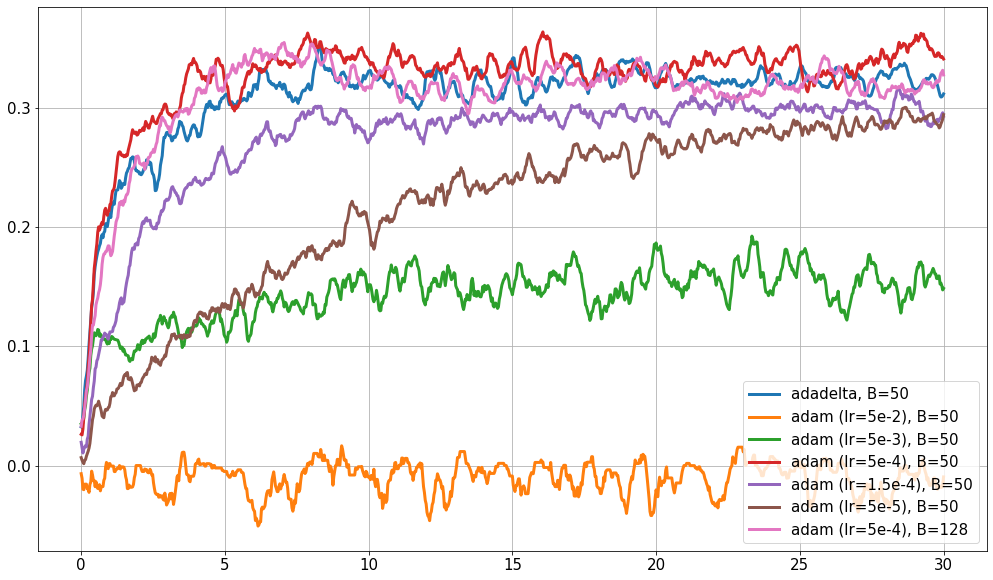

In [19]:
x_max = 30
fig = plt.figure(figsize=(17, 10))
ax = plt.gca()
for label, data in line_data.items():
    data_smooth = smooth_series(data, N=10)
    xs = np.linspace(start=0, stop=x_max, num=len(data_smooth))
    ax.plot(xs, data_smooth, label=label, lw=3)
ax.legend()
ax.grid()
plt.show()

**Conclusions**
- Adam with $\eta=5\times10^{-4}$ is the best learning algo
- small batch size (50) may be the best option, though 128 doesn't make things much worse

# Analysing different hyperparameters for BERT student on CoLA
Using small student (2 layers, 2 heads, hidden dimension 256, intermediate layer of 512 units), with Adam optimizer, no gradient accumulation, trained for 100 epochs, max. seq. length 128, embeddings initialised from finetuned teacher and dimensionality-reduced using a linear layer.

In [12]:
line_files = {
                "wp=0.1, B=256, lr=5e-4": "run-tb_Nov26_23-22-34_landonia21.inf.ed.ac.uk-tag-eval_mcc.csv",
                "wp=0.0, B=256, lr=5e-4": "run-tb_Nov27_10-47-37_landonia21.inf.ed.ac.uk-tag-eval_mcc.csv",
                "wp=0.1, B=128, lr=5e-4": "run-tb_Nov27_10-50-43_landonia21.inf.ed.ac.uk-tag-eval_mcc.csv",
                "wp=0.1, B=64, lr=5e-4": "run-tb_Nov27_10-49-23_landonia21.inf.ed.ac.uk-tag-eval_mcc.csv",
                "wp=0.2, B=256, lr=5e-4": "run-tb_Nov27_17-33-02_landonia21.inf.ed.ac.uk-tag-eval_mcc.csv",
                "wp=0.1, B=256, lr=1.5e-4": "run-tb_Nov27_17-34-15_landonia11.inf.ed.ac.uk-tag-eval_mcc.csv",
             }
line_data = {label: pd.read_csv(file)["Value"] for label, file in line_files.items()}

In [13]:
bert_data = [
#     ("bert (w=0.1, B=64)", 86.5, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01616868167363783, 0.00841961413841695, 0.010116653209593013, 0.02102973320950886, 0.00466076939042355, 0.00997814315290959, 0.014381439822235319, 0.020151541867592153, 0.004440691184296122, 0.009800949286983301, 0.0001800677737038439, 0.011053209971593106, 0.0027465592023081173, 0.007754790029586476, 0.021786618918106505, 0.017405162582707658, 0.017792955858329042, 0.028062999557356298, 0.01278844474593786, 0.002838231931930543, 0.006335483431302987, 0.02584766960666919, 0.009937774513322981, 0.018310057219405575, 0.018131699783859128, 0.025144915041708085, 0.007445834141709269, 0.008550705993641789, 0.0188755167305587, 0.006772026973175361, 0.0066393547004180405, 0.028062999557356298, 0.009537937689714945, 0.014675971344856339, 0.032190618754714635, 0.009483371051347918, 0.010896041642957854, 0.035835732728702156, 0.03561745814241877, 0.01354154050749944, 0.016395034027358743, 0.0011495189657014238, 0.0370972380110575, 0.01093677901112429, 0.03418832249926966, 0.051670199640269435, 0.03543647192873439, 0.03459685994971704, 0.037900821633292246, 0.02872527687891651, 0.032984933046177604, 0.042083430154937755, 0.017394178844114046, 0.02946631873746604, 0.047932464973473636, 0.06282936136223807, 0.028062999557356298, 0.0003435229457113354, 0.03929259108883998, 0.016214849335372976, 0.028854402929441463, 0.053378867574987124, 0.045761891989630585, 0.02309414572210015, 0.034859815223893025, 0.04179868679548643, 0.03821811813177742, 0.03614431379463789, 0.05349044119668223, 0.02654632108463314, 0.009398475602137399, 0.028854402929441463, 0.020036888256769633, 0.019745789684722202, 0.040278850595741995, 0.026957641208554296, 0.03830421900537517, 0.008009237393855761, 0.04771474022492602, 0.04110718151555729, 0.06278848183967892, 0.02815876655814102, 0.035585911716658085, 0.028164497880408618, 0.02982011699476065, 0.014370514469140007, 0.0261357853221927, 0.0015691600758433236, 0.015706834367457397, 0.025302284610837982, 0.01591752297746776, 0.007534282675628492, 0.03830421900537517, 0.04522850409903213, 0.02383628877114382, 0.018104226506708388, 0.02030622677013148, 0.030657455643529542, 0.026926502047285437, 0.06287127837692648, 0.0014006872885304006, 0.013042563065537156, 0.017792955858329042, 0.013659554432812368, 0.02233954850382339, 0.013343488692340364, 0.009589751252533162, 0.011861970572219362, 0.037645414894178615, 0.015102477317480724, 0.0391152765248753, 0.032190618754714635, 0.02316953334600404, 0.02361805641876822, 0.017394178844114046, 0.012859683701553491, 0.012859683701553491, 0.002506894853100806, 0.011876806806558261, 0.017429659250613447, 0.03900371718316963, 0.018310057219405575, 0.02481646758441379, 0.004813343932927987, 0.03161746938920632, 0.015679832508780564, 0.015073002001866311, 0.004739718708349538, 0.028572340964954222, 0.010580917818598665, 0.00823665460608448, 0.024065856475301454, 0.02057663151125502, 0.0031293492848381023, 0.01561106341173342, 0.021379251756757575, 0.03320070114893407, 0.015706834367457397, 0.01414171748760991, 0.03357459678500657, 0.030804420088859908, 0.04535200175417859, 0.048311669260294454, 0.040810735290564316, 0.07069163666348598, 0.0663083115728877, 0.05937423080750991, 0.037900821633292246, 0.04959819347810151, 0.01926724290215701, 0.03141234342367519, 0.06032200992452391, 0.04868220878408216, 0.03849804227735822, 0.03350543475734407, 0.03447936072394496, 0.057146105548704786, 0.03857366433146813, 0.05909632662589546, 0.040835269956351214, 0.04521871317410409, 0.061598457498322934, 0.03561745814241877, 0.03320070114893407, 0.036463925136011724, 0.05087723025949889, 0.05610196827856384, 0.04940156415428569, 0.050944879534587484, 0.048013440952820036, 0.03892443757821287, 0.05082590151139484, 0.024289461709913956, 0.029654926430548404, 0.03381854486077899, 0.03543647192873439, 0.044283304935136776, 0.05555272752389579, 0.06095271073945846, 0.030610899903721588, 0.06278848183967892, 0.03649796867953749, 0.04526683644927139, 0.04310139778266803, 0.05562373918301651, 0.06432340579114051, 0.04757815142095215, 0.03616246943659314, 0.06764493518740443, 0.03830421900537517, 0.05851954377465689, 0.07151611228771693, 0.07592440042634159, 0.07677941242617982, 0.007440678679384302, 0.04538451420491877, 0.061104711818736855, 0.0663083115728877, 0.07455604209059638, 0.04319340117081726, 0.07550042897690654, 0.041906827588034906, 0.0456868885783852, 0.059786071231032765, 0.0630083806857119, 0.027645102200054818, 0.025626843960230534, 0.028046019133657316, 0.05630063189259331, 0.004264485614912544, 0.07817565221065033, 0.06367809415457273, 0.056154103618999245, 0.07341707445673111, 0.04954137432960774, 0.025404442080745434, 0.05646279151222763, 0.0675442141718065, 0.044391886357278185, 0.07124118794281128, 0.0422365962296616, 0.053392648393501135, 0.022086383779856826, 0.07544551967596973, 0.10434442634113784, 0.029364267794181317, 0.027010166055576587, 0.047744510996989356, 0.079034263333353, 0.053474547726482274, 0.06277337359960121, 0.079799867690153, 0.05041759675662686, 0.04996996277691138, 0.055324085700606485, 0.06726048609499759, 0.0753013852780926, 0.06649950842111448, 0.08097826504378595, 0.05741706334465702, 0.05140223965425994, 0.05795517491879504, 0.04407597759257716, 0.046722968741604226, 0.07287342856481928, 0.08184100702866436, 0.03320070114893407, 0.036091866648171954, 0.06332614106667528, 0.05542506578552581, 0.0640114090858393, 0.0625030332850275, 0.05341435566676026, 0.06277337359960121, 0.053984583863634965, 0.08097826504378595, 0.06457230365019842, 0.035835732728702156, 0.06593610795950694, 0.03275480433652071, 0.04091332122221722, 0.04087658908232351, 0.08351461207276759, 0.07103050859666157, 0.036421972764639744, 0.056947312075228324, 0.06739625363418043, 0.04639854012432513, 0.03350543475734407, 0.04961859510444795, 0.06085854228916853, 0.05140223965425994, 0.07368102820058575, 0.06355484528612948, 0.08852460407026867, 0.06283033207890582, 0.08350243096226669, 0.04749057776105487, 0.048399353609068795, 0.047339097872981226, 0.06495888564651793, 0.029095226418458506, 0.05736354600630114, 0.051727282868258034, 0.04091332122221722, 0.059276558096691905, 0.03234728389432891, 0.031077750462997503, 0.057730528763058814, 0.04354359241177337, 0.03752217028444969, 0.048187004338684364, 0.05550147464297721, 0.07439421436325544, 0.0637251419074229, 0.05870737928940755, 0.07197483492789723, 0.03752217028444969, 0.05787465768343852, 0.07739163249484299, 0.04954137432960774, 0.05299488817098245, 0.05365794227153013, 0.06986894691574659, 0.08748827741494403, 0.06099737459901692, 0.05763614284446515, 0.0700601609158785, 0.04409643269853063, 0.098720398117113, 0.05741706334465702, 0.08787192110573078, 0.06726048609499759, 0.07611642172968787, 0.05741706334465702, 0.08097826504378595, 0.06184531049389302, 0.08433224957459168, 0.08173080198923373, 0.07508200304516384, 0.08377869819273433, 0.09847992229496319, 0.07163028805617874, 0.07530434296294752, 0.09303469121737003, 0.06290286828136452, 0.08961786890867358, 0.0699182026262619, 0.08991766849114916, 0.07384310825526075, 0.078501645978455, 0.07504008327348069, 0.07672808876985052, 0.05339554389091844, 0.09315071287973675, 0.03968462540124008, 0.07237732899835453, 0.055705518956243635, 0.07303447999974715, 0.08019735836930571, 0.08517665083354024, 0.05152844185670031, 0.060418073764144625, 0.0422365962296616, 0.06104308744508146, 0.07389741909805585, 0.07345313736624184, 0.0671363024821524, 0.026316304536574357, 0.036671236618094724, 0.06619273726158614, 0.05722159267274816, 0.021284352310143858, 0.07535452338691677, 0.05071916126627376, 0.06559138406092618, 0.03927052258597846, 0.04524598770979936, 0.07170607943811631, 0.06901502810354548, 0.05753823514292109, 0.05913990204236021, 0.04797771844318346, 0.05933442653319632, 0.029844452857321267, 0.07544551967596973, 0.056276415734595193, 0.056012880002505754, 0.0535246461232273, 0.09787842839834016, 0.04323972271875699, 0.03429037595778285, 0.05579681874032492, 0.042593996647176, 0.027746505140274224, 0.058662578270229894, 0.02654632108463314, 0.052940466621066426, 0.06139742341226115, 0.05602220380731762, 0.09430442091064549, 0.08012754784920437, 0.07583780644379781, 0.04967441218327545, 0.07826470414136258, 0.10657127947115795, 0.07637297649668551, 0.11364569650706541, 0.09702614755535717, 0.06283033207890582, 0.09652658007087381, 0.047855571978071935, 0.055363200855729496, 0.05741706334465702, 0.06744600627752982, 0.07516787112764689, 0.053840264337449324, 0.05337261939563274, 0.05725623921500871, 0.04857665539167426, 0.08220636763584084, 0.08239016064333389, 0.04996996277691138, 0.03480069416770672, 0.029654926430548404, 0.08689489035391076, 0.06508209915802436, 0.04517907666247799, 0.05285651111171711, 0.02815876655814102, 0.017503153909448493, 0.046722968741604226, 0.03693055527974461, 0.06458933402274059, 0.07376350258505783, 0.07937206460201143, 0.07868877980962859, 0.07622114076026675, 0.07846767020841128, 0.07502770020468048, 0.04695404127095166, 0.06028647226705948, 0.038077458624976544, 0.03217758569491649, 0.04417795756419906, 0.04944176992936813, 0.07506243379150007, 0.0698033595057873, 0.06491999014093963, 0.050441750469488386, 0.03262037105739361, 0.05753823514292109, 0.04380366626866036, 0.035007492139164285, 0.035660026734201634, 0.03898381781449949, 0.07990007637740865, 0.0958180521237337, 0.055260879294738545, 0.049253707794355645, 0.05128155036243111, 0.10229306654324463, 0.1295601580796756, 0.05823268671305775, 0.060418073764144625, 0.07044477018230917, 0.08237903942226402, 0.04201346011785788, 0.046198326521507356, 0.031499151171306354, 0.05153257061985139, 0.055312607111279534, 0.0696196297712004, 0.04771474022492602, 0.05937423080750991, 0.05141678648216224, 0.07677002567721895, 0.0667446687176308, 0.04955074104603231, 0.03572649449189914, 0.0751940841818462, 0.03404334095926538, 0.05380379903564993, 0.030610899903721588, 0.04765118573947667, 0.04322606125277074, 0.055881382843759764, 0.05487684597353416, 0.039368239635049644, 0.03821811813177742, 0.05404971904497897, 0.099305503020789, 0.0925750573417966, 0.11629828404008079, 0.06283033207890582, 0.0637251419074229, 0.04634015524680143, 0.06638707079358845, 0.04977057920996428, 0.050323637519633195, 0.0630083806857119, 0.05917342054031377, 0.06276892460867124, 0.09469746046273791, 0.0028515939637121287, 0.038443627111192945, 0.05377425357123431, 0.03183582577199197, 0.053840264337449324, 0.045240553841666885, 0.04327875656568797, 0.012594373907967162, 0.0540626140385951, 0.025473687623838073, 0.038875296643154374, 0.041450301527939576, 0.06692046409660439, 0.06197534806402718, 0.048098337931156254, 0.06877722470590567, 0.024200181039960317, 0.04333714763759323, 0.06522174364140582, 0.048902336538266075, 0.023484736323457267, 0.06316634205830086, 0.04150664746419748, 0.0698033595057873, 0.07222399211477463, 0.05656309498877888, 0.06994356793961189, 0.08811408651094657, 0.09842342220518424, 0.04354359241177337, 0.04053663529261919, 0.06094545754962005, 0.0694887368707697, 0.03995108940301536, 0.04959819347810151, 0.07133739563552746, 0.05950348658831357, 0.046611765375678176, 0.08476330990265361, 0.046103417466444314, 0.09241418878475854, 0.06649950842111448, 0.040957128084235656, 0.06986894691574659, 0.07854230017632119, 0.06975903774373932, 0.04522418548330422, 0.057215655069032416, 0.04327875656568797, 0.06806808924047816, 0.04940156415428569, 0.07197483492789723, 0.04854949186723175, 0.08701787714545518, 0.08173080198923373, 0.06099737459901692, 0.06094165549964962, 0.055339947446962884, 0.08698993447920254, 0.07246016046414057, 0.06121418590809968, 0.09362160966096678, 0.07214106579302515, 0.05341602033199417, 0.079393914078019, 0.11862301856924173, 0.0701413690807314, 0.04212343018316354, 0.06099737459901692, 0.07170607943811631, 0.10029697536403265, 0.06872880450180166, 0.07025101897674729, 0.050146250380849536, 0.08087876396389602, 0.08661326972492873, 0.07676746462839329, 0.08525229511786316, 0.051435638775411546, 0.060221042556736167, 0.07201532362835111, 0.0786445468517122, 0.059107020499116744, 0.10864609205493897, 0.049708328073961375, 0.06214528247338907, 0.048902336538266075, 0.034139227173500736, 0.03685588460844583, 0.06997384517281006, 0.06094545754962005, 0.07248942984580178, 0.04081387375515932, 0.0628591348882118, 0.07160247030480453, 0.04501923173366616, 0.048013440952820036, 0.08067036261932208, 0.08671217957813651, 0.04695404127095166, 0.03625207146464615, 0.06856916002686159, 0.03741280966048571, 0.07692445785673765, 0.0627680329700815, 0.05618746055157946, 0.06332614106667528, 0.10578503917921217, 0.07676746462839329, 0.08399871982284468, 0.08010353557927898, 0.061526408469176966, 0.08631200825182231, 0.06307407488404682, 0.0995309853337409, 0.07854230017632119, 0.0643406632993554, 0.0370972380110575, 0.049253707794355645, 0.06481393403669158, 0.04269154548032182, 0.07376350258505783, 0.042593996647176, 0.0719158420648774, 0.07051986065319861, 0.08424968917256481, 0.034302191306513005, 0.07511258166129357, 0.0902344207703017, 0.10700833465916305, 0.09479027897712053, 0.08664499762613781, 0.08410484595644799, 0.07537092144755213, 0.07653648607873226, 0.0559040181890046, 0.06481858054613046, 0.0594428346569121, 0.07025101897674729, 0.09213306820299823, 0.09880168479861816, 0.07749142464202105, 0.050730048783595875, 0.04247199811628232, 0.06868129335586573, 0.0984686555826231, 0.08500860049555697, 0.06642434757612775, 0.1080162829766777, 0.08523100839497286, 0.09808620548652257, 0.09869605947283347, 0.11569699579613721, 0.09018926530029178, 0.07011570306707723, 0.10995470323184872, 0.044245713322592216, 0.08661326972492873, 0.0807700884166316, 0.112327763443674, 0.09725819040231834, 0.07069163666348598, 0.08051243929793982, 0.07320190629695432, 0.10631099410683355, 0.11220325850686207, 0.09458291369481411, 0.11528328095899598, 0.10451124263480288, 0.12048172249359795, 0.04955074104603231, 0.11377281003015564, 0.11720933695122061, 0.11042882140267563, 0.10911226324641782, 0.11569699579613721, 0.114967208617363, 0.11075235134282446, 0.10168570665597802, 0.08631200825182231, 0.08280551072986472, 0.11219303574141143, 0.05573034210085416, 0.06795103325267082, 0.05753823514292109, 0.0572236279233318, 0.02909206655469717, 0.0822929309939614, 0.07877634625124673, 0.09226658689076538, 0.07893265751734191, 0.1043094372829311, 0.12389958618272844, 0.07877634625124673, 0.061598457498322934, 0.07160247030480453, 0.08332630908455557, 0.08936381909106911, 0.08502185886672424, 0.07774543855768805, 0.06277337359960121, 0.09428675685056584, 0.10614316120782262, 0.10456009191992248, 0.039575487303080685, 0.08356180265068418, 0.08579883434095181, 0.09314748858753631, 0.0723439523958378, 0.0805317290469997, 0.1240676644990556, 0.08316166103559776, 0.12395711901056716, 0.08410484595644799, 0.07552845006017701, 0.10772375765100758, 0.08369053019265868, 0.11980110428765138, 0.0979893832099526, 0.1163333073924135, 0.0910511387434359, 0.09430442091064549, 0.10421151134631199, 0.08361592333965447, 0.07197483492789723, 0.07335755495747934, 0.11335029352220401, 0.10776592326202887, 0.06850814852032129, 0.06642434757612775, 0.0937059938900013, 0.0808417344884979, 0.09034840020879953, 0.07197483492789723, 0.09996873695642235, 0.12611807765809996, 0.060418073764144625, 0.09206684354629202, 0.13054418666389672, 0.11951759867653083, 0.07266677799167778, 0.07965962331190174, 0.11363245756931263, 0.09640358450005744, 0.0735000503955886, 0.11784548947032478, 0.10879024574677724, 0.10675773514997425, 0.06277337359960121, 0.088247750732972, 0.10937979173366325, 0.10213444124482027, 0.11293208324059482, 0.0889647792916452, 0.09146478002359087, 0.08737864705766513, 0.09623711399540488, 0.09906642614788483, 0.1163333073924135, 0.09489576457775489, 0.08278282756852208, 0.11823250021394391, 0.10212488561265891, 0.10010417402185123, 0.11755492472809204, 0.11493744373718494, 0.1341616641120523, 0.1292242676891085, 0.0819224208673349, 0.11648596626456433, 0.0663711143241563, 0.09454691083767781, 0.08569348900620244, 0.10178831079319654, 0.09562288092658654, 0.09950794116010671, 0.09213129238604786, 0.10214911009374006, 0.0871884022169443, 0.10369040106790976, 0.09110120942050462, 0.1025993350656801, 0.07057565775964145, 0.10421422604679326, 0.10864609205493897, 0.08796598397099724, 0.10369040106790976, 0.1292242676891085, 0.07687488069091071, 0.09133893434302506, 0.11251851658154735, 0.0613267678702936, 0.08957739908603422, 0.09623816565720122, 0.11820165145116945, 0.11328096231239451, 0.09532212745017962, 0.12250213229054781, 0.07893134680578537, 0.10442843940427693, 0.06552839220715172, 0.14126608755137604, 0.10018630520281055, 0.15536432236502531, 0.10776570915313746, 0.09772288984821785, 0.1245349284259271, 0.10236675629294942, 0.09042430279352305, 0.10598373384843077, 0.10121883963858187, 0.09277018719404721, 0.08459402343109, 0.056947312075228324, 0.1072268901195801, 0.1071409158967251, 0.11075235134282446, 0.08987782248314084, 0.10376784272580103, 0.07333874182760093, 0.06644731312992483, 0.08935696974476694, 0.11363806297455119, 0.053840264337449324, 0.08232528629483941, 0.07728716020021262, 0.11363806297455119, 0.09345576858855272, 0.13062010555525522, 0.10400282407668013, 0.1117202532475838, 0.11837776212937617, 0.1546744355780243, 0.10554725990361002, 0.09280590703570978, 0.11100487113345582, 0.11391096350272635, 0.13010877692003636, 0.11613010150974377, 0.09193331749307261, 0.12180975296769522, 0.10138189841165582, 0.1227895067378549, 0.1080291656147323, 0.1007907702837943, 0.08014099403898331, 0.13466162806951823, 0.08173348988980972, 0.07676746462839329, 0.12561099247020174, 0.08029505917458109, 0.0980520969731504, 0.08760681416621796, 0.12403719563254378, 0.1265205184125765, 0.10425941947696045, 0.13111319949908487, 0.13381655801110318, 0.1174149478671109, 0.11289993338179437, 0.08171582534799557, 0.08338217456031888, 0.1430769254796344, 0.113542186936471, 0.06989789731117681, 0.08006803097744833, 0.0978030473395731, 0.09623711399540488, 0.1164638713613227, 0.10740559832273351, 0.050146250380849536, 0.04856926237973252, 0.07711798579176454, 0.11271984105743503, 0.07441114369742452, 0.08420916597044516, 0.06663829062933842, 0.11497285700769203, 0.09640358450005744, 0.0751940841818462, 0.08997293617056625, 0.08661326972492873, 0.07562004435105749, 0.08457401138395512, 0.08205498032090315, 0.09124679041516409, 0.07338274286387873, 0.12326483141550955, 0.11138789717801419, 0.08008155523655092, 0.07084624508689408, 0.08269961086957772, 0.0889494168737617, 0.09785200767509804, 0.06457795602548294, 0.08956433700313672, 0.09673744644490058, 0.0737577924678814, 0.08636939320170842, 0.07572065513550859, 0.07471251099268207, 0.098720398117113, 0.08631200825182231, 0.09380508409449491, 0.0833701192324515, 0.09026144638070416, 0.11157339595108458, 0.1308876623615957, 0.12403719563254378, 0.12652123245581667, 0.11126928737537521, 0.08854452209489133, 0.11432172262291045, 0.1262905085824751, 0.10006918179126624, 0.12642448376972631, 0.1326083456924032, 0.11114100894425577, 0.08057925665929164, 0.11698672035761046, 0.13218665846545025, 0.11888994615792839, 0.10475135779710908, 0.061448765230813496, 0.09305897560752993, 0.029543004917846612, 0.06649950842111448, 0.11268021696428915, 0.11021537077871295, 0.08316166103559776, 0.09426976277858662, 0.09382531044667879, 0.08300801435614485, 0.1129048035523458, 0.10314175077095872, 0.08712157620257331, 0.10675773514997425, 0.12170294095356465, 0.09256957298002096, 0.13267650113742163, 0.0999892222211763, 0.1118019961828181, 0.08188399714515017, 0.09476713192503511, 0.1160512247632695, 0.13335770254461785, 0.11547717476654641, 0.09342961783484856, 0.08987782248314084, 0.11591917721364438, 0.11823824691490856, 0.12403719563254378, 0.10276732349491906, 0.14273418958524808, 0.12495974902322869, 0.11565230312821789, 0.08885274797030437, 0.12337585976532886, 0.06495888564651793, 0.0867886819104575, 0.11682942647073667, 0.10124530770557133, 0.135781442012244, 0.1299520325815454, 0.13813834225910054, 0.034859815223893025, 0.10771962552963024, 0.09187753419792309, 0.09880168479861816, 0.09830103442718725, 0.1282178349773743, 0.11328096231239451, 0.08389114395716009, 0.08670797170558309, 0.1263955045559858, 0.09280737796535464, 0.1351719322476463, 0.11339079937553255, 0.1125458026825155, 0.08787192110573078, 0.10935237096567217, 0.11045920450276826, 0.07214106579302515, 0.1255106947046126, 0.09906068273338402, 0.13888004560924525, 0.09676842158844572, 0.09640358450005744, 0.09353157232191199, 0.06363826965813457, 0.09012716809012944, 0.11729653385057198, 0.13542152226426366, 0.11098502113390296, 0.10276732349491906, 0.1241418293413056, 0.11009119588081355, 0.148997135449458, 0.1349024075654116, 0.10451124263480288, 0.11594367242723415, 0.12128516808158207, 0.13524474790045696, 0.12785727135798883, 0.1227895067378549, 0.12318767737514226, 0.14060825792955126, 0.08817679317404872, 0.11926818464018978, 0.12785727135798883, 0.10372884998165778, 0.09515673664647, 0.11328096231239451, 0.12446164586866632, 0.1301769858370022, 0.13467705968291657, 0.12358539611043015, 0.14212340622059746, 0.13838973667923204, 0.11075800593075964, 0.10425045969834831, 0.12044825921692395, 0.1301769858370022, 0.13466162806951823, 0.12753266172388006, 0.13791443269328946, 0.1382080428749744, 0.1117202532475838, 0.15840548424593626, 0.13031143777308465, 0.10516710756678355, 0.15978210828521083, 0.11450544212711358, 0.12201011387378638, 0.12668522621629066, 0.12988566525319356, 0.11320847253358887, 0.12298793282357692, 0.10485882530466616, 0.09026144638070416, 0.08928214287755379, 0.09790841006566771, 0.10655495161307459, 0.1705480064842217, 0.13391692543865394, 0.12449242919020706, 0.12237836244272593, 0.08961786890867358, 0.14032838779141854, 0.08827163897729075, 0.1276326424444418, 0.12652123245581667, 0.1313025643570977, 0.08603638227569661, 0.13200843510129553, 0.10539239067627112, 0.09892672481640027, 0.10597121055037113, 0.1339321766850336, 0.11157339595108458, 0.08390635083954565, 0.08239016064333389, 0.07719835503959893, 0.09526372529156256, 0.10229268006391969, 0.1503623456988113, 0.11595834724023306, 0.12201011387378638, 0.12474305235886379, 0.10138189841165582, 0.1129048035523458, 0.09868528596279204, 0.10400282407668013, 0.14514936207481444, 0.08631200825182231, 0.07205355929260891, 0.08718618506749748, 0.08502534507912228, 0.1096608806300982, 0.10039948240641933, 0.11488812698329462, 0.10614316120782262, 0.13447152115893618, 0.08991766849114916, 0.04150664746419748, 0.07295783642365287, 0.1056298501012114, 0.12017076696608325, 0.07749142464202105, 0.08173348988980972, 0.09623711399540488, 0.09742778665399872, 0.12496674436947987, 0.08827283100826575, 0.12961235818308653, 0.11547717476654641, 0.06649950842111448, 0.08410484595644799, 0.1004919286105583, 0.08286492529845838, 0.11759091197524837, 0.13876395367788164, 0.12354389228832875, 0.12291545989782147, 0.11259207426914533, 0.10833818492596821, 0.09309617066631007, 0.12937583025031932, 0.13048994532888494, 0.09442995881521257, 0.13239559017359614, 0.10362295847395028, 0.10071039688788999, 0.13505893916961673, 0.14021328845591102, 0.0719257379824738, 0.12806728225067732, 0.09332498108147119, 0.1447657188248484, 0.13267551093759267, 0.11856425720018778, 0.14381261021088423, 0.13567605828620863, 0.11231070973871586, 0.0833701192324515, 0.11333472372158096, 0.08350243096226669, 0.11510140889517931, 0.12122627331722984, 0.14556009204558507, 0.10237113576823219, 0.14024670778332954, 0.11197667101185634, 0.08960663570366986, 0.09056295147029814, 0.0979893832099526, 0.11484179139187421, 0.122596176468411, 0.11128941731338166, 0.11138789717801419, 0.14019058441626892, 0.08390635083954565, 0.09740160663737114, 0.08997293617056625, 0.10919902630524979, 0.10767522887348824, 0.11809845732805219, 0.06859008149369664, 0.08483083503493666, 0.0799181584309579, 0.1154470373729055, 0.0979893832099526, 0.11045099331868283, 0.11026588816900941, 0.10486251191471471, 0.15033778215215265, 0.13267650113742163, 0.1099836582703807, 0.07692445785673765, 0.12441796835193293, 0.10603855839346674, 0.10313126026656533, 0.09491950803582828, 0.07893986331660625, 0.13359757959042426, 0.08420421416082549, 0.0964637619956757, 0.08350243096226669, 0.1007907702837943, 0.113542186936471, 0.13265732178325915, 0.12939371252468282, 0.11157339595108458, 0.1255106947046126, 0.11126796125753434, 0.12247959665279079, 0.10508966930067742, 0.11166418336918776, 0.10631099410683355, 0.11847158572617092, 0.1317096471130124, 0.11361555659659135, 0.10537786452157547, 0.11071559956127601, 0.06654844414725992, 0.07840041740320505, 0.10039948240641933, 0.09109158685998472, 0.1075479635452414, 0.09765136490036531, 0.10478569559489921, 0.10878095835272167, 0.11128941731338166, 0.09332498108147119, 0.09676842158844572, 0.11698672035761046, 0.12753266172388006, 0.1376016251890398, 0.10022470847147667, 0.10027467906851985, 0.08399871982284468, 0.13263777508261554, 0.08987782248314084, 0.09532212745017962, 0.08710021280330801, 0.12479603157580905, 0.10700833465916305, 0.11057355477392833, 0.1316256723607866, 0.09362160966096678, 0.13132135943148113, 0.11220325850686207, 0.10919902630524979, 0.1569736875564296, 0.1149251444006957, 0.11162331444159394, 0.08994672192785248, 0.1180750773759893, 0.10294646506765505, 0.0616786689864229, 0.054410982890180655, 0.10797517702222684, 0.09507792970617555, 0.09160069472210088, 0.09686387755101704, 0.10540113941286312, 0.12495974902322869, 0.14981027149353088, 0.14021328845591102, 0.15667250364117286, 0.14016364851411592, 0.15669076864895734, 0.11974300170070756, 0.16116350262722992, 0.1096608806300982, 0.1726175622824031, 0.11484179139187421, 0.099305503020789, 0.10148788998901415, 0.13277512093195407, 0.1480697745301473, 0.10838156685747079, 0.14355568496971988, 0.13870216975054203, 0.10656487580892658, 0.10463488919851624, 0.15908042197998964, 0.11332497772526803, 0.12496674436947987, 0.15667250364117286, 0.14527407512953955, 0.15647543352664126, 0.1598468688763226, 0.14723762770169657, 0.1349024075654116, 0.14692302004050287, 0.15536432236502531, 0.16150714276366848, 0.13567963064746086, 0.15283000765840538, 0.07246016046414057, 0.1541660576928962, 0.09842635371376497, 0.13817391149738298, 0.11251851658154735, 0.0983454308058509, 0.11980110428765138, 0.15033778215215265, 0.17533901190131632, 0.1730242966736766, 0.1272135164966438, 0.15397939148654086, 0.13442448823980385, 0.06877722470590567, 0.11569699579613721, 0.10437798570183357, 0.14600208867201817, 0.17029117207350056, 0.14604701295271827, 0.104859392608396, 0.12867988680928236, 0.10261174111560117, 0.1240293344707953, 0.12474305235886379, 0.1007213816329287, 0.08327699369652058, 0.14515651511170263, 0.12015323402935607, 0.14130962950692585, 0.11488812698329462, 0.11915582053056627, 0.12874085872355395, 0.13966430567756255, 0.1447657188248484, 0.08852460407026867, 0.09491950803582828, 0.13817391149738298, 0.15330127064131505, 0.09620445703087042, 0.10375566789674238, 0.12240849993250438, 0.08237903942226402, 0.08269961086957772, 0.09939195329760639, 0.11980110428765138, 0.13021134150316233, 0.10425045969834831, 0.12652123245581667, 0.10767522887348824, 0.15037680465683348, 0.1532130557772793, 0.19949112691831408, 0.12813776301357746, 0.14169502080714078, 0.15410742876189107, 0.13893522193801636, 0.1447657188248484, 0.10969920765703453, 0.10740559832273351, 0.135781442012244, 0.14032838779141854, 0.13956091616254496, 0.12714073206913534, 0.13370250196835914, 0.10437940095807845, 0.10569679566761644, 0.11335189203790383, 0.11214725254376211, 0.11009553909792837, 0.11180692483353208, 0.09483426761231659, 0.11425291837052741, 0.10701684633576483, 0.11527501087183221, 0.11761308481826867, 0.14578167065086653, 0.14319984363692445, 0.13863244404031252, 0.14221178611867658, 0.1475501827091433, 0.1117202532475838, 0.10700833465916305, 0.0812620979720463, 0.11648596626456433, 0.0983454308058509, 0.13567963064746086, 0.13802333349802162, 0.14578380892547596, 0.16606758801107105, 0.15551155932255667, 0.14618855870968453, 0.14691536294583213, 0.15226894704155297, 0.1700913982423939, 0.1438420105199032, 0.1475818433959717, 0.13263777508261554, 0.09174525253974859, 0.12913267172276754, 0.1332339418309482, 0.11876003770200773, 0.17633366876902362, 0.15836254321699772, 0.14412496021603272, 0.1480697745301473, 0.14466290297616988, 0.18868862759399188, 0.10100998770277704, 0.1711331421914571, 0.12073105148250744, 0.17492857229008316, 0.15064872454584272, 0.1367129852888476, 0.1664414876598719, 0.11840592540158627, 0.16003208545469114, 0.1462949986238289, 0.10598373384843077, 0.122596176468411, 0.1547087454784433, 0.12172116730170811, 0.12983916064514503, 0.15536432236502531, 0.12017076696608325, 0.16721563377103382, 0.17396436773458487, 0.19121121131464267, 0.1430769254796344, 0.15538967192478767, 0.151586500059387, 0.16460025110414658, 0.13370250196835914, 0.13833501598474449, 0.13433055918306755, 0.13542152226426366, 0.13659357568149674, 0.13242562046875356, 0.07692445785673765, 0.10884576819792133, 0.14285173272758805, 0.15162123096837243, 0.1388225851364799, 0.1262905085824751, 0.12887807716538016, 0.16550805420117004, 0.12428013934170246, 0.12606515711153543, 0.17439152888200474, 0.1272125643393363, 0.14556009204558507, 0.14252385325401404, 0.1292242676891085, 0.1332770703322916, 0.1793083546142375, 0.17413940746442216, 0.1754666261931874, 0.1332770703322916, 0.14506259849581665, 0.16848936551325203, 0.13817391149738298, 0.11389643176464308, 0.17471151312879807, 0.10333400675225357, 0.11888994615792839, 0.11289993338179437, 0.15579463780856576, 0.10141534089220489, 0.1484712183627439, 0.13966430567756255, 0.1430769254796344, 0.15323513160455987, 0.13659357568149674, 0.13583436584950173, 0.12237836244272593, 0.15657761279559218, 0.13509845465208634, 0.10796146569327149, 0.14950398127269326, 0.15176999697358393, 0.15552849242936764, 0.10655396891562377, 0.12939371252468282, 0.1266128342317308, 0.14381261021088423, 0.14621718040799966, 0.1675627484766625, 0.13542152226426366, 0.15319696216149775, 0.1386776318632615, 0.12138572563145401, 0.14252385325401404, 0.1435960591984624, 0.1552647727573593, 0.14618855870968453, 0.1362646300185788, 0.1207894545539838, 0.13048167629441298, 0.15737870696296974, 0.11941328770402174, 0.11547717476654641, 0.14546371803317323, 0.10885779554312716, 0.14578167065086653, 0.13876395367788164, 0.13512488808418308, 0.17679003949624963, 0.13066345719085995, 0.13265732178325915, 0.11415043333891922, 0.1483659579882051, 0.12701600589044085, 0.14019058441626892, 0.1229288843319562, 0.10478569559489921, 0.1589594075039834, 0.11957545052162556, 0.11361555659659135, 0.1352112068431589, 0.13512488808418308, 0.16693733332967214, 0.15711532287236443, 0.15552849242936764, 0.16202489539250023, 0.1481754629938784, 0.20980096107461146, 0.15319604229405917, 0.12961401969716496, 0.1718185995039239, 0.1440002588239908, 0.14355568496971988, 0.17795155131480722, 0.1720264749795086, 0.1736392179160818, 0.15187227876912165, 0.1308876623615957, 0.15230980268138064, 0.16712535284826302, 0.13870216975054203, 0.1467615531687675, 0.12960515007382117, 0.13182867229435982, 0.14278631948738668, 0.10475135779710908, 0.1527686339718374, 0.1411479197917594, 0.11856379152345058, 0.135781442012244, 0.1616230121252686, 0.11965477462289946, 0.13872390959017603, 0.14262495804322925, 0.13667652633742342, 0.13061260395439572, 0.14869499228843402, 0.07679661250315695, 0.158841901878975, 0.15801481438452158, 0.1583546690158471, 0.14221178611867658, 0.140422853653535, 0.1263354953107224, 0.1661568948083233, 0.13031143777308465, 0.13693365735983404, 0.13651201455651726, 0.12433386233932112, 0.12145555913590579, 0.12326483141550955, 0.12403836789999605, 0.13651201455651726, 0.12652123245581667, 0.14515651511170263, 0.13989747889143722, 0.12670646589134005, 0.12633270208606293, 0.11510140889517931, 0.12533414798451334, 0.12247959665279079, 0.1262905085824751, 0.10300144446877145, 0.11021537077871295, 0.1318705421482768, 0.12753307190734858, 0.15270447659230063, 0.12806728225067732, 0.12743201022799838, 0.1817335620011774, 0.12359851987031846, 0.15187227876912165, 0.17277126394964018, 0.15801481438452158, 0.16894622143358706, 0.13433055918306755, 0.1382080428749744, 0.14545828625749307, 0.1332339418309482, 0.12474305235886379, 0.12668522621629066, 0.16722732946286914, 0.122744353099175, 0.14073871442147143, 0.14409561823208006, 0.1411479197917594, 0.11658348355677788, 0.15323513160455987, 0.16551415101137537, 0.16438447105868612, 0.14169502080714078, 0.1615890740731301, 0.1722920462676554, 0.16917551087934685, 0.15721204793196886, 0.125593640664348, 0.15808807692663074, 0.14514936207481444, 0.15812682982364468, 0.14862723618778087, 0.13337205503723426, 0.1308876623615957, 0.1447657188248484, 0.13036371654085388, 0.14538104651913114, 0.15014313203545393, 0.16438374052011195, 0.12533414798451334, 0.16032939082845873, 0.12493074766671824, 0.13638766557868867, 0.12106933044866976, 0.14597831570491235, 0.14030737520597586, 0.14748528554887863, 0.16183933266749892, 0.14556009204558507, 0.1366160604477477, 0.11156494078271653, 0.14278631948738668, 0.1332770703322916, 0.15669076864895734, 0.15040124525819165, 0.14246039420617296, 0.13297018961680268, 0.14183939142177115, 0.12815195996316056, 0.12017076696608325, 0.1125458026825155, 0.12324939168278147, 0.1484712183627439, 0.12652123245581667, 0.153421862652058, 0.1661568948083233, 0.15969373103243215, 0.14600208867201817, 0.12988566525319356, 0.13267650113742163, 0.1548542847934036, 0.15694418399486407, 0.12495974902322869, 0.16448776146389088, 0.14898407552195042, 0.1351719322476463, 0.12106933044866976, 0.15095117889320872, 0.1710134520871901, 0.13956091616254496, 0.17523704842787105, 0.09217016515563498, 0.12324939168278147, 0.14898407552195042, 0.1056298501012114, 0.13870216975054203, 0.14724193461503085, 0.1263354953107224, 0.12002794975298987, 0.13938221629721187, 0.16237742828279034, 0.14212340622059746, 0.13433055918306755, 0.14723762770169657, 0.09823785936359286, 0.10206949543458196, 0.1197750004046856, 0.16550805420117004, 0.19071853921694057, 0.1573438474686081, 0.15613491091732531, 0.10229268006391969, 0.12937583025031932, 0.1505432140458159, 0.09627459420309098, 0.12263959574944572, 0.1382148643862526, 0.13691968918269184, 0.1533673271834565, 0.10675773514997425, 0.14178619470571371, 0.14701856533254504, 0.15477750829877024, 0.1730283100941559, 0.1500719948141155, 0.12434471826730632, 0.12199950820991907, 0.17774255474203954, 0.1813121734628785, 0.17176091703922497, 0.1602402703538782, 0.12046776548411303, 0.16682543613096285, 0.17858973001443598, 0.13788921989789135, 0.18587359866855782, 0.16693733332967214, 0.19056373283634923, 0.19732069143082395, 0.1651601068676887, 0.14578380892547596, 0.1529442480840972, 0.16168233977400553, 0.17683711490102408, 0.1574390609429468, 0.182999033949853, 0.1843787092383111, 0.1290768413799422, 0.14337815970104767, 0.12568055969019556, 0.16919384617872169, 0.18698858420655232, 0.15793444673651402, 0.14203433536296045, 0.17606243748479136, 0.1671869674014019, 0.1464822314698167, 0.1705480064842217, 0.1513921170584048, 0.1611978847644058, 0.17068451199147877, 0.182999033949853, 0.18323623036230935, 0.18142534021863846, 0.13743949745457118, 0.14750388305466128, 0.16062779970833818, 0.15659567540712505, 0.17995356215340358, 0.18173361457823922, 0.16319960767804306, 0.19979672933698073, 0.14994925493926686, 0.14991822607246263, 0.1386281830286153, 0.1505432140458159, 0.1504819907662161, 0.17147303844309936, 0.13417795950044448, 0.13146313888377983, 0.14889144215769273, 0.1363583382435979, 0.17746544267549333, 0.15344823976091784, 0.19820268747055683, 0.19513275547852374, 0.12673711771609336, 0.12127871760681282, 0.19036252209044616, 0.12048172249359795, 0.12589214342534782, 0.18799761419331315, 0.16780760512522008, 0.1732439168586429, 0.17336432249677297, 0.13950398192105706, 0.18393884801510266, 0.1544594872362459, 0.18047055837230605, 0.14797806175631018, 0.1426548528713053, 0.1317701093275558, 0.1015089264900061, 0.14821106646634613, 0.14164159767556192, 0.15410742876189107, 0.15949886393061957, 0.1752470735262017, 0.15330127064131505, 0.1500719948141155, 0.13356139258109112, 0.11067979902043971, 0.11856379152345058, 0.13370250196835914, 0.15659567540712505, 0.14649120260965362, 0.17125329358420754, 0.11335189203790383, 0.13876395367788164, 0.13116942570110574, 0.16179503723852764, 0.13583436584950173, 0.13416706058165595, 0.14073426760849095, 0.1357212022797229, 0.17277126394964018, 0.13583436584950173, 0.13652439071788025, 0.15087119476418223, 0.14412496021603272, 0.1317096471130124, 0.15755650777066363, 0.16274222623181592, 0.13325205908229223, 0.1699251833566497, 0.18054976357926977, 0.1460057686788094, 0.15272109692456087, 0.15565312844156887, 0.13691968918269184, 0.1673902470349338, 0.13693365735983404, 0.1320653407416963, 0.1096608806300982, 0.17277126394964018, 0.17679003949624963, 0.16828270691975378, 0.1599028876767957, 0.1806794564702054, 0.12596192265407888, 0.13075414924463935, 0.1730242966736766, 0.16118608133306955, 0.132140208204227, 0.15884229768357425, 0.14169502080714078, 0.1500719948141155, 0.13776087629736078, 0.13894281000608433, 0.1542630759402537, 0.1312625867300468, 0.15351459101706535, 0.16472504662660795, 0.12988566525319356, 0.1560390622592208, 0.12714073206913534, 0.1561256297997049, 0.12863568802369668, 0.10896931215473486, 0.13876395367788164, 0.16036095695676184, 0.11437260350757593, 0.1367129852888476, 0.17918800901931248, 0.1558893807146074, 0.15711532287236443, 0.14285086998429544, 0.11294717334540472, 0.139126318883386, 0.16116350262722992, 0.18281098050562827, 0.17004248891982202, 0.14652320689073528, 0.16848936551325203, 0.17458593181109672, 0.16091837323651975, 0.18738232755595677, 0.19302838045638288, 0.16561716446658156, 0.14765587527376178, 0.1613134168690308, 0.13114942682934982, 0.16068516951525338, 0.15721204793196886, 0.14750388305466128, 0.15367745646256303, 0.1177302635831213, 0.14764520093228917, 0.16422741507958707, 0.15462904847924755, 0.1674416224733571, 0.17928037127444374, 0.1736392179160818, 0.15812682982364468, 0.20129910037904322, 0.16753896347636857, 0.17835493376080847, 0.16533446053424394, 0.16509702987514813, 0.19302058384816684, 0.19519532565119432, 0.17314290258042522, 0.17875404128898645, 0.1779295585832904, 0.18152327325675824, 0.16989190249351013, 0.135781442012244, 0.18313457672249744, 0.1285831585607177, 0.17735448289037614, 0.1331481188790476, 0.1806794564702054, 0.12829285352412917, 0.14652320689073528, 0.15462904847924755, 0.1616230121252686, 0.18731638018637925, 0.18393415053505277, 0.17267713440609547, 0.17063683561379675, 0.15647543352664126, 0.13982593577610886, 0.15114015567000064, 0.15517189144837176, 0.16790088897320243, 0.14750388305466128, 0.1611606574649403, 0.1647706764252208, 0.17261073967385476, 0.14546371803317323, 0.17261073967385476, 0.16585406269468903, 0.14369050121150678, 0.14957866075376058, 0.14797806175631018, 0.17068451199147877, 0.16878986366881524, 0.1475501827091433, 0.16237742828279034, 0.14691165782581692, 0.14965402607904812, 0.15808807692663074, 0.13475013027835261, 0.16368739668780738, 0.122596176468411, 0.15958549289101034, 0.17529385696473757, 0.2005895715034145, 0.18425882543699884, 0.17029117207350056, 0.14938910530229552, 0.18256265343880135, 0.16919384617872169, 0.17898645394612717, 0.20743013098488158, 0.14753382715234734, 0.18886625574116458, 0.2038900908330898, 0.17232838252747404, 0.16798768818302992, 0.15952986917019624, 0.14691536294583213, 0.17746544267549333, 0.16302107636895352, 0.16575686006800203, 0.17659728337969258, 0.15777250064651127, 0.18676999539433584, 0.14660976158328207, 0.1678710349983309, 0.1313025643570977, 0.1718926967776894, 0.1710134520871901, 0.21756808664486996, 0.17867283239743975, 0.14775941201049883, 0.16892493701930714, 0.19497689401034807, 0.20286423875683054, 0.18691052887630996, 0.15628228996253435, 0.18087297636688612, 0.1892682142808273, 0.1675627484766625, 0.17970618963824728, 0.18725459421801624, 0.16737619646779828, 0.16514812449241445, 0.1613610383168239, 0.1962378985326022, 0.20271486988064752, 0.22994354347825632, 0.17590163953317436, 0.19836291897338604, 0.20077767632962168, 0.18498272337070884, 0.19024674290162966, 0.18442223519027434, 0.17336432249677297, 0.15873662821928716, 0.1801777162594415, 0.16370395724525705, 0.1793431256335088, 0.1505602235670948, 0.19209095470280052, 0.18334286028580593, 0.18753987500783506, 0.20504421314290283, 0.17232838252747404, 0.17840087706256427, 0.16729799432962747, 0.20584338258620063, 0.21245887833334587, 0.15446414453469087, 0.14691165782581692, 0.14212340622059746, 0.15924936881803436, 0.13395492803803133, 0.163377537184889, 0.13762503260962683, 0.139126318883386, 0.15559829316622678, 0.14409561823208006, 0.12873803448668117, 0.16527270610334246, 0.16422741507958707, 0.19056373283634923, 0.1605857598283351, 0.15694418399486407, 0.1797714232226373, 0.1674416224733571, 0.16934463432068372, 0.16422741507958707, 0.17861882262054793, 0.17426266153821834, 0.1537150236323076, 0.17393287047643466, 0.15497391413808306, 0.16848936551325203, 0.17189798527512404, 0.1602350869462787, 0.16533446053424394, 0.1453243794062884, 0.12995020152084316, 0.13736820920995144, 0.1830164342481813, 0.15836254321699772, 0.17492857229008316, 0.15976010816892644, 0.1786771611465692, 0.1793083546142375, 0.19232653495059893, 0.13173532506939314, 0.19966603857188178, 0.18422512410667657, 0.13021134150316233, 0.1854067736745965, 0.21023368850969973, 0.18105450364782608, 0.17658706046214379, 0.19432520872256864, 0.17035015038137713, 0.15930352913904275, 0.20548235038963866, 0.16997637805007304, 0.21545145053538217, 0.19667640049267285, 0.1722920462676554, 0.15239920971085585, 0.1955940686399126, 0.16422741507958707, 0.15623025605088015, 0.11203236034017611, 0.15383429960714817, 0.16338017386261544, 0.16476484879054704, 0.16919384617872169, 0.13428134541195216, 0.18334286028580593, 0.14337815970104767, 0.1720264749795086, 0.12960515007382117, 0.16557069643523778, 0.13162704248574986, 0.1438420105199032, 0.17335683612485578, 0.18914243059621486, 0.14957866075376058, 0.1878170254994466, 0.16440422399090146, 0.1817363110136826, 0.1539455964890235, 0.17995356215340358, 0.19917446639499126, 0.15422705143601834, 0.17858973001443598, 0.18850013538163093, 0.21035009567453852, 0.21417617485609874, 0.20540840628059504, 0.17431842301297, 0.1820480752563375, 0.19462299157628635, 0.1774682630662371, 0.1730283100941559, 0.19761583395661242, 0.20393106950210332, 0.1957481077732811, 0.23747252635161156, 0.18047055837230605, 0.15832071367510628, 0.16721563377103382, 0.18192082734008, 0.19182139988408964, 0.17029117207350056, 0.19302838045638288, 0.17659728337969258, 0.18927056140911086, 0.18757098249419082, 0.1595876213360013, 0.20416506678926993, 0.18784456321790452, 0.1705480064842217, 0.19289163440612536, 0.17588019030493596, 0.20912923576493098, 0.21489537357173805, 0.19979672933698073, 0.17362948835008843, 0.1826247360904385, 0.20326477187801534, 0.17593921069334956, 0.18615549701817605, 0.17199857329718074, 0.17314290258042522, 0.19949112691831408, 0.1729283482671205, 0.15618156375312892, 0.1722920462676554, 0.19885639835274488, 0.17662629568144358, 0.19372397573613254, 0.21867366485502315, 0.2077534611706664, 0.1510906367388773, 0.14909670185279636, 0.17013362104880675, 0.1549391773818679, 0.1613134168690308, 0.1687469430309019, 0.13476175810742616, 0.15818516361076118, 0.12416376577280364, 0.11585661993239478, 0.15497391413808306, 0.15085691360063352, 0.18707119980355433, 0.18854897570653667, 0.2071848068349608, 0.18361105636195904, 0.19548014788377568, 0.1587605188143687, 0.17659728337969258, 0.1841104054344955, 0.22659221689796533, 0.171518535025403, 0.16054112787889724, 0.19402865106252176, 0.19440423458404832, 0.17531430141442325, 0.21035009567453852, 0.1718926967776894, 0.22815052890294182, 0.15942430779668848, 0.18191254435845491, 0.20009292464179904, 0.17378811160354368, 0.1585910019418531, 0.16692095882524208, 0.22100646381239317, 0.2373459305199358, 0.22114842961269743, 0.16319960767804306, 0.187767160687695, 0.16809521464488103, 0.1754666261931874, 0.17593921069334956, 0.17800356442291182, 0.16974758929588324, 0.18995216077389832, 0.19100365704555963, 0.19042769455245526, 0.19003430658840997, 0.1685832544298279, 0.18914243059621486, 0.1518420620565537, 0.19640155139282814, 0.1793083546142375, 0.16015423707043774, 0.13713480218962398, 0.19440423458404832, 0.2001953501511778, 0.2155059874317179, 0.17981139690599762, 0.17800356442291182, 0.18150839163244212, 0.1380831078756165, 0.18854897570653667, 0.16054112787889724, 0.16440422399090146, 0.1838605438694001, 0.16775272902301552, 0.17774255474203954, 0.1558893807146074, 0.20540840628059504, 0.1453052743139867, 0.17861882262054793, 0.16090501162494608, 0.1317701093275558, 0.16368950489474143, 0.18483007699586326, 0.21029624638171798, 0.18846816536945507, 0.17658706046214379, 0.17199883388059498, 0.16737619646779828, 0.20071550297095533, 0.14316934779612997, 0.1611606574649403, 0.17560878217535503, 0.19714871101156078, 0.18399349870832948, 0.19300306599475242, 0.171518535025403, 0.17255592689098234, 0.16460025110414658, 0.18276750686094903, 0.1650678139101115, 0.13841637765100573, 0.1954112742453931, 0.18595741559158482, 0.1989327663159983, 0.20495092870545908, 0.18242102036102437, 0.1710134520871901, 0.16302107636895352, 0.2064279310333117, 0.21185656837636874, 0.1759241571393905, 0.18707119980355433, 0.20206241531013067, 0.19372397573613254, 0.1781097717165432, 0.17390340361746062, 0.18909419058482338, 0.1537150236323076, 0.15565312844156887, 0.1368842473741235, 0.18927056140911086, 0.18799075574681304, 0.18150839163244212, 0.157552787224655, 0.15187227876912165, 0.19580648684188331, 0.16230640980327163, 0.16828679210147998, 0.18670018978636652, 0.1792564646705696, 0.1983134139810193, 0.20437298806686868, 0.18256265343880135, 0.2328790186985708, 0.20149110557824226, 0.20624907655056632, 0.17800356442291182, 0.21185656837636874, 0.16090501162494608, 0.1732453094938192, 0.17898245093644793, 0.20405673882351788, 0.20129910037904322, 0.15659567540712505, 0.16737619646779828, 0.17795509386006178, 0.20389708306553833, 0.21835821132977204, 0.21670987116205323, 0.18026608617507958, 0.17459410618133459, 0.1720264749795086, 0.196149440589951, 0.17395765465755056, 0.187767160687695, 0.14718728485028856, 0.19300306599475242, 0.14600208867201817, 0.18954364972242177, 0.14578380892547596, 0.18124158577290236, 0.18889166023774348, 0.15565312844156887, 0.18422512410667657, 0.19289163440612536, 0.1698490404778195, 0.17818558518998093, 0.19640653615972264, 0.17063683561379675, 0.19312647299700772, 0.19440423458404832, 0.22114842961269743, 0.18754063831605286, 0.18238880500723403, 0.21584180061318783, 0.1761048008420891, 0.18467014351943303, 0.1917612304570823, 0.18888324030916712, 0.18124158577290236, 0.1855157813740791, 0.17626415049229718, 0.19337168829448545, 0.17140877799170048, 0.17679003949624963, 0.18393415053505277, 0.1793083546142375, 0.17981139690599762, 0.17792348501808206, 0.18716442754183213, 0.21438954707710337, 0.17664713252800668, 0.16946946410419259, 0.18261346715072632, 0.19444543384229496, 0.1673902470349338, 0.17390340361746062, 0.20535078020847516, 0.19747622243334254, 0.19629040057860206, 0.2024510860911136, 0.18725459421801624, 0.12136201733128577, 0.15755648480668086, 0.15952523498984195, 0.16647242410801416, 0.15330127064131505, 0.18399349870832948, 0.1628723167509228, 0.173303497798858, 0.18835112903271387, 0.21322857645056367, 0.2078904208765722, 0.20262918595509022, 0.1749440301403635, 0.1816760317339821, 0.18580973036404655, 0.20648117997641294, 0.1759241571393905, 0.13462349148670041, 0.17140877799170048, 0.1793431256335088, 0.20217562003031586, 0.16643978667111345, 0.16946946410419259, 0.20199102515114034, 0.14898407552195042, 0.19258836109595245, 0.20145602526361508, 0.19747622243334254, 0.18115865587395955, 0.16878986366881524, 0.18912365474121887, 0.18654396085245517, 0.1722920462676554, 0.18060224455889326, 0.19036252209044616, 0.2221431154499795, 0.18455618176292604, 0.19126013952552084, 0.16224575967008134, 0.19231249040087545, 0.15186762741135207, 0.18618348993857367, 0.20557081888724368, 0.16809521464488103, 0.1841104054344955, 0.18854897570653667, 0.1692708972963297, 0.1730242966736766, 0.2009217582518256, 0.1722920462676554, 0.140130757881434, 0.1913731252318057, 0.1851956111780091, 0.1599028876767957, 0.1806794564702054, 0.18442223519027434, 0.140422853653535, 0.1836019811506833, 0.19121121131464267, 0.16198524898540015, 0.1771078430072386, 0.17517184646219058, 0.14425622062203647, 0.16297803975512942, 0.15135975829694556, 0.17280825541679903, 0.1722920462676554, 0.15679399061687024, 0.1759241571393905, 0.18323586489618343, 0.19373461912005757, 0.18192082734008, 0.17140877799170048, 0.17593921069334956, 0.21331815793411338, 0.15678643795528638, 0.18880296244251543, 0.15711532287236443, 0.14604701295271827, 0.18716442754183213, 0.19372397573613254, 0.18526132046499788, 0.19220271945322823, 0.1706296949230754, 0.18716442754183213, 0.16917551087934685, 0.19258836109595245, 0.19289163440612536, 0.1797714232226373, 0.2122356786676403, 0.17928037127444374, 0.13464559570806003, 0.16440422399090146, 0.17004248891982202, 0.20077136364562512, 0.18455618176292604, 0.20334542194057192, 0.19736696389598857, 0.21080586868197174, 0.17446315256722567, 0.18152327325675824, 0.19081719460634636, 0.1667169241014918, 0.1724013974497568, 0.18912365474121887, 0.1692522215632906, 0.18757098249419082, 0.17801515823155598, 0.18731638018637925, 0.2199819302827297, 0.1989327663159983, 0.16422741507958707, 0.2009217582518256, 0.16862922586185206, 0.22753965662380404, 0.18191254435845491, 0.16533446053424394, 0.17125329358420754, 0.1865236901847683, 0.18261346715072632, 0.19810129061698262, 0.17251550577144978, 0.1818437889931156, 0.16370395724525705, 0.1560390622592208, 0.17127344978212583, 0.16235264921465403, 0.14578167065086653, 0.14775941201049883, 0.18073867345165562, 0.15551155932255667, 0.16715675992190288, 0.16838442783675403, 0.15526878203993316, 0.1500719948141155, 0.14137746111001046, 0.1623553377016457, 0.16253834876831202, 0.1505432140458159, 0.20979995708344587, 0.1736392179160818, 0.15613491091732531, 0.18271098993992005, 0.14208465951920585, 0.17517184646219058, 0.1504819907662161, 0.14319602613443033, 0.15462904847924755, 0.16575686006800203, 0.18587359866855782, 0.1398998505916432, 0.14251975898851318, 0.16748032969587118, 0.1432592189811651, 0.14571954076301957, 0.1841104054344955, 0.1958308112347447, 0.17004248891982202, 0.19162830642549172, 0.17531430141442325, 0.19763239753933823, 0.1897692378923433, 0.1631996211106378, 0.18422512410667657, 0.1584328337011006, 0.19881468557328097, 0.19448903806697285, 0.1897692378923433, 0.19372397573613254, 0.16510487349066036, 0.15770601221088873, 0.15036625003655318, 0.17882304656720546, 0.19430846146733508, 0.13841637765100573, 0.196149440589951, 0.1752470735262017, 0.1659195267062713, 0.15839762509164965, 0.1547087454784433, 0.17624912571755644, 0.18361105636195904, 0.1589720732623486, 0.16090501162494608, 0.18900815052860026, 0.1954112742453931, 0.16230640980327163, 0.1432592189811651, 0.14793805440773236, 0.18927857105566956, 0.17063683561379675, 0.1560390622592208, 0.1705361408159025, 0.19885639835274488, 0.1803327393364879, 0.18707119980355433, 0.1438420105199032, 0.1552647727573593, 0.15862447952631994, 0.12380573077802687, 0.1900422370384719, 0.1733570186327145, 0.17199857329718074, 0.17473032980121947, 0.16962352015480656, 0.14285173272758805, 0.15120354160824478, 0.12005219782781028, 0.1781097717165432, 0.1597154754506757, 0.1401609250765056, 0.16131046191325002, 0.16575686006800203, 0.1712045161065497, 0.14578380892547596, 0.15186762741135207, 0.1448338867692022, 0.14991822607246263, 0.1716615639050994, 0.15064872454584272, 0.15667250364117286, 0.1504286181521912, 0.152795979990646, 0.16150714276366848, 0.17683711490102408, 0.15618156375312892, 0.15382638939543547, 0.1630058431167719, 0.19312647299700772, 0.16712535284826302, 0.17004248891982202, 0.15239553298952815, 0.1547087454784433, 0.15721204793196886, 0.14262495804322925, 0.15330085484703654, 0.1687798373932463, 0.14355568496971988, 0.16230666300309693, 0.17523704842787105, 0.17459410618133459, 0.1616331434141229, 0.1661568948083233, 0.17602819905833192, 0.19493006645626268, 0.20463697096663677, 0.151586500059387, 0.14172401247921368, 0.16417127538618007, 0.18261346715072632, 0.15327784498642255, 0.14746340592649382, 0.19312647299700772, 0.16175759295282344, 0.18746985483123144, 0.21221698887663182, 0.15565312844156887, 0.16919384617872169, 0.17469818746270194, 0.187767160687695, 0.1614350143223886, 0.18277753535634583, 0.20202574535824777, 0.17356923456287024, 0.1692522215632906, 0.18483007699586326, 0.19881468557328097, 0.218852388860082, 0.18128507399389626, 0.19003430658840997, 0.223387252577953, 0.16790088897320243, 0.17928037127444374, 0.18746985483123144, 0.17063683561379675, 0.16599709077834823, 0.19594293100431268, 0.1650678139101115, 0.16510487349066036, 0.14546371803317323, 0.16091837323651975, 0.1394079945890785, 0.17127344978212583, 0.13894281000608433, 0.16575686006800203, 0.15694418399486407, 0.13950398192105706, 0.16062779970833818, 0.14691536294583213, 0.14704799869354718, 0.1547087454784433, 0.1446154971988634, 0.17345182752277644, 0.1897692378923433, 0.18789794365866594, 0.17659728337969258, 0.1989327663159983, 0.1720035744176683, 0.1730242966736766, 0.18047055837230605, 0.1698490404778195, 0.15976010816892644, 0.1633606408529504, 0.1878170254994466, 0.19650071749128115, 0.18488177883994797, 0.18782321892449727, 0.20592681681482733, 0.15422705143601834, 0.15560896524607373, 0.1794259438018491, 0.17795434984072278, 0.15875005618749308, 0.1752470735262017, 0.1733739765249169, 0.1752470735262017, 0.20571694935049317, 0.19548014788377568, 0.16989190249351013, 0.213491710579398, 0.14409561823208006, 0.14942733529558552, 0.1589594075039834, 0.14285086998429544, 0.17314290258042522, 0.17626415049229718, 0.15755648480668086, 0.17898645394612717, 0.14426605768310313, 0.15711532287236443, 0.17016597666493963, 0.19083975398589753, 0.17083980097568646, 0.17140877799170048, 0.1887534277982207, 0.1813121734628785, 0.1979221279738887, 0.1841104054344955, 0.17139117696452813, 0.1435960591984624, 0.1882674781208804, 0.19689620786923703, 0.1732439168586429, 0.17378811160354368, 0.18073488996866113, 0.1792564646705696, 0.16370395724525705, 0.17250663326551519, 0.18327830018704147, 0.1547087454784433, 0.17220635045328583, 0.14830894439324416, 0.20939736726254154, 0.22312492961752908, 0.16422741507958707, 0.20817196027534096, 0.20297269733489484, 0.2098628816456837, 0.1979221279738887, 0.20009292464179904, 0.17861882262054793, 0.1732453094938192, 0.1711331421914571, 0.16561716446658156, 0.19956791718515104, 0.1880785186556398, 0.18261346715072632, 0.2037351935559132, 0.17898645394612717, 0.17189798527512404, 0.14991822607246263, 0.14652320689073528, 0.16373256326255095, 0.16643978667111345, 0.14172401247921368, 0.16917551087934685, 0.18707119980355433, 0.18073867345165562, 0.16370395724525705, 0.15978331997920328, 0.1584909011158398, 0.17835493376080847, 0.1548542847934036, 0.16561716446658156, 0.17362003866441414, 0.16781999986176419, 0.16472504662660795, 0.19979672933698073, 0.20163803646984613, 0.1712045161065497, 0.20400877855830188, 0.1979221279738887, 0.21903837559176814, 0.1716615639050994, 0.18323623036230935, 0.20342770054560735, 0.19949326819345128, 0.18702129963259054, 0.18276750686094903, 0.2176574022363942, 0.19671555259862292, 0.16038641347926466, 0.1556914671770591, 0.17991731506633946, 0.18335303139676118, 0.17199883388059498, 0.19111625781069685, 0.20739825653942073, 0.17426266153821834, 0.18527297181207242, 0.17719510545719055, 0.17624912571755644, 0.17884418268749336, 0.2009217582518256, 0.19513275547852374, 0.215749262643618, 0.17575133564498077, 0.20163803646984613, 0.2052070652456962, 0.2213651656973101, 0.19352617817276427, 0.18980945083814718, 0.18498746150169418, 0.18143273283327502, 0.18784456321790452, 0.19248548714084562, 0.20202574535824777, 0.19689620786923703, 0.18984065854253904, 0.17875404128898645, 0.18393884801510266, 0.18914243059621486, 0.15737870696296974, 0.18912365474121887, 0.18009494637754053, 0.14701856533254504, 0.20009292464179904, 0.20624907655056632, 0.18261346715072632, 0.1895861203540947, 0.17413006950409154, 0.18979152915550979, 0.19258836109595245, 0.22306616606673543, 0.22865388596427977, 0.19473800087015905, 0.2064279310333117, 0.18784456321790452, 0.20416628771320083, 0.17735448289037614, 0.1673902470349338, 0.18361105636195904, 0.20648117997641294, 0.187767160687695, 0.18731638018637925, 0.1712045161065497, 0.19454161862550157, 0.1661568948083233, 0.18150839163244212, 0.19493006645626268, 0.15976010816892644, 0.20453681999433324, 0.19498229402176054, 0.2239276098254726, 0.20020119544844528, 0.17523704842787105, 0.1757794806337226, 0.1830164342481813, 0.1644145439494337, 0.17250663326551519, 0.19918047335138467, 0.20408881471593668, 0.18738232755595677, 0.19567970922722008, 0.1994381269813825, 0.2066501674619675, 0.21717977726137364, 0.216458881951464, 0.18754063831605286, 0.1983134139810193, 0.20325589485182494, 0.18129035859428957, 0.17474101497204728, 0.1661568948083233, 0.18124158577290236, 0.18201266589694876, 0.17995356215340358, 0.19036252209044616, 0.22201293282295845, 0.18488473962718258, 0.19956791718515104, 0.18276750686094903, 0.18872270732358096, 0.20616380727643108, 0.14991822607246263, 0.16090501162494608, 0.15952523498984195, 0.19622761553809623, 0.1756298335479189, 0.1838806266083814, 0.19335677540318758, 0.21383481724304787, 0.16722744396677502, 0.20492784255971525, 0.18698858420655232, 0.19794896935477274, 0.21273327075504264, 0.19917446639499126, 0.17795509386006178, 0.23011563653426548, 0.18912365474121887, 0.17125329358420754, 0.196149440589951, 0.21148178606518211, 0.19246877678066251, 0.20796275588624588, 0.22578460206914616, 0.2108368134423028, 0.1826247360904385, 0.21534745412688466, 0.18731638018637925, 0.2114058563010366, 0.22980432037427062, 0.20616520955935932, 0.1838806266083814, 0.20437298806686868, 0.19548014788377568, 0.19106774086691022, 0.1962378985326022, 0.18256265343880135, 0.20325589485182494, 0.1722920462676554, 0.18281098050562827, 0.1905170901085668, 0.16338017386261544, 0.1898792567561778, 0.2199819302827297, 0.19493006645626268, 0.14506259849581665, 0.18698858420655232, 0.16550805420117004, 0.18725459421801624, 0.20391647063386514, 0.21437374429630524, 0.16504566661063733, 0.15208449808035646, 0.20165349972772914, 0.1692522215632906, 0.15926244109367382, 0.15707436252982532, 0.18221211159680895, 0.16795319401112496, 0.19872279505956214, 0.17801515823155598, 0.18455618176292604, 0.21759597327077843, 0.2062147479205027, 0.19242064877594958, 0.18927056140911086, 0.19158942235167215, 0.20616380727643108, 0.20391647063386514, 0.21717977726137364, 0.21221698887663182, 0.2006985514934694, 0.18142534021863846, 0.21322857645056367, 0.18334286028580593, 0.20076044272736998, 0.19996741209690314, 0.15186762741135207, 0.20590654318613655, 0.20020119544844528, 0.21890180965165226, 0.18650771050300116, 0.21417617485609874, 0.1788329077091717, 0.2263870954572108, 0.21334161721247732, 0.19432120141326886, 0.19918047335138467, 0.1913125866242764, 0.1687798373932463, 0.1733570186327145, 0.18073867345165562, 0.1802025287466822, 0.17083980097568646, 0.1886595769909237, 0.2024510860911136, 0.1692522215632906, 0.18746985483123144, 0.20317384037587594, 0.17725871643406393, 0.18737285807256615, 0.1794259438018491, 0.19372397573613254, 0.17925238914579836, 0.18850013538163093, 0.19872279505956214, 0.18995119153702503, 0.20463697096663677, 0.1865495118662628, 0.18870915057376272, 0.2322380764828812, 0.19314060306309833, 0.17335683612485578, 0.19820097888735538, 0.16561716446658156, 0.15531353112619994, 0.17060026499157835, 0.17125329358420754, 0.15087119476418223, 0.1803327393364879, 0.20858966172976115, 0.19106774086691022, 0.20180765302151601, 0.15208449808035646, 0.19365741047745594, 0.2253396117220268, 0.20571694935049317, 0.1738735356873133, 0.19444543384229496, 0.21036668011300375, 0.20960951333857294, 0.19302838045638288, 0.18518358605669244, 0.17728074365969818, 0.19114605650627137, 0.25125577104871455, 0.22018687368506032, 0.17995356215340358, 0.1861605708871091, 0.23454660178632541, 0.17413006950409154, 0.20980096107461146, 0.2265475965817769, 0.20518123758237117, 0.20299944827799987, 0.18105450364782608, 0.17127344978212583, 0.23084409143038281, 0.18073867345165562, 0.19640653615972264, 0.17970618963824728, 0.18914243059621486, 0.21583451853942953, 0.18323623036230935, 0.19594802300869782, 0.18281098050562827, 0.19271705938847017, 0.18442223519027434, 0.18058611390902446, 0.18191254435845491, 0.1726175622824031, 0.1718926967776894, 0.18105450364782608, 0.18785381103510718, 0.16224575967008134, 0.17083980097568646, 0.18087297636688612, 0.1547087454784433, 0.1589594075039834, 0.18256265343880135, 0.21953602189252364, 0.18201266589694876, 0.17396436773458487, 0.20453681999433324, 0.1803327393364879, 0.20772423516658342, 0.18832996568833038, 0.1539455964890235, 0.16838442783675403, 0.2036902925552141, 0.20121015060635897, 0.1989327663159983, 0.19761583395661242, 0.20571694935049317, 0.21087417189966218, 0.21090483107996957, 0.18850013538163093, 0.20342916192888294, 0.22018687368506032, 0.17602819905833192, 0.19640155139282814, 0.1388225851364799, 0.18150839163244212, 0.17625512810575733, 0.17189798527512404, 0.20265343177689218, 0.20317384037587594, 0.1958869417213541, 0.1826247360904385, 0.2064279310333117, 0.19454161862550157, 0.17105094581021868, 0.20408881471593668, 0.1917292390957614, 0.19955176173637962, 0.20042485241450847, 0.18707119980355433, 0.17818558518998093, 0.19183352844256124, 0.21978989765161366, 0.21127662687412693, 0.14852730845277745, 0.16837075985086042, 0.196149440589951, 0.20040528103720193, 0.17492857229008316, 0.1589853660549816, 0.1712045161065497, 0.1717349739511314, 0.1776370700632321, 0.18114381278329975, 0.1826247360904385, 0.16054112787889724, 0.16934463432068372, 0.16127524045052274, 0.19208820610985453, 0.18201266589694876, 0.1741378092990926, 0.18372979704922268, 0.2101896465475487, 0.1601713140433131, 0.18754063831605286, 0.20041013829827437, 0.18835112903271387, 0.17531430141442325, 0.1705480064842217, 0.18013644146563612, 0.20796275588624588, 0.20100910423052637, 0.18191254435845491, 0.18654396085245517, 0.18465733893142686, 0.19707312291240978, 0.19209095470280052, 0.22327600059983133, 0.20071550297095533, 0.1835483453717907, 0.1614350143223886, 0.18435404769025665, 0.15659567540712505, 0.19162830642549172, 0.18201266589694876, 0.17647601357576626, 0.1771078430072386, 0.1766606611750777, 0.21090966841622374, 0.18524052395134433, 0.1675627484766625, 0.1631996211106378, 0.18261346715072632, 0.18650771050300116, 0.17683711490102408, 0.16276809661834724, 0.1813121734628785, 0.19707312291240978, 0.159181560428127, 0.1761048008420891, 0.20071550297095533, 0.19312647299700772, 0.19736696389598857, 0.2005895715034145, 0.1781097717165432, 0.1887534277982207, 0.19704871008428396, 0.18789794365866594, 0.17548531427185296, 0.19003430658840997, 0.19753931888472284, 0.1788764156379994, 0.14514936207481444, 0.1806794564702054, 0.19626188306526265, 0.1958869417213541, 0.17255592689098234, 0.19140438369338292, 0.18230662921037344, 0.17220635045328583, 0.22109826660542278, 0.19024674290162966, 0.16191589831079428, 0.16411291424457647, 0.1794259438018491, 0.16700279210456556, 0.16867227079860017, 0.16689930582809798, 0.1841104054344955, 0.14412496021603272, 0.19695298352121096, 0.1816760317339821, 0.19513275547852374, 0.18335303139676118, 0.1942426784654863, 0.17251550577144978, 0.20202574535824777, 0.18725459421801624, 0.20202292868965951, 0.17925238914579836, 0.1432592189811651, 0.16459582411516843, 0.17662629568144358, 0.14104606142225773, 0.16473109074741787, 0.16195277350335702, 0.15437209184543843, 0.1878063204967837, 0.17991731506633946, 0.21262089304852563, 0.1664860129091747, 0.17928037127444374, 0.18654396085245517, 0.18261346715072632, 0.15437209184543843, 0.1761048008420891, 0.19996741209690314, 0.18435404769025665, 0.21021293504294714, 0.18984065854253904, 0.2007882419023762, 0.19626188306526265, 0.1784611609483538, 0.18073488996866113, 0.16962352015480656, 0.1865495118662628, 0.18707119980355433, 0.18230662921037344, 0.18087297636688612, 0.18323623036230935, 0.18335426082914125, 0.18868862759399188, 0.17606243748479136, 0.1801948041333311, 0.17199883388059498, 0.2024510860911136, 0.20737809972235108, 0.158841901878975, 0.18716442754183213, 0.2001953501511778, 0.2269677428640344, 0.19640155139282814, 0.18746985483123144, 0.18323586489618343, 0.18868862759399188, 0.1882674781208804, 0.17953083620071889, 0.2110090462864779, 0.19810129061698262, 0.15924936881803436, 0.20769102959717195, 0.16131046191325002, 0.18455618176292604, 0.19736696389598857, 0.18393884801510266, 0.17725871643406393, 0.17861882262054793, 0.1611978847644058, 0.16652667712131483, 0.16585406269468903, 0.16319960767804306, 0.1716615639050994, 0.1685264359604775, 0.15410742876189107, 0.18914243059621486, 0.17261073967385476, 0.18378025040481258, 0.1825036594131735, 0.2005895715034145, 0.17314290258042522, 0.20408881471593668, 0.1732453094938192, 0.19121121131464267, 0.18137402785064688, 0.16533446053424394, 0.18200759440674386, 0.1518420620565537, 0.17261073967385476, 0.1678710349983309, 0.17189798527512404, 0.18465733893142686, 0.1939489414367407, 0.1687606174284995, 0.17653916514343668, 0.21759597327077843, 0.1840289653466099, 0.1611606574649403, 0.16578273653165576, 0.17735448289037614, 0.16376508994759698, 0.18527297181207242, 0.20129910037904322, 0.17995356215340358, 0.17840087706256427, 0.19918047335138467, 0.1896785513172281, 0.19955176173637962, 0.1761048008420891, 0.2289414380404013, 0.20145602526361508, 0.1854067736745965, 0.20676738952334175, 0.1647706764252208, 0.1611606574649403, 0.15126262733735452, 0.18646358741163713, 0.1794259438018491, 0.20653335949136387, 0.19302058384816684, 0.18784456321790452, 0.18746985483123144, 0.17841645267216275, 0.1752470735262017, 0.158841901878975, 0.16848936551325203, 0.18192082734008, 0.15268082232678096, 0.1792564646705696, 0.18425882543699884, 0.19736696389598857, 0.18323623036230935, 0.17754844984548268, 0.19707312291240978, 0.16504566661063733, 0.19872279505956214, 0.15811242325460617, 0.12785727135798883, 0.17664713252800668, 0.1841104054344955, 0.1880215589526709, 0.17683711490102408, 0.17658706046214379, 0.21540616749511632, 0.17277126394964018, 0.15873662821928716, 0.17140877799170048, 0.1711331421914571, 0.1611606574649403, 0.19184633593200798, 0.1647706764252208, 0.18654396085245517, 0.1539455964890235, 0.1678353661500223, 0.16715675992190288, 0.20416234299638925, 0.21540616749511632, 0.1687606174284995, 0.14659683662166995, 0.19365741047745594, 0.19024674290162966, 0.1968774922270046, 0.18323623036230935, 0.1813121734628785, 0.18201266589694876, 0.17413940746442216, 0.1687606174284995, 0.18115865587395955, 0.20850288595768832, 0.20772423516658342, 0.21986973965121356, 0.2046780749195675, 0.1900422370384719, 0.2286901411285955, 0.21685524247109575, 0.2298072292026734, 0.22114842961269743, 0.1954598708228026, 0.18618348993857367, 0.2297420218339181, 0.1957481077732811, 0.22092275720924012, 0.24572636204735215, 0.2053118326175199, 0.1716615639050994, 0.19282896529110272, 0.21586638199864336, 0.1984083827761109, 0.21035009567453852, 0.1882674781208804, 0.19258836109595245, 0.1701413575192542, 0.17626415049229718, 0.2007882419023762, 0.21748880137123303, 0.20912923576493098, 0.2078904208765722, 0.1766606611750777, 0.18914243059621486, 0.21398610367866228, 0.1851956111780091, 0.19910561389266943, 0.21583451853942953, 0.2155059874317179, 0.20137407600144125, 0.215749262643618, 0.1878170254994466, 0.20325589485182494, 0.1897692378923433, 0.17531430141442325, 0.17995356215340358, 0.19302058384816684, 0.20129910037904322, 0.19918047335138467, 0.20717399848949097, 0.18197963850758295, 0.20516330657574938, 0.1880785186556398, 0.19415259476730015, 0.19415259476730015, 0.18230662921037344, 0.2332652832364558, 0.19314060306309833, 0.19763239753933823, 0.2190282877272946, 0.18914680894696692, 0.2154676912653041, 0.19671555259862292, 0.18658098596451822, 0.19203500485843725, 0.19949326819345128, 0.21770396781193882, 0.1886595769909237, 0.21583451853942953, 0.18488177883994797, 0.2136402714038066, 0.15585618801913143, 0.20129910037904322, 0.20890935450299314, 0.20178179107133523, 0.2009217582518256, 0.17567822996520532, 0.21534745412688466, 0.22424582075928595, 0.18124158577290236, 0.1897692378923433, 0.20326477187801534, 0.1989327663159983, 0.20557081888724368, 0.2136402714038066, 0.18914243059621486, 0.21147188175216453, 0.19881468557328097, 0.20535069125160124, 0.21462820614637154, 0.20463697096663677, 0.22022467463744902, 0.19979672933698073, 0.20535069125160124, 0.17628447970203184, 0.2036902925552141, 0.19173034701210606, 0.18393884801510266, 0.22023249509791615, 0.2108032306279721, 0.19834732430461924, 0.2038900908330898, 0.21672446142022367, 0.18850013538163093, 0.1854067736745965, 0.20841969084953363, 0.20279438538683178, 0.19541237103795764, 0.21545145053538217, 0.21511270242767316, 0.22306616606673543, 0.17395765465755056, 0.21184430966031992, 0.20020993954754007, 0.20463697096663677, 0.2373783557412206, 0.193166250035665, 0.2052273727942896, 0.18191254435845491, 0.21062146241001228, 0.19979672933698073, 0.207048457401596, 0.19810129061698262, 0.20326477187801534, 0.20317384037587594, 0.15659567540712505, 0.18524052395134433, 0.1836019811506833, 0.19872279505956214, 0.20857843077380112, 0.2078904208765722, 0.21586638199864336, 0.1761048008420891, 0.2239276098254726, 0.20001740117020922, 0.18731638018637925, 0.1685832544298279, 0.19208820610985453, 0.19917446639499126, 0.17529385696473757, 0.1519253630516636, 0.20145602526361508, 0.1732439168586429, 0.1818437889931156, 0.19036252209044616, 0.19236376788879814, 0.2001953501511778, 0.1689566648445807, 0.21545145053538217, 0.1757794806337226, 0.17459410618133459, 0.17362003866441414, 0.18335303139676118, 0.20163803646984613, 0.19671555259862292, 0.15812682982364468, 0.18654396085245517, 0.16790088897320243, 0.19513275547852374, 0.18980945083814718, 0.15884229768357425, 0.17068451199147877, 0.20076044272736998, 0.20863125889432763, 0.1504377688337382, 0.14661620893605792, 0.1439945210318963, 0.16098499004461977, 0.15462904847924755, 0.1692708972963297, 0.19928519565783354, 0.16338017386261544, 0.14432046108173843, 0.16036095695676184, 0.17189798527512404, 0.17840087706256427, 0.17658706046214379, 0.1664414876598719, 0.1453052743139867, 0.15095935992140064, 0.18725459421801624, 0.18128507399389626, 0.1793431256335088, 0.16179503723852764, 0.15613491091732531, 0.17991731506633946, 0.16514812449241445, 0.15949886393061957, 0.16729799432962747, 0.16663254122050358, 0.18058611390902446, 0.15659567540712505, 0.16015423707043774, 0.16476484879054704, 0.17250663326551519, 0.14889919813768876, 0.19502254270784866, 0.1793083546142375, 0.1975249173655199, 0.18984065854253904, 0.17413006950409154, 0.2007882419023762, 0.19561981206233847, 0.19996741209690314, 0.18526132046499788, 0.18256265343880135, 0.1732453094938192, 0.1730283100941559, 0.19302058384816684, 0.1917612304570823, 0.1759241571393905, 0.17523704842787105, 0.16967063303809693, 0.16370395724525705, 0.14426605768310313, 0.16599709077834823, 0.16230666300309693, 0.19473800087015905, 0.171518535025403, 0.17683711490102408, 0.18654396085245517, 0.18489423294614762, 0.1851956111780091, 0.22114842961269743, 0.18570687003066244, 0.22766279592720273, 0.19333980863862107, 0.17995356215340358, 0.21355012764725054, 0.18087297636688612, 0.18912365474121887, 0.20071550297095533, 0.186036028332034, 0.1865495118662628, 0.1949129892664094, 0.17492857229008316, 0.18454546279456152, 0.20694517638203058, 0.19071853921694057, 0.23878691998865037, 0.2373783557412206, 0.20891379115772926, 0.20939736726254154, 0.19184633593200798, 0.20960951333857294, 0.16729799432962747, 0.16394768841132482, 0.18435404769025665, 0.19715630816086743, 0.22000053228059496, 0.196149440589951, 0.19335677540318758, 0.20397196066910597, 0.21127662687412693, 0.2291171029195118, 0.2037351935559132, 0.22317225695623735, 0.1897692378923433, 0.19056373283634923, 0.2322380764828812, 0.1901894558539434, 0.2052273727942896, 0.20032525792007658, 0.1854067736745965, 0.15351459101706535, 0.1858579264036257, 0.19386172105076396, 0.17277126394964018, 0.18058611390902446, 0.18393415053505277, 0.21986973965121356, 0.18670018978636652, 0.19548014788377568, 0.22742673625537718, 0.22159324015844734, 0.18650771050300116, 0.22646296142764527, 0.1816760317339821, 0.17060026499157835, 0.18062364017960464, 0.20495092870545908, 0.19414545063067182, 0.17758052585100303, 0.16235264921465403, 0.21106302832138377, 0.2052273727942896, 0.20071550297095533, 0.18716442754183213, 0.1851956111780091, 0.19106774086691022, 0.2071848068349608, 0.1900422370384719, 0.18276750686094903, 0.1958869417213541, 0.20974198149720766, 0.20416506678926993, 0.18347189194345692, 0.21957499434924535, 0.22783205143899565, 0.2197981688854891, 0.22100646381239317, 0.19312647299700772, 0.20271486988064752, 0.16781067257071663, 0.21304649203410367, 0.18716442754183213, 0.20616520955935932, 0.1838806266083814, 0.20945483437231122, 0.21077041180199932, 0.1547087454784433, 0.20429410207373278, 0.20202574535824777, 0.19258836109595245, 0.1786771611465692, 0.17531430141442325, 0.22659221689796533, 0.20271486988064752, 0.18650771050300116, 0.16332841483371444, 0.18230662921037344, 0.21190858159771814, 0.1968774922270046, 0.20163803646984613, 0.20042485241450847, 0.19632022096957083, 0.18927857105566956, 0.17529385696473757, 0.2114058563010366, 0.1882496509144976, 0.20129910037904322, 0.19289163440612536, 0.19622761553809623, 0.21438954707710337, 0.20292007709196375, 0.21417617485609874, 0.21355012764725054, 0.2108368134423028, 0.21184430966031992, 0.19289163440612536, 0.20221989388260317, 0.21428651086075598, 0.1984083827761109, 0.19333980863862107, 0.18754063831605286, 0.21310688268119804, 0.1984083827761109, 0.22188995435024758, 0.19567970922722008, 0.18785381103510718, 0.20135953925450759, 0.20773345454466052, 0.19519532565119432, 0.16224575967008134, 0.17795155131480722, 0.1873787123447911, 0.1627137599025059, 0.16533446053424394, 0.18886625574116458, 0.17389478627687618, 0.1882496509144976, 0.20408881471593668, 0.22188995435024758, 0.19632022096957083, 0.1957481077732811, 0.20455104524019632, 0.21583451853942953, 0.21062146241001228, 0.22223259405702478, 0.20965463814321775, 0.2101896465475487, 0.21101127651247997, 0.19370046584272668, 0.18854897570653667, 0.17531430141442325, 0.20393106950210332, 0.18658098596451822, 0.17289226543326427, 0.1859946170887915, 0.17396436773458487, 0.18026608617507958, 0.17981139690599762, 0.22857519391530792, 0.19368308982157456, 0.19834732430461924, 0.18201266589694876, 0.19966603857188178, 0.2009217582518256, 0.19258836109595245, 0.19388786032814417, 0.19626188306526265, 0.22023249509791615, 0.24379582168639802, 0.20107520538558843, 0.2066501674619675, 0.19282896529110272, 0.21305186332990225, 0.19780411954709826, 0.21477688175782397, 0.18870915057376272, 0.1897692378923433, 0.19162830642549172, 0.19640653615972264, 0.201703199982491, 0.20912923576493098, 0.1835483453717907, 0.21184430966031992, 0.19497689401034807, 0.2179419917238012, 0.18524052395134433, 0.20251793939932783, 0.19626188306526265, 0.20737809972235108, 0.1949659534910423, 0.18201266589694876, 0.17471151312879807, 0.21273327075504264, 0.1949129892664094, 0.1657874095364067, 0.19312647299700772, 0.17593921069334956, 0.17971307030655567, 0.2139234286076974, 0.18106839961850835, 0.22424044702884827, 0.20769102959717195, 0.20624907655056632, 0.19650071749128115, 0.21283772313423086, 0.20463697096663677, 0.2271320033748531, 0.21600257569680592, 0.20145602526361508, 0.1838610746487515, 0.20775442805908936, 0.25367187185079343, 0.22555289334143488, 0.1897751038817778, 0.19036252209044616, 0.16504566661063733, 0.22424193394048839, 0.19626188306526265, 0.21185656837636874, 0.22184610214212905, 0.2036902925552141, 0.20206241531013067, 0.2096319623803749, 0.20979995708344587, 0.20453681999433324, 0.17474101497204728, 0.19071853921694057, 0.2252522596161022, 0.21428651086075598, 0.21583451853942953, 0.23009984145073, 0.19714871101156078, 0.20858966172976115, 0.21425411211342046, 0.22276061386583426, 0.22668951469998705, 0.22864054610053589, 0.22261875788322052, 0.19258836109595245, 0.19462299157628635, 0.19289163440612536, 0.19289163440612536, 0.1732453094938192, 0.20863125889432763, 0.19236376788879814, 0.17275355354993835, 0.18009494637754053, 0.20738864502723908, 0.23869936273022493, 0.20863125889432763, 0.20199102515114034, 0.22000053228059496, 0.1806794564702054, 0.19386172105076396, 0.21185656837636874, 0.19880989864210144, 0.19763239753933823, 0.23283409191362558, 0.20897220233431726, 0.17928037127444374, 0.21148178606518211, 0.21154217721634244, 0.1901894558539434, 0.19208820610985453, 0.19184141924503698, 0.1817363110136826, 0.17255592689098234, 0.1882496509144976, 0.20342770054560735, 0.2297420218339181, 0.19928519565783354, 0.21655523775552388, 0.22803242636043547, 0.18868862759399188, 0.18872270732358096, 0.19810129061698262, 0.20867417740918626, 0.19203500485843725, 0.20342916192888294, 0.2058111938795722, 0.22104757466884675, 0.2373459305199358, 0.22782619503138338, 0.18468397406021292, 0.2275763597379058, 0.2186757266420954, 0.20495092870545908, 0.19444543384229496, 0.19918047335138467, 0.21184430966031992, 0.22767308018729177, 0.1969122767968508, 0.20145602526361508, 0.1949487581568613, 0.207048457401596, 0.20326477187801534, 0.20679717266311815, 0.18587359866855782, 0.17970618963824728, 0.21584180061318783, 0.21511270242767316, 0.20334542194057192, 0.20326477187801534, 0.21545145053538217, 0.21747050475197735, 0.19388786032814417, 0.1912663659377004, 0.20462677283323671, 0.22664335116079343, 0.20516330657574938, 0.195809866815927, 0.20571694935049317, 0.1878170254994466, 0.21482085402868578, 0.20717399848949097, 0.21642484443038207, 0.19955176173637962, 0.1913125866242764, 0.21077041180199932, 0.226260630798264, 0.20832685628547387, 0.18886625574116458, 0.21273327075504264, 0.21540616749511632, 0.18921229046375482, 0.15064872454584272, 0.16364769916968566, 0.2186757266420954, 0.20217562003031586, 0.20616520955935932, 0.20100910423052637, 0.18725459421801624, 0.19747622243334254, 0.20492784255971525, 0.20571694935049317, 0.18799075574681304, 0.16822399596632828, 0.21438954707710337, 0.21653564109705256, 0.2101896465475487, 0.2019511392554717, 0.22782619503138338, 0.19444543384229496, 0.19414545063067182, 0.18980945083814718, 0.1803327393364879, 0.2240174878500216, 0.21890180965165226, 0.21062146241001228, 0.218852388860082, 0.2036902925552141, 0.16838442783675403, 0.18465733893142686, 0.19241631072520934, 0.19597128575908526, 0.21206701692402774, 0.19440423458404832, 0.22000053228059496, 0.19519532565119432, 0.20915697313080714, 0.21545145053538217, 0.21630114322246263, 0.17818558518998093, 0.1806794564702054, 0.1699251833566497, 0.17380144198022587, 0.20945483437231122, 0.20504421314290283, 0.1781097717165432, 0.20342916192888294, 0.19820097888735538, 0.16003208545469114, 0.20397196066910597, 0.20898426748897525, 0.17653916514343668, 0.21868056444496745, 0.17858973001443598, 0.1685264359604775, 0.16946946410419259, 0.14021328845591102, 0.21035009567453852, 0.23418284231103045, 0.20518689293356138, 0.21195660693715557, 0.2005895715034145, 0.20077136364562512, 0.18276750686094903, 0.18621251090582996, 0.21459225384390915, 0.1917292390957614, 0.19632022096957083, 0.1878170254994466, 0.20448721173921855, 0.1917292390957614, 0.15777250064651127, 0.17970618963824728, 0.1647706764252208, 0.20009292464179904, 0.21195660693715557, 0.17105094581021868, 0.19289163440612536, 0.16662695998046315, 0.21482085402868578, 0.2225029861463785, 0.17746544267549333, 0.21065625313813668, 0.20455104524019632, 0.20326477187801534, 0.17198018395505044, 0.1949487581568613, 0.1975249173655199, 0.19071853921694057, 0.2009217582518256, 0.21228422615985293, 0.22344361282042577, 0.2101896465475487, 0.20592681681482733, 0.19666775765696795, 0.21090966841622374, 0.18912365474121887, 0.20221989388260317, 0.21600257569680592, 0.19100365704555963, 0.19106774086691022, 0.18921229046375482, 0.22188995435024758, 0.1989327663159983, 0.18087297636688612, 0.21062146241001228, 0.17446315256722567, 0.18886625574116458, 0.1911297388982269, 0.18731638018637925, 0.17016597666493963, 0.1589594075039834, 0.18465733893142686, 0.20145602526361508, 0.20616520955935932, 0.19370046584272668, 0.18173361457823922, 0.18921229046375482, 0.16394768841132482, 0.18073867345165562, 0.20163803646984613, 0.16195277350335702, 0.17664451177129997, 0.1841104054344955, 0.19335677540318758, 0.18995216077389832, 0.18455618176292604, 0.18150839163244212, 0.19232653495059893, 0.18488177883994797, 0.18965905849198525, 0.21156498071994503, 0.17991731506633946, 0.21672446142022367, 0.19183352844256124, 0.19335677540318758, 0.17898645394612717, 0.1969122767968508, 0.2013253937657137, 0.1856889706606, 0.18784456321790452, 0.18995119153702503, 0.1599028876767957, 0.19151032940432003, 0.19111625781069685, 0.19666775765696795, 0.1946612918225643, 0.18114381278329975, 0.18980945083814718, 0.1613610383168239, 0.19111625781069685, 0.17389478627687618, 0.2032892540518167, 0.20040528103720193, 0.19056373283634923, 0.19626188306526265, 0.17760346745729957, 0.19881468557328097, 0.1949487581568613, 0.17396436773458487, 0.19081719460634636, 0.17548531427185296, 0.17458593181109672, 0.15897360692586232, 0.19314060306309833, 0.19415259476730015, 0.17004248891982202, 0.1882674781208804, 0.20265343177689218, 0.18192082734008, 0.18524052395134433, 0.19184633593200798, 0.20277927380309382, 0.14024670778332954, 0.19747622243334254, 0.20416234299638925, 0.2197981688854891, 0.19071853921694057, 0.17105094581021868, 0.17140877799170048, 0.1989327663159983, 0.1968774922270046, 0.18261346715072632, 0.2171035309876708, 0.21530407044365008, 0.2007882419023762, 0.2053118326175199, 0.17083980097568646, 0.18526132046499788, 0.1661568948083233, 0.19567970922722008, 0.19370046584272668, 0.1858579264036257, 0.20251793939932783, 0.18105450364782608, 0.1793083546142375, 0.20008806547557545, 0.1897692378923433, 0.17391329699866442, 0.1631494683034944, 0.1584909011158398, 0.1989327663159983, 0.18467014351943303, 0.19241631072520934, 0.17898645394612717, 0.2150476883717999, 0.20741414155271945, 0.18435404769025665, 0.2190282877272946, 0.20223204954017351, 0.17517184646219058, 0.19100365704555963, 0.22134509417937026, 0.19880989864210144, 0.22917949300884982, 0.21160282069831832, 0.21232225162073415, 0.2472707025217646, 0.23956771164798327, 0.184099372204941, 0.2192571954856336, 0.23123686249888253, 0.23128964842265648, 0.23066140475275532, 0.21649587108867205, 0.23873407559405013, 0.22650044579294448, 0.18984065854253904, 0.18197963850758295, 0.19949326819345128, 0.19910561389266943, 0.22765504508307158, 0.23169720619266385, 0.22481793167162684, 0.21482085402868578, 0.20008806547557545, 0.20898426748897525, 0.2180884417877342, 0.22158949612892298, 0.21776622523773148, 0.2141841642127074, 0.21776622523773148, 0.21184430966031992, 0.19242064877594958, 0.1982241421968871, 0.23491561124405602, 0.21457875270570104, 0.20694517638203058, 0.2032892540518167, 0.18221211159680895, 0.18754063831605286, 0.1685264359604775, 0.1611978847644058, 0.16809521464488103, 0.20516330657574938, 0.19979672933698073, 0.20009292464179904, 0.19704871008428396, 0.19949112691831408, 0.186036028332034, 0.2032892540518167, 0.20100910423052637, 0.20653806057727706, 0.15623025605088015, 0.1865495118662628, 0.1880785186556398, 0.19270190162939754, 0.18384465115418502, 0.20071550297095533, 0.21784352955763053, 0.19916659495031308, 0.18060224455889326, 0.1865236901847683, 0.15770601221088873, 0.17426266153821834, 0.21672446142022367, 0.21540616749511632, 0.17795434984072278, 0.20249306389462524, 0.16787850061832077, 0.20825225508031855, 0.201703199982491, 0.17970618963824728, 0.22134509417937026, 0.19695298352121096, 0.1955940686399126, 0.1859946170887915, 0.22541730182403236, 0.18799075574681304, 0.2110931909022847, 0.22460106105240601, 0.20737809972235108, 0.20330760534806933, 0.18009494637754053, 0.19498229402176054, 0.19208820610985453, 0.17861882262054793, 0.22000053228059496, 0.21868056444496745, 0.20508319858966723, 0.22145265792608676, 0.20540840628059504, 0.18393884801510266, 0.19003430658840997, 0.20448721173921855, 0.20616520955935932, 0.22975833614823102, 0.18846816536945507, 0.20966396349901015, 0.19289163440612536, 0.17861882262054793, 0.21355012764725054, 0.18455618176292604, 0.17926496084467897, 0.16737619646779828, 0.1781097717165432, 0.2007882419023762, 0.19242064877594958, 0.20640658092849695, 0.17655350060098224, 0.17974937995028337, 0.1826247360904385, 0.18995216077389832, 0.1982241421968871, 0.1828786567791116, 0.18334286028580593, 0.17740990880200608, 0.18073867345165562, 0.19151032940432003, 0.22327972019684564, 0.18927857105566956, 0.19807562093074238, 0.21540616749511632, 0.21273327075504264, 0.2006985514934694, 0.20915697313080714, 0.20979995708344587, 0.23626587100527674, 0.22509426868235644, 0.20076044272736998, 0.22659221689796533, 0.2079749119719688, 0.20334542194057192, 0.21784352955763053, 0.24930933688961096, 0.1899825736914076, 0.238427015501258, 0.18335303139676118, 0.23538175122983318, 0.24433274843355204, 0.23074468675376475, 0.2152188048401981, 0.20616380727643108, 0.20416506678926993, 0.19949326819345128, 0.22847581783050427, 0.21600257569680592, 0.1975249173655199, 0.20135953925450759, 0.19106774086691022, 0.19440423458404832, 0.2110090462864779, 0.19766819390858656, 0.21160282069831832, 0.2110090462864779, 0.2392794015641758, 0.20397196066910597, 0.22261875788322052, 0.2180884417877342, 0.20590654318613655, 0.2624109207554264, 0.20271486988064752, 0.19056373283634923, 0.20135953925450759, 0.19242064877594958, 0.20397196066910597, 0.20915697313080714, 0.21988980001663783, 0.23985260898664917, 0.20238743748832264, 0.19881468557328097, 0.22280382305801125, 0.21428651086075598, 0.22341707386434628, 0.20495092870545908, 0.21664790532564207, 0.1841104054344955, 0.22188995435024758, 0.22134509417937026, 0.1905241211537216, 0.18988199743181083, 0.18789794365866594, 0.20135953925450759, 0.2001953501511778, 0.17938312471585724, 0.18980945083814718, 0.21425411211342046, 0.1886595769909237, 0.19209095470280052, 0.1954112742453931, 0.20535069125160124, 0.22592551911132447, 0.19083975398589753, 0.24097172200238098, 0.24058035302124664, 0.20325589485182494, 0.19106774086691022, 0.20199102515114034, 0.18468397406021292, 0.19567970922722008, 0.22943196865903503, 0.19081719460634636, 0.2052273727942896, 0.1911297388982269, 0.20571694935049317, 0.19747622243334254, 0.19666775765696795, 0.16422741507958707, 0.1942426784654863, 0.2007882419023762, 0.21213756412974807, 0.1685264359604775, 0.17762860648155593, 0.19666775765696795, 0.20834351957652464, 0.19881468557328097, 0.21185656837636874, 0.20988957778099251, 0.22327972019684564, 0.19106774086691022, 0.2007882419023762, 0.19036252209044616, 0.2171035309876708, 0.19632022096957083, 0.18909419058482338, 0.1886355297952276, 0.20217562003031586, 0.22142593907719943, 0.218852388860082, 0.18155404959146854, 0.18785381103510718, 0.18435404769025665, 0.2005895715034145, 0.2052070652456962, 0.19370046584272668, 0.21664790532564207, 0.22648089699966292, 0.1865495118662628, 0.18200759440674386, 0.193166250035665, 0.21342384345871818, 0.19949112691831408, 0.2179419917238012, 0.20648117997641294, 0.19258245081467684, 0.19043766020261457, 0.18646358741163713, 0.21988980001663783, 0.19917446639499126, 0.17113622657078864, 0.18281098050562827, 0.1687798373932463, 0.1716615639050994, 0.18230662921037344, 0.1958869417213541, 0.17882304656720546, 0.1945864000189635, 0.18918528736867418, 0.17835493376080847, 0.1730283100941559, 0.1542630759402537, 0.15897360692586232, 0.17277126394964018, 0.18914243059621486, 0.19753931888472284, 0.1958308112347447, 0.19415259476730015, 0.17659728337969258, 0.18426496683141208, 0.18527297181207242, 0.18281098050562827, 0.19955176173637962, 0.21355012764725054, 0.21340757237316393, 0.19432520872256864, 0.19799756245332678, 0.20509009001376238, 0.16438447105868612, 0.193166250035665, 0.1994381269813825, 0.21342384345871818, 0.18542843024510478, 0.1699251833566497, 0.2052273727942896, 0.17396436773458487, 0.19444543384229496, 0.18445822555017008, 0.17795434984072278, 0.18173361457823922, 0.20739825653942073, 0.1854067736745965, 0.2130558362502192, 0.21747050475197735, 0.2230462603133715, 0.22158949612892298, 0.19334922666866655, 0.1738735356873133, 0.21662902993449656, 0.19917446639499126, 0.21670987116205323, 0.19996741209690314, 0.19704871008428396, 0.21221698887663182, 0.19888819174214173, 0.22500271827545165, 0.20389708306553833, 0.24274509748901527, 0.231433434100009, 0.1912663659377004, 0.16894622143358706, 0.1784611609483538, 0.1882496509144976, 0.18435404769025665, 0.16655838896951444, 0.20979995708344587, 0.22042544777190046, 0.20707612053597738, 0.21717980729246678, 0.1683587384889031, 0.21184430966031992, 0.2078904208765722, 0.21784352955763053, 0.17105094581021868, 0.2101896465475487, 0.2239276098254726, 0.1893997407662758, 0.21646226983912564, 0.21272958231508493, 0.21664790532564207, 0.21583451853942953, 0.2024510860911136, 0.21600067365875347, 0.19182139988408964, 0.18062364017960464, 0.20791604739916728, 0.19890946491512373, 0.22933300518272287, 0.2037351935559132, 0.16682543613096285, 0.14975092131840292, 0.19173034701210606, 0.2009217582518256, 0.2253396117220268, 0.19208820610985453, 0.18527297181207242, 0.20223204954017351, 0.2068789240712614, 0.2289414380404013, 0.22597505851104907, 0.17136644342821492, 0.18422512410667657, 0.21026739681607276, 0.21184430966031992, 0.19106774086691022, 0.22424193394048839, 0.22037445237760042, 0.2001953501511778, 0.21338894069293238, 0.20163803646984613, 0.2308810545585645, 0.23351143908494523, 0.19314060306309833, 0.2052273727942896, 0.20041013829827437, 0.18789794365866594, 0.2198619682090848, 0.20895267408908288, 0.2024510860911136, 0.20200387113964383, 0.1982241421968871, 0.17971307030655567, 0.2032892540518167, 0.1912663659377004, 0.21185656837636874, 0.1969122767968508, 0.21770396781193882, 0.20540840628059504, 0.19042769455245526, 0.21545145053538217, 0.21322857645056367, 0.21080586868197174, 0.20492784255971525, 0.16476484879054704, 0.20145602526361508, 0.20434131430796748, 0.22280382305801125, 0.19988966994361268, 0.1982241421968871, 0.21339975773524028, 0.18124158577290236, 0.1445844591945264, 0.20342770054560735, 0.20516330657574938, 0.24504541353343146, 0.1968774922270046, 0.21978989765161366, 0.18527297181207242, 0.20437298806686868, 0.17275355354993835, 0.20271486988064752, 0.1664860129091747, 0.16729799432962747, 0.16974758929588324, 0.17356923456287024, 0.16857262529059705, 0.1770920141915097, 0.19241631072520934, 0.1851956111780091, 0.17517184646219058, 0.19714871101156078, 0.2052070652456962, 0.19561981206233847, 0.23060210855014857, 0.17430479758268133, 0.20334542194057192, 0.2071848068349608, 0.2233378124843827, 0.18670018978636652, 0.1982241421968871, 0.19208820610985453, 0.1878170254994466, 0.18393415053505277, 0.21021293504294714, 0.22381100124268438, 0.20200387113964383, 0.19626188306526265, 0.18276750686094903, 0.17740990880200608, 0.1802025287466822, 0.20580724488596225, 0.20334542194057192, 0.22500271827545165, 0.19225376527640867, 0.20342770054560735, 0.20912923576493098, 0.19535345677748692, 0.19548014788377568, 0.20898426748897525, 0.2071848068349608, 0.21355012764725054, 0.21228422615985293, 0.23418284231103045, 0.19626188306526265, 0.21511270242767316, 0.22023249509791615, 0.2406559801134018, 0.23747252635161156, 0.20580724488596225, 0.22646296142764527, 0.2130558362502192, 0.20825225508031855, 0.23518683832083614, 0.20071550297095533, 0.21584180061318783, 0.20739825653942073, 0.22037445237760042, 0.19640155139282814, 0.22944549228920866, 0.26788282339480773, 0.191835367743119, 0.1685832544298279, 0.19497689401034807, 0.21477688175782397, 0.20590654318613655, 0.2380635172769501, 0.24545439131070698, 0.2330096040258321, 0.19365741047745594, 0.20135953925450759, 0.19462299157628635, 0.21649587108867205, 0.2052070652456962, 0.23410883524483442, 0.2198619682090848, 0.21232225162073415, 0.1901894558539434, 0.13766685103956045, 0.2150476883717999, 0.17683711490102408, 0.1882674781208804, 0.16946946410419259, 0.19042769455245526, 0.226260630798264, 0.20121015060635897, 0.19502254270784866, 0.19890946491512373, 0.22975833614823102, 0.21245887833334587, 0.22552275265291963, 0.22023249509791615, 0.20834351957652464, 0.22201293282295845, 0.2254223118554889, 0.22424044702884827, 0.23628493265418396, 0.21600257569680592, 0.2198619682090848, 0.22134509417937026, 0.2100934685818889, 0.21784352955763053, 0.22573819311612775, 0.22597505851104907, 0.2340718748381182, 0.21759597327077843, 0.22646296142764527, 0.1983134139810193, 0.20400877855830188, 0.20416506678926993, 0.19241631072520934, 0.171518535025403, 0.16616551347793143, 0.19266000509124984, 0.21036668011300375, 0.20455104524019632, 0.20299944827799987, 0.2386118260973925, 0.19561981206233847, 0.1788329077091717, 0.18384465115418502, 0.18850013538163093, 0.20163803646984613, 0.17105094581021868, 0.2064279310333117, 0.20492784255971525, 0.20592681681482733, 0.21915863633584906, 0.22699583601410994, 0.2235131095078494, 0.18725459421801624, 0.1801777162594415, 0.19844597267323985, 0.18375574343502155, 0.19106774086691022, 0.19370046584272668, 0.16038641347926466, 0.19666775765696795, 0.17875404128898645, 0.17136644342821492, 0.22555289334143488, 0.21824152286842158, 0.2130558362502192, 0.20616380727643108, 0.17800356442291182, 0.16237742828279034, 0.1942426784654863, 0.19365741047745594, 0.2139234286076974, 0.20342916192888294, 0.1813121734628785, 0.22109826660542278, 0.21691914487332556, 0.19282896529110272, 0.2037351935559132, 0.2110931909022847, 0.20653335949136387, 0.19979672933698073, 0.21023368850969973, 0.19996741209690314, 0.20217562003031586, 0.22776701101446373, 0.21722727021400903, 0.20042485241450847, 0.23660709796833249, 0.1611606574649403, 0.19640155139282814, 0.2150476883717999, 0.2333340077562881, 0.20042485241450847, 0.20676738952334175, 0.23237405239945857, 0.195809866815927, 0.23194676355085636, 0.2150476883717999, 0.2078904208765722, 0.21583451853942953, 0.196772309613764, 0.1858579264036257, 0.20121015060635897, 0.20325589485182494, 0.21511270242767316, 0.20898426748897525, 0.1717349739511314, 0.22555289334143488, 0.22106294587339442, 0.19302058384816684, 0.26070198672318107, 0.20841969084953363, 0.21430666899976167, 0.20610173869231138, 0.23351143908494523, 0.21185656837636874, 0.19881468557328097, 0.23305004784427488, 0.20741414155271945, 0.2110090462864779, 0.19704871008428396, 0.22828880257584033, 0.21262089304852563, 0.1830164342481813, 0.17659728337969258, 0.1949487581568613, 0.22346192896483907, 0.22230601856829857, 0.22327600059983133, 0.19502254270784866, 0.23721102430784513, 0.24274509748901527, 0.1982241421968871, 0.20895267408908288, 0.2093586498637795, 0.20416506678926993, 0.19917446639499126, 0.2036902925552141, 0.2251323321091985, 0.1730283100941559, 0.1913731252318057, 0.18716442754183213, 0.19581858415246253, 0.19444543384229496, 0.22229611253030868, 0.1886355297952276, 0.2053118326175199, 0.18335426082914125, 0.20389708306553833, 0.22555289334143488, 0.16364769916968566, 0.17795509386006178, 0.20397196066910597, 0.19232653495059893, 0.19282896529110272, 0.19561981206233847, 0.18468397406021292, 0.1880785186556398, 0.1893997407662758, 0.22306616606673543, 0.2052273727942896, 0.22223259405702478, 0.230830124799434, 0.23009984145073, 0.18754063831605286, 0.21691914487332556, 0.21653564109705256, 0.20616380727643108, 0.2110090462864779, 0.1792564646705696, 0.19042769455245526, 0.17971307030655567, 0.19236376788879814, 0.17523704842787105, 0.21272958231508493, 0.2130659718724969, 0.22859262486027096, 0.20100910423052637, 0.19493006645626268, 0.19917446639499126, 0.20616520955935932, 0.18556905039400395, 0.1830164342481813, 0.1786300017735003, 0.18469581081189188, 0.20832685628547387, 0.21428651086075598, 0.2208959505549839, 0.16655838896951444, 0.18065940210425946, 0.17517184646219058, 0.20326477187801534, 0.18984065854253904, 0.16332841483371444, 0.21383481724304787, 0.22573988997298566, 0.19955176173637962, 0.18718821689287346, 0.21600257569680592, 0.18201266589694876, 0.18870915057376272, 0.20867417740918626, 0.21090688478818906, 0.21894626694065988, 0.19051446060840327, 0.22753965662380404, 0.19966603857188178, 0.21545145053538217, 0.20966396349901015, 0.19162830642549172, 0.2070697735054299, 0.21342384345871818, 0.21988980001663783, 0.2192571954856336, 0.18615549701817605, 0.20217562003031586, 0.18912365474121887, 0.2101896465475487, 0.19270190162939754, 0.18393415053505277, 0.19707312291240978, 0.19173034701210606, 0.18581723401879283, 0.17882304656720546, 0.19626188306526265, 0.2024510860911136, 0.19513275547852374, 0.1989104931780766, 0.22953248036755308, 0.20762220592788957, 0.21355012764725054, 0.21957499434924535, 0.20121015060635897, 0.1858579264036257, 0.19430846146733508, 0.19753931888472284, 0.20902594041666467, 0.17882304656720546, 0.1792564646705696, 0.17458593181109672, 0.20834351957652464, 0.19111625781069685, 0.2271320033748531, 0.20850288595768832, 0.21747050475197735, 0.18526132046499788, 0.2309239093878603, 0.2271309414393642, 0.19704871008428396, 0.20149110557824226, 0.17029117207350056, 0.16038641347926466, 0.15614093397998283, 0.20898426748897525, 0.17938312471585724, 0.1826247360904385, 0.1975249173655199, 0.15407988923414176, 0.1448338867692022, 0.20540840628059504, 0.18200759440674386, 0.1859946170887915, 0.17034313250749733, 0.1945864000189635, 0.20262918595509022, 0.1865199413173589, 0.1878063204967837, 0.20042485241450847, 0.19100231326459247, 0.2054511259282027, 0.17356923456287024, 0.20197331833354779, 0.18468397406021292, 0.19747622243334254, 0.17658706046214379, 0.19414545063067182, 0.19714871101156078, 0.21630114322246263, 0.20299944827799987, 0.2155059874317179, 0.20453681999433324, 0.20772423516658342, 0.19430846146733508, 0.17380144198022587, 0.1782744291837008, 0.1927422341664739, 0.20301391954233827, 0.23956771164798327, 0.2006985514934694, 0.240679944180816, 0.19890946491512373, 0.20898426748897525, 0.2222070133031099, 0.21184430966031992, 0.21545145053538217, 0.20107520538558843, 0.18526132046499788, 0.20966396349901015, 0.21462820614637154, 0.1982241421968871, 0.20265343177689218, 0.19820268747055683, 0.21213756412974807, 0.20217562003031586, 0.22597505851104907, 0.24168765058017067, 0.24059226299737854, 0.21653564109705256, 0.23578691527626477, 0.20137407600144125, 0.1776370700632321, 0.2077534611706664, 0.238427015501258, 0.18886625574116458, 0.19241631072520934, 0.18886625574116458, 0.21398610367866228, 0.17242784485521356, 0.19949112691831408, 0.21786929926509574, 0.1969122767968508, 0.18211139866692322, 0.17199883388059498, 0.1599028876767957, 0.17390340361746062, 0.1828786567791116, 0.1828786567791116, 0.17626415049229718, 0.18065940210425946, 0.2006985514934694, 0.18143273283327502, 0.19955176173637962, 0.20007860945310357, 0.18211139866692322, 0.23325479749251213, 0.19043766020261457, 0.17610077090498272, 0.21124140231842248, 0.16967063303809693, 0.17792348501808206, 0.20557081888724368, 0.1865199413173589, 0.18921229046375482, 0.20342770054560735, 0.19880989864210144, 0.23833210539224078, 0.19370046584272668, 0.18483007699586326, 0.18221211159680895, 0.21462820614637154, 0.21899588326304203, 0.1962378985326022, 0.19388786032814417, 0.2130659718724969, 0.21899588326304203, 0.22134509417937026, 0.24702227446238292, 0.20164930311576595, 0.20325589485182494, 0.20223204954017351, 0.18984065854253904, 0.2141841642127074, 0.2058111938795722, 0.22204307871932266, 0.18784456321790452, 0.18754063831605286, 0.18785381103510718, 0.22704890347306653, 0.19440423458404832, 0.2019511392554717, 0.2150476883717999, 0.21899588326304203, 0.20663409035121802, 0.1993959853773351, 0.21154217721634244, 0.2024510860911136, 0.20590654318613655, 0.20317384037587594, 0.18912365474121887, 0.19753931888472284, 0.1864833617405191, 0.16438447105868612, 0.15732518666394785, 0.1793431256335088, 0.19622761553809623, 0.1830164342481813, 0.20963980416132838, 0.21397427867606245, 0.19042769455245526, 0.19561981206233847, 0.2130659718724969, 0.18323586489618343, 0.18197963850758295, 0.18335303139676118, 0.20863125889432763, 0.22023249509791615, 0.19799756245332678, 0.20223204954017351, 0.17458593181109672, 0.1813121734628785, 0.22071325452321564, 0.20020119544844528, 0.19314060306309833, 0.193166250035665, 0.2114058563010366, 0.16507384604669306, 0.16319960767804306, 0.21747050475197735, 0.18310596958238265, 0.21784352955763053, 0.19365741047745594, 0.19502254270784866, 0.18479203803090236, 0.19315567228337016, 0.20277927380309382, 0.20277927380309382, 0.19056373283634923, 0.20009292464179904, 0.16551415101137537, 0.19513275547852374, 0.20834351957652464, 0.18870915057376272, 0.18718821689287346, 0.19312647299700772, 0.17835493376080847, 0.2108368134423028, 0.1745012826003024, 0.1825030404957731, 0.16459582411516843, 0.18886625574116458, 0.17898645394612717, 0.19888819174214173, 0.20277927380309382, 0.2135560195247411, 0.20841969084953363, 0.21272958231508493, 0.23208938358593978, 0.2068789240712614, 0.25761466518149156, 0.21062146241001228, 0.24321177040819328, 0.2343556851116054, 0.21709032142453535, 0.22094635731304946, 0.22886659346465513, 0.23985260898664917, 0.20739825653942073, 0.18242102036102437, 0.18799761419331315, 0.21036668011300375, 0.21953602189252364, 0.18691052887630996, 0.19333980863862107, 0.20393106950210332, 0.18518358605669244, 0.20648117997641294, 0.19282896529110272, 0.2071848068349608, 0.1917292390957614, 0.20912923576493098, 0.21087417189966218, 0.22429720534700004, 0.21511270242767316, 0.20135953925450759, 0.19815881725409978, 0.20008806547557545, 0.22071325452321564, 0.2380635172769501, 0.19820268747055683, 0.21147188175216453, 0.2114058563010366, 0.20902594041666467, 0.20738864502723908, 0.222679890827076, 0.21826900177030018, 0.20694517638203058, 0.21383481724304787, 0.22534993222532376, 0.21462966773581318, 0.1766606611750777, 0.20648149366520338, 0.1962378985326022, 0.186036028332034, 0.19858539343835374, 0.21156498071994503, 0.21090688478818906, 0.21868056444496745, 0.2114058563010366, 0.1810080690297251, 0.1946612918225643, 0.18914680894696692, 0.2171035309876708, 0.18276750686094903, 0.23833210539224078, 0.2173651231331533, 0.23255811285674224, 0.2186757266420954, 0.2627809720581954, 0.21953602189252364, 0.2110090462864779, 0.2460437933366867, 0.1954598708228026, 0.21867366485502315, 0.24189979918651575, 0.17875404128898645, 0.1856889706606, 0.21833971484843, 0.19498229402176054, 0.20540840628059504, 0.2186757266420954, 0.218852388860082, 0.18526132046499788, 0.18921229046375482, 0.19815881725409978, 0.20648117997641294, 0.22071325452321564, 0.21023368850969973, 0.18870915057376272, 0.19111625781069685, 0.18718821689287346, 0.2036902925552141, 0.16700279210456556, 0.21208982576182409, 0.1784611609483538, 0.19257823613633265, 0.18115865587395955, 0.19966603857188178, 0.17426266153821834, 0.19444543384229496, 0.19632022096957083, 0.1949487581568613, 0.21272958231508493, 0.1958869417213541, 0.20416506678926993, 0.20773345454466052, 0.20238743748832264, 0.18587359866855782, 0.1793083546142375, 0.18556905039400395, 0.23809036489671787, 0.19502254270784866, 0.19917446639499126, 0.22573988997298566, 0.18334286028580593, 0.20995840663190013, 0.22555289334143488, 0.20249306389462524, 0.18654396085245517, 0.2070697735054299, 0.1671869674014019, 0.1896785513172281, 0.21262089304852563, 0.2380635172769501, 0.22460106105240601, 0.18718821689287346, 0.22424582075928595, 0.20408881471593668, 0.20590654318613655, 0.2179419917238012, 0.22188995435024758, 0.23956771164798327, 0.1949659534910423, 0.18221211159680895, 0.21383481724304787, 0.19173034701210606, 0.22114842961269743, 0.22460106105240601, 0.18128507399389626, 0.22514197488118148, 0.2135560195247411, 0.23951098299209525, 0.20738864502723908, 0.21232225162073415, 0.22018687368506032, 0.20463697096663677, 0.19414545063067182, 0.1733739765249169, 0.21208982576182409, 0.22424193394048839, 0.18791963250554952, 0.20093891447261092, 0.22471959229840982, 0.20397196066910597, 0.22460106105240601, 0.234431376192227, 0.2130659718724969, 0.231433434100009, 0.2077534611706664, 0.22619395751403965, 0.20772423516658342, 0.21228422615985293, 0.186036028332034, 0.21272862741745172, 0.2155814379238967, 0.21530407044365008, 0.21586638199864336, 0.2275763597379058, 0.2343556851116054, 0.2114058563010366, 0.196772309613764, 0.23060210855014857, 0.18785381103510718, 0.19498229402176054, 0.1942426784654863, 0.16410433126363044, 0.18106839961850835, 0.18142510160270064, 0.20379233529363142, 0.22104757466884675, 0.20516330657574938, 0.1845485616065543, 0.2007882419023762, 0.21646226983912564, 0.22037445237760042, 0.21600257569680592, 0.21428651086075598, 0.20352351487064926, 0.22619395751403965, 0.1958869417213541, 0.24433274843355204, 0.18721114486149884, 0.1975249173655199, 0.1935843399984104, 0.2098628816456837, 0.22659231316465678, 0.21583451853942953, 0.18718821689287346, 0.23985260898664917, 0.20540840628059504, 0.21717980729246678, 0.20009292464179904, 0.2046780749195675, 0.21460264507628732, 0.256966481352016, 0.226260630798264, 0.22644304601304788, 0.18561682354121142, 0.21331815793411338, 0.22018687368506032, 0.2222070133031099, 0.20202574535824777, 0.21462966773581318, 0.21524151168039987, 0.20648117997641294, 0.22366058640932485, 0.2032892540518167, 0.21062146241001228, 0.20292007709196375, 0.19880989864210144, 0.18518358605669244, 0.1949659534910423, 0.18561682354121142, 0.1893997407662758, 0.20974198149720766, 0.20135953925450759, 0.20262918595509022, 0.20455104524019632, 0.21747050475197735, 0.18542843024510478, 0.18716442754183213, 0.1776370700632321, 0.22159324015844734, 0.19460689093517786, 0.20516330657574938, 0.1880785186556398, 0.18737377765581165, 0.23890074742402342, 0.20694517638203058, 0.20775442805908936, 0.22023249509791615, 0.22619395751403965, 0.186036028332034, 0.18445822555017008, 0.20238743748832264, 0.24537804125365995, 0.19432520872256864, 0.1968774922270046, 0.19597294268037177, 0.20100910423052637, 0.2075401005073729, 0.22331970375585078, 0.23968325937560422, 0.23481097845044813, 0.21747050475197735, 0.20902594041666467, 0.1913731252318057, 0.18334286028580593, 0.17801515823155598, 0.20796275588624588, 0.22184610214212905, 0.19043766020261457, 0.1761048008420891, 0.22765504508307158, 0.2052273727942896, 0.2192571954856336, 0.19042769455245526, 0.20902594041666467, 0.22424582075928595, 0.24333020302819347, 0.22229611253030868, 0.16599709077834823, 0.1993170214842292, 0.2173651231331533, 0.18870915057376272, 0.187423427493934, 0.19498229402176054, 0.1802025287466822, 0.20960951333857294, 0.18335303139676118, 0.2222070133031099, 0.222679890827076, 0.2244163040507826, 0.2064279310333117, 0.20535069125160124, 0.230955087667665, 0.20558723617101182, 0.21232225162073415, 0.19241631072520934, 0.1825030404957731, 0.20283945262328343, 0.17251550577144978, 0.22578460206914616, 0.174878910053453, 0.22344361282042577, 0.16787850061832077, 0.18115865587395955, 0.20121015060635897, 0.17704874813885593, 0.23051521624550111, 0.1886355297952276, 0.21867366485502315, 0.22023249509791615, 0.21625956498974205, 0.18737377765581165, 0.1949487581568613, 0.20648117997641294, 0.15659567540712505, 0.20202574535824777, 0.19071853921694057, 0.16411291424457647, 0.1733739765249169, 0.16049993832304957, 0.18737377765581165, 0.19881468557328097, 0.21065625313813668, 0.2046780749195675, 0.2066501674619675, 0.1979221279738887, 0.21029610146600056, 0.18927056140911086, 0.21583451853942953, 0.20939736726254154, 0.21833971484843, 0.20663409035121802, 0.1975249173655199, 0.23300209911791456, 0.20834351957652464, 0.18323623036230935, 0.21397427867606245, 0.22109826660542278, 0.20739825653942073, 0.2289414380404013, 0.19753931888472284, 0.17699388918089715, 0.1982241421968871, 0.2108368134423028, 0.19270190162939754, 0.2036902925552141, 0.19162830642549172, 0.1969122767968508, 0.23060210855014857, 0.2326208784537296, 0.21148178606518211, 0.19236376788879814, 0.20455104524019632, 0.2179419917238012, 0.1855157813740791, 0.17725871643406393, 0.21867366485502315, 0.1949659534910423, 0.23217743403041677, 0.21915863633584906, 0.20912923576493098, 0.2230462603133715, 0.21184430966031992, 0.2155059874317179, 0.20206241531013067, 0.22145265792608676, 0.21074602707779394, 0.21462820614637154, 0.22619395751403965, 0.21185656837636874, 0.22134509417937026, 0.1983134139810193, 0.21530049772813362, 0.19567970922722008, 0.19966603857188178, 0.1756298335479189, 0.2130659718724969, 0.23351143908494523, 0.19388786032814417, 0.1946612918225643, 0.19808284915683244, 0.21845102510039088, 0.20342916192888294, 0.1724013974497568, 0.21586638199864336, 0.20817196027534096, 0.2320339352206038, 0.1882496509144976, 0.19844597267323985, 0.1859946170887915, 0.23105093846035507, 0.19844597267323985, 0.2352584961194423, 0.24395671210315503, 0.22261875788322052, 0.230955087667665, 0.21915863633584906, 0.24115032293230712, 0.2525312097299585, 0.22037445237760042, 0.20841969084953363, 0.23011563653426548, 0.22022467463744902, 0.20223204954017351, 0.19440423458404832, 0.23051521624550111, 0.20076044272736998, 0.2152188048401981, 0.19880989864210144, 0.20223204954017351, 0.18467014351943303, 0.20265343177689218, 0.19203500485843725, 0.1949659534910423, 0.2114058563010366, 0.238427015501258, 0.23194676355085636, 0.19502077388873593, 0.20455104524019632, 0.20535069125160124, 0.2007882419023762, 0.1807485069230737, 0.18422512410667657, 0.2130558362502192, 0.19918047335138467, 0.19502254270784866, 0.21600067365875347, 0.20915697313080714, 0.21047592084855424, 0.20455104524019632, 0.17699388918089715, 0.17835493376080847, 0.16997637805007304, 0.20342770054560735, 0.20694517638203058, 0.22534993222532376, 0.1975974827620114, 0.20149110557824226, 0.20149110557824226, 0.19880989864210144, 0.19949326819345128, 0.2179419917238012, 0.2373783557412206, 0.21835821132977204, 0.2352584961194423, 0.21824152286842158, 0.22390643020265752, 0.19747622243334254, 0.19448903806697285, 0.20898426748897525, 0.22573819311612775, 0.26484725813957466, 0.2482889518886538, 0.21397427867606245, 0.22080942932671346, 0.21545145053538217, 0.1929587078021839, 0.2298072292026734, 0.2587560378236877, 0.22954047535991778, 0.22758244388383697, 0.18384465115418502, 0.22597505851104907, 0.21894626694065988, 0.22381100124268438, 0.2096319623803749, 0.22159324015844734, 0.22500271827545165, 0.19246877678066251, 0.17728074365969818, 0.2380635172769501, 0.23105093846035507, 0.19257823613633265, 0.1968774922270046, 0.23064942779315423, 0.2254223118554889, 0.22042544777190046, 0.22758244388383697, 0.22578460206914616, 0.22261875788322052, 0.22782619503138338, 0.2333042388550367, 0.22022467463744902, 0.23415395488580887, 0.20251793939932783, 0.17800356442291182, 0.22541730182403236, 0.2265475965817769, 0.20202292868965951, 0.23524594158648465, 0.25474258117753723, 0.26393001564632507, 0.22646296142764527, 0.22782619503138338, 0.2150476883717999, 0.2064279310333117, 0.19872279505956214, 0.2110931909022847, 0.19567970922722008, 0.22555289334143488, 0.21530049772813362, 0.24492140392384515, 0.22782619503138338, 0.22327972019684564, 0.23791661651885057, 0.2239276098254726, 0.23638533933127334, 0.24946318523126898, 0.22100646381239317, 0.2269709695576945, 0.24346333467165276, 0.2320339352206038, 0.20841969084953363, 0.2289414380404013, 0.19910561389266943, 0.20895267408908288, 0.19234362975704727, 0.19208820610985453, 0.24655329408814988, 0.2302364142319509, 0.22899535060503456, 0.24189979918651575, 0.23502751805651323, 0.23636368380458236, 0.227841420878291, 0.24725780951448623, 0.21868056444496745, 0.22230601856829857, 0.22815052890294182, 0.2352285547930793, 0.23638533933127334, 0.2374156421261718, 0.20009292464179904, 0.19890946491512373, 0.2032892540518167, 0.20841969084953363, 0.19386172105076396, 0.18334286028580593, 0.22758244388383697, 0.207048457401596, 0.21709032142453535, 0.22758244388383697, 0.19747622243334254, 0.21868056444496745, 0.21283772313423086, 0.19872279505956214, 0.2110090462864779, 0.19386172105076396, 0.19761583395661242, 0.19173034701210606, 0.1905241211537216, 0.21397427867606245, 0.19334922666866655, 0.21672446142022367, 0.1954112742453931, 0.19121121131464267, 0.19236376788879814, 0.21722727021400903, 0.18518358605669244, 0.195809866815927, 0.17991731506633946, 0.20202292868965951, 0.2271309414393642, 0.21148178606518211, 0.2024510860911136, 0.22266584476266954, 0.21703845185867235, 0.21023368850969973, 0.20244669533171744, 0.23809036489671787, 0.19430846146733508, 0.19712881820802625, 0.20020119544844528, 0.2058111938795722, 0.22943196865903503, 0.24594557078803955, 0.17083980097568646, 0.21074602707779394, 0.2006985514934694, 0.20832685628547387, 0.20009292464179904, 0.20206241531013067, 0.20492784255971525, 0.2071848068349608, 0.22668951469998705, 0.20915697313080714, 0.20238743748832264, 0.22738476692258813, 0.20492784255971525, 0.21355012764725054, 0.20265343177689218, 0.20317384037587594, 0.226260630798264, 0.2078904208765722, 0.21283772313423086, 0.20251793939932783, 0.19236376788879814, 0.21221698887663182, 0.22767308018729177, 0.19704871008428396, 0.2098628816456837, 0.24545439131070698, 0.24580854591647844, 0.2142375721312879, 0.21784352955763053, 0.2297420218339181, 0.2271320033748531, 0.22857519391530792, 0.2130558362502192, 0.22134509417937026, 0.21245887833334587, 0.18846816536945507, 0.19415259476730015, 0.20966396349901015, 0.21023368850969973, 0.23060210855014857, 0.1982241421968871, 0.21342384345871818, 0.22896296148887765, 0.20616520955935932, 0.21090483107996957, 0.22758244388383697, 0.2627676480063859, 0.23638533933127334, 0.2340718748381182, 0.22459096236356985, 0.25354343142717417, 0.20857843077380112, 0.21489537357173805, 0.22976528537442897, 0.24295421433913034, 0.256620445981431, 0.2380635172769501, 0.23237405239945857, 0.22064529475043204, 0.23169720619266385, 0.2343556851116054, 0.2101896465475487, 0.21988980001663783, 0.22500271827545165, 0.23524228402920183, 0.2299247292415061, 0.19949326819345128, 0.22859262486027096, 0.2302364142319509, 0.2364224973951022, 0.2239276098254726, 0.21776622523773148, 0.19106774086691022, 0.21184430966031992, 0.2179419917238012, 0.2066501674619675, 0.21915863633584906, 0.23376817585619566, 0.2371583518910576, 0.22975833614823102, 0.23105093846035507, 0.2114058563010366, 0.20206241531013067, 0.2052273727942896, 0.18914243059621486, 0.20286423875683054, 0.1769838674159593, 0.21540616749511632, 0.20966396349901015, 0.22659231316465678, 0.19302058384816684, 0.1979221279738887, 0.1994381269813825, 0.2139234286076974, 0.17083980097568646, 0.196772309613764, 0.20137407600144125, 0.1801777162594415, 0.20455104524019632, 0.21554996619714104, 0.2418541078984718, 0.2240174878500216, 0.20342916192888294, 0.19820268747055683, 0.23781502065208204, 0.22742673625537718, 0.2257770580402391, 0.21262089304852563, 0.21221698887663182, 0.21262089304852563, 0.24217205711690432, 0.22509426868235644, 0.2221431154499795, 0.21087417189966218, 0.25558283032139295, 0.2192571954856336, 0.2197981688854891, 0.23208938358593978, 0.20393106950210332, 0.22261875788322052, 0.25414711537189905, 0.20610173869231138, 0.2344201896061598, 0.22150408286611414, 0.257590557689401, 0.2308810545585645, 0.24650757572414878, 0.238427015501258, 0.22500271827545165, 0.2220438201787924, 0.22104757466884675, 0.21023368850969973, 0.265085136906563, 0.22976528537442897, 0.22544483431155077, 0.24810019947327508, 0.20741414155271945, 0.23128964842265648, 0.22541730182403236, 0.21717980729246678, 0.24283245427340167, 0.2140991660804927, 0.24545439131070698, 0.21425411211342046, 0.2364238221869701, 0.22704890347306653, 0.2418049162564047, 0.22933300518272287, 0.2320339352206038, 0.1944880399881072, 0.20244669533171744, 0.20858966172976115, 0.20063485504033263, 0.1975249173655199, 0.22306616606673543, 0.2078904208765722, 0.21900169808387265, 0.21649587108867205, 0.2254223118554889, 0.22080942932671346, 0.2265475965817769, 0.22424044702884827, 0.22857519391530792, 0.23571231546729038, 0.2078904208765722, 0.22578460206914616, 0.196772309613764, 0.21283772313423086, 0.1968774922270046, 0.2024510860911136, 0.21047592084855424, 0.22555289334143488, 0.17699388918089715, 0.19302058384816684, 0.20592681681482733, 0.21545145053538217, 0.18087297636688612, 0.21691914487332556, 0.21899588326304203, 0.21747050475197735, 0.19498229402176054, 0.20648149366520338, 0.2344201896061598, 0.18889166023774348, 0.2155059874317179, 0.19364727200605825, 0.21722727021400903, 0.20135953925450759, 0.20817196027534096, 0.18621251090582996, 0.21272958231508493, 0.21953602189252364, 0.23651932795648126, 0.2418049162564047, 0.24755566210705376, 0.22450825220646464, 0.21900169808387265, 0.21272862741745172, 0.18238880500723403, 0.23426533656843046, 0.21334161721247732, 0.26537955925067236, 0.2374156421261718, 0.23524228402920183, 0.2349193442362663, 0.22041684876999945, 0.23626587100527674, 0.248797486340448, 0.23968325937560422, 0.21284880815689888, 0.2192571954856336, 0.20616380727643108, 0.23950912591850043, 0.22944549228920866, 0.23781502065208204, 0.22481793167162684, 0.22455773485458155, 0.2225029861463785, 0.23066140475275532, 0.2140991660804927, 0.20206241531013067, 0.20915697313080714, 0.2066501674619675, 0.20389708306553833, 0.22214483822666353, 0.21232225162073415, 0.2024510860911136, 0.23578691527626477, 0.226260630798264, 0.20178179107133523, 0.17740990880200608, 0.21466081930132386, 0.19462299157628635, 0.17800356442291182, 0.17953083620071889, 0.21536460552609665, 0.22306616606673543, 0.21124140231842248, 0.1886355297952276, 0.20137407600144125, 0.2032892540518167, 0.21748880137123303, 0.21090688478818906, 0.24505616733536942, 0.22150408286611414, 0.23305004784427488, 0.25332639830009884, 0.19314060306309833, 0.23415395488580887, 0.2001953501511778, 0.193166250035665, 0.21833971484843, 0.21845102510039088, 0.22776701101446373, 0.2557422457873449, 0.2369250613395715, 0.2369013506036845, 0.25586712591525285, 0.24994805767850556, 0.20008806547557545, 0.19747622243334254, 0.17564387669704665, 0.18128507399389626, 0.2196738992223907, 0.21339975773524028, 0.17289226543326427, 0.18725459421801624, 0.21824152286842158, 0.2337003487331139, 0.20206241531013067, 0.236498666486716, 0.20558723617101182, 0.21770473657108047, 0.21717980729246678, 0.20773345454466052, 0.1996440323279005, 0.20202574535824777, 0.22366058640932485, 0.231433434100009, 0.23538175122983318, 0.2276157687222166, 0.2385760513496379, 0.2239042300872526, 0.22596991300153274, 0.2053118326175199, 0.23920231163583514, 0.21524151168039987, 0.23626196091933124, 0.22738476692258813, 0.21703845185867235, 0.22424582075928595, 0.2369250613395715, 0.2244163040507826, 0.23273486827598086, 0.24411927784804502, 0.2575389675747675, 0.22158949612892298, 0.23981285560644772, 0.21160282069831832, 0.20262918595509022, 0.2064279310333117, 0.2367621318229222, 0.2331210345659473, 0.21835821132977204, 0.21438954707710337, 0.22276061386583426, 0.2386118260973925, 0.236498666486716, 0.21664790532564207, 0.22980432037427062, 0.23878691998865037, 0.1761048008420891, 0.22815052890294182, 0.20040528103720193, 0.2160964029270057, 0.21334161721247732, 0.22424582075928595, 0.21824152286842158, 0.21722727021400903, 0.22592551911132447, 0.24209143542702888, 0.27292955012105224, 0.227841420878291, 0.2669594847829745, 0.24755566210705376, 0.24911967633884038, 0.2150476883717999, 0.20945483437231122, 0.23208938358593978, 0.24165095231055853, 0.2367621318229222, 0.22917949300884982, 0.18335426082914125, 0.2441039061979399, 0.24525402362370372, 0.24814426445809473, 0.2269677428640344, 0.2186329474687171, 0.2098628816456837, 0.22597505851104907, 0.22064529475043204, 0.2449139729667958, 0.23578691527626477, 0.2198619682090848, 0.2299247292415061, 0.23217743403041677, 0.2114058563010366, 0.22758244388383697, 0.2190282877272946, 0.20342770054560735, 0.23847261280139315, 0.21477688175782397, 0.22158949612892298, 0.20393106950210332, 0.19695298352121096, 0.20223204954017351, 0.2302364142319509, 0.2522840784502164, 0.22644304601304788, 0.2101896465475487, 0.21747050475197735, 0.2613766504176648, 0.2128326465203347, 0.21232225162073415, 0.22471959229840982, 0.26964102403879237, 0.22903909243700118, 0.21428651086075598, 0.21845102510039088, 0.20199102515114034, 0.21208982576182409, 0.2130659718724969, 0.22109826660542278, 0.24046850343349138, 0.24841689010415244, 0.2302364142319509, 0.23996856275239647, 0.201703199982491, 0.2271320033748531, 0.20199102515114034, 0.21953602189252364, 0.21845102510039088, 0.22514197488118148, 0.1957481077732811, 0.21703845185867235, 0.19815881725409978, 0.24101422478034612, 0.22261875788322052, 0.2591001355388215, 0.21325587021553824, 0.20638640170983927, 0.19910561389266943, 0.2171035309876708, 0.1975249173655199, 0.21087417189966218, 0.22544483431155077, 0.17679003949624963, 0.19334922666866655, 0.1851956111780091, 0.2095825130703524, 0.21900169808387265, 0.2058914383488661, 0.21087417189966218, 0.21090688478818906, 0.2064279310333117, 0.19386172105076396, 0.2152188048401981, 0.2171035309876708, 0.1905241211537216, 0.24119917680233047, 0.23051521624550111, 0.23247740139704604, 0.21262089304852563, 0.21583451853942953, 0.22025329020363907, 0.23854876866645197, 0.2321133665195507, 0.22514197488118148, 0.22306616606673543, 0.18221211159680895, 0.22578460206914616, 0.21334161721247732, 0.18377102914146723, 0.2186757266420954, 0.22659231316465678, 0.22188995435024758, 0.21147188175216453, 0.20265343177689218, 0.19815881725409978, 0.19519532565119432, 0.21940021358586972, 0.19815881725409978, 0.23950737402959668, 0.19707312291240978, 0.23064942779315423, 0.21459225384390915, 0.22833591012033538, 0.24034147305189313, 0.21989993859181292, 0.231433434100009, 0.20590654318613655, 0.20352351487064926, 0.1912663659377004, 0.23077366775074495, 0.22774812412608503, 0.22954047535991778, 0.22857519391530792, 0.21625956498974205, 0.21459225384390915, 0.22071325452321564, 0.20897498447647314, 0.18114381278329975, 0.19151032940432003, 0.21023368850969973, 0.19949326819345128, 0.1975249173655199, 0.18335426082914125, 0.20271486988064752, 0.2173651231331533, 0.22896296148887765, 0.24274509748901527, 0.20584338258620063, 0.19650071749128115, 0.21530407044365008, 0.23082112202610802, 0.23074468675376475, 0.21208982576182409, 0.21536460552609665, 0.20867417740918626, 0.19444543384229496, 0.18850013538163093, 0.1556914671770591, 0.17762860648155593, 0.22857519391530792, 0.20262918595509022, 0.2155059874317179, 0.17426266153821834, 0.20009292464179904, 0.2070697735054299, 0.18658098596451822, 0.19880989864210144, 0.1685264359604775, 0.19747622243334254, 0.20077136364562512, 0.18009494637754053, 0.17459410618133459, 0.19386172105076396, 0.21784352955763053, 0.22573819311612775, 0.2321446466652109, 0.17889327884352366, 0.2070697735054299, 0.23721102430784513, 0.20326477187801534, 0.19640155139282814, 0.21989993859181292, 0.20979995708344587, 0.22366058640932485, 0.22104757466884675, 0.22142593907719943, 0.21425411211342046, 0.1800010954997413, 0.19799756245332678, 0.21545145053538217, 0.18909419058482338, 0.21770473657108047, 0.20397196066910597, 0.19498229402176054, 0.19880989864210144, 0.21090688478818906, 0.21899588326304203, 0.17016597666493963, 0.21583451853942953, 0.1994381269813825, 0.23606321670657446, 0.19766819390858656, 0.22646296142764527, 0.21272958231508493, 0.21462966773581318, 0.19820268747055683, 0.20379233529363142, 0.20020119544844528, 0.21625956498974205, 0.18753987500783506, 0.19440423458404832, 0.18984065854253904, 0.22541730182403236, 0.19753931888472284, 0.19236376788879814, 0.2155814379238967, 0.17593921069334956, 0.19006456933307134, 0.18587359866855782, 0.21342384345871818, 0.22544483431155077, 0.19234362975704727, 0.16156800088255333, 0.19815881725409978, 0.17835493376080847, 0.19502254270784866, 0.17242784485521356, 0.1825030404957731, 0.19966603857188178, 0.18995216077389832, 0.2095825130703524, 0.21334161721247732, 0.19498229402176054, 0.20462677283323671, 0.22341707386434628, 0.24141421027393123, 0.1949659534910423, 0.19955176173637962, 0.18334286028580593, 0.20262918595509022, 0.20858966172976115, 0.20739825653942073, 0.20121015060635897, 0.20453681999433324, 0.23051521624550111, 0.23996856275239647, 0.2407911701021713, 0.23194859330889722, 0.24141421027393123, 0.21457875270570104, 0.2094582490664236, 0.21770473657108047, 0.2108032306279721, 0.2328790186985708, 0.22204307871932266, 0.21833971484843, 0.23518683832083614, 0.21958453575389425, 0.24176047047454946, 0.23382675672665273, 0.24167642914880966, 0.19302058384816684, 0.1935843399984104, 0.21646226983912564, 0.2337003487331139, 0.20145602526361508, 0.21645762501433144, 0.2563444563533776, 0.22738476692258813, 0.23074468675376475, 0.23847261280139315, 0.20890935450299314, 0.19242064877594958, 0.2058111938795722, 0.23147368692768125, 0.2171035309876708, 0.20217562003031586, 0.2512274805671427, 0.23847261280139315, 0.24176047047454946, 0.2135560195247411, 0.2324635152768777, 0.22944549228920866, 0.23426533656843046, 0.23351143908494523, 0.23315224346442234, 0.22664335116079343, 0.20040528103720193, 0.18658098596451822, 0.21322857645056367, 0.23558559817945146, 0.20153015520697193, 0.20352351487064926, 0.2123954984264632, 0.20890935450299314, 0.23558559817945146, 0.2222070133031099, 0.21540616749511632, 0.22223259405702478, 0.24380398315824112, 0.23351143908494523, 0.21087417189966218, 0.25144887522076376, 0.20342770054560735, 0.26600788978315354, 0.20558723617101182, 0.26248112487504044, 0.2320339352206038, 0.2321446466652109, 0.21147188175216453, 0.19976140919974747, 0.21722727021400903, 0.21036668011300375, 0.22104757466884675, 0.2186757266420954, 0.2108368134423028, 0.21262089304852563, 0.22903909243700118, 0.21466081930132386, 0.21407145191241214, 0.21530407044365008, 0.2130558362502192, 0.18658098596451822, 0.21407145191241214, 0.18995119153702503, 0.193166250035665, 0.23626196091933124, 0.1975974827620114, 0.23009984145073, 0.21915863633584906, 0.21090688478818906, 0.20020119544844528, 0.19208820610985453, 0.1841104054344955, 0.22042544777190046, 0.19966603857188178, 0.19834732430461924, 0.20199102515114034, 0.222679890827076, 0.2276157687222166, 0.22886659346465513, 0.19799756245332678, 0.2077534611706664, 0.21262089304852563, 0.2186757266420954, 0.20286423875683054, 0.22597505851104907, 0.20817196027534096, 0.22455773485458155, 0.22306616606673543, 0.21625956498974205, 0.22104757466884675, 0.19106774086691022, 0.20558723617101182, 0.20137407600144125, 0.20580724488596225, 0.23996856275239647, 0.22619395751403965, 0.22188995435024758, 0.2328790186985708, 0.22552275265291963, 0.21747050475197735, 0.21530049772813362, 0.19761583395661242, 0.21283772313423086, 0.20199102515114034, 0.21090688478818906, 0.1882674781208804, 0.1882674781208804, 0.19623979453948567, 0.22142676145739906, 0.1828786567791116, 0.19714871101156078, 0.184099372204941, 0.21899588326304203, 0.21283772313423086, 0.18918528736867418, 0.21087417189966218, 0.21262089304852563, 0.24685877128827513, 0.23351143908494523, 0.222679890827076, 0.23571231546729038, 0.22145265792608676, 0.2294316731044511, 0.2414810302398902, 0.20616380727643108, 0.2078904208765722, 0.20717399848949097, 0.2428581504486696, 0.2136402714038066, 0.22738476692258813, 0.22857519391530792, 0.21214852185971947, 0.222679890827076, 0.22597505851104907, 0.2024510860911136, 0.24490236460248643, 0.21524151168039987, 0.2330096040258321, 0.20516330657574938, 0.20369818047279895, 0.20902594041666467, 0.18725459421801624, 0.20825225508031855, 0.21074602707779394, 0.19440423458404832, 0.1917292390957614, 0.2141391201618867, 0.20769102959717195, 0.2208303521528171, 0.1873787123447911, 0.19966603857188178, 0.21407145191241214, 0.19881468557328097, 0.21600257569680592, 0.1957481077732811, 0.21047592084855424, 0.20773345454466052, 0.21160282069831832, 0.20540840628059504, 0.22828880257584033, 0.22659231316465678, 0.22341707386434628, 0.25038743653153106, 0.19183352844256124, 0.2135560195247411, 0.22159324015844734, 0.20453681999433324, 0.22158949612892298, 0.20448721173921855, 0.19640155139282814, 0.20898426748897525, 0.22765504508307158, 0.22390643020265752, 0.22635765182612608, 0.22523054443469998, 0.21703845185867235, 0.20966396349901015, 0.19881468557328097, 0.1905241211537216, 0.2329152641457069, 0.21672446142022367, 0.18542843024510478, 0.18799075574681304, 0.2326208784537296, 0.21899588326304203, 0.22592551911132447, 0.22592551911132447, 0.19502077388873593, 0.21672446142022367, 0.19440423458404832, 0.18789794365866594, 0.21903837559176814, 0.21530407044365008, 0.21208982576182409, 0.19173034701210606, 0.17531430141442325, 0.20332271832479518, 0.19258836109595245, 0.18868862759399188, 0.22815052890294182, 0.19257823613633265, 0.24374708325064798, 0.20773345454466052, 0.20509009001376238, 0.21584180061318783, 0.23578691527626477, 0.24096825077571757, 0.2140991660804927, 0.21664790532564207, 0.20966396349901015, 0.22080942932671346, 0.23189079364302315, 0.21232225162073415, 0.17995356215340358, 0.18581723401879283, 0.21184430966031992, 0.18784456321790452, 0.1990239541232203, 0.1786771611465692, 0.1913731252318057, 0.20939736726254154, 0.19106774086691022, 0.20535069125160124, 0.2075401005073729, 0.20592681681482733, 0.2222070133031099, 0.2070697735054299, 0.21272958231508493, 0.23950737402959668, 0.22833591012033538, 0.2139234286076974, 0.2385760513496379, 0.20540840628059504, 0.2244163040507826, 0.20895267408908288, 0.2286901411285955, 0.21545145053538217, 0.20648117997641294, 0.20009292464179904, 0.22142593907719943, 0.23008767046220496, 0.2098628816456837, 0.20912923576493098, 0.20773345454466052, 0.18256265343880135, 0.22933300518272287, 0.22699583601410994, 0.2289414380404013, 0.23809036489671787, 0.21214852185971947, 0.20535069125160124, 0.23311989195708302, 0.2038900908330898, 0.23761610142406409, 0.2233378124843827, 0.22023249509791615, 0.20020119544844528, 0.17252006768874686, 0.2052273727942896, 0.2058111938795722, 0.21262089304852563, 0.20342770054560735, 0.18954364972242177, 0.21156498071994503, 0.19502077388873593, 0.20334542194057192, 0.2426210119854568, 0.20352351487064926, 0.2130659718724969, 0.21383481724304787, 0.20199102515114034, 0.21482672325003788, 0.21462820614637154, 0.21774924564150214, 0.24911903057140292, 0.2371583518910576, 0.2398080289138087, 0.24608121330103414, 0.22523054443469998, 0.1975249173655199, 0.22419778209545216, 0.231433434100009, 0.21175397700287898, 0.21717977726137364, 0.20206241531013067, 0.21664790532564207, 0.2343556851116054, 0.20834351957652464, 0.22668951469998705, 0.19462299157628635, 0.20817196027534096, 0.18488177883994797, 0.19173034701210606, 0.19834732430461924, 0.21592081433264854, 0.20834351957652464, 0.21428651086075598, 0.22390643020265752, 0.21747050475197735, 0.20040528103720193, 0.2130659718724969, 0.19858539343835374, 0.22815052890294182, 0.23237405239945857, 0.20832685628547387, 0.21147188175216453, 0.19956791718515104, 0.21986973965121356, 0.22114842961269743, 0.20580724488596225, 0.2340718748381182, 0.2128326465203347, 0.23538175122983318, 0.24384786384423915, 0.23833210539224078, 0.22455773485458155, 0.23091891299780942, 0.23060210855014857, 0.23351143908494523, 0.26166513707762096, 0.227841420878291, 0.21545145053538217, 0.22776701101446373, 0.21953602189252364, 0.22539563109051994, 0.23376817585619566, 0.21524151168039987, 0.23869936273022493, 0.22664335116079343, 0.23376817585619566, 0.22150408286611414, 0.227841420878291, 0.2046780749195675, 0.2369250613395715, 0.20008806547557545, 0.17725871643406393, 0.18914680894696692, 0.19918047335138467, 0.20580724488596225, 0.2098628816456837, 0.19372397573613254, 0.2312885421948531, 0.22424582075928595, 0.23237405239945857, 0.21662902993449656, 0.21664790532564207, 0.20063485504033263, 0.22471959229840982, 0.23325479749251213, 0.24411927784804502, 0.22753965662380404, 0.23502315253799716, 0.21425411211342046, 0.21438954707710337, 0.2198619682090848, 0.2152188048401981, 0.2257770580402391, 0.231433434100009, 0.20912923576493098, 0.23398083336331799, 0.2098628816456837, 0.251259796753251, 0.20352351487064926, 0.22317225695623735, 0.21462966773581318, 0.19386172105076396, 0.23555896561332282, 0.21462820614637154, 0.21988980001663783, 0.231433434100009, 0.22994354347825632, 0.21784352955763053, 0.20202292868965951, 0.21664790532564207, 0.226260630798264, 0.25275089509587484, 0.1984083827761109, 0.20624907655056632, 0.24411927784804502, 0.1887534277982207, 0.21397427867606245, 0.1989327663159983, 0.2321446466652109, 0.2239276098254726, 0.2362194325635801, 0.20616520955935932, 0.2240174878500216, 0.19766819390858656, 0.17567822996520532, 0.20653335949136387, 0.20772423516658342, 0.20455104524019632, 0.21203264081017137, 0.22230601856829857, 0.22829091046096106, 0.23920231163583514, 0.23169720619266385, 0.22833591012033538, 0.17567822996520532, 0.21584180061318783, 0.2253396117220268, 0.21262089304852563, 0.1774682630662371, 0.2527785086940359, 0.23538175122983318, 0.22864054610053589, 0.23454660178632541, 0.21747050475197735, 0.1996440323279005, 0.22280382305801125, 0.24295421433913034, 0.24351435810077246, 0.22460106105240601, 0.2110931909022847, 0.23524228402920183, 0.2364238221869701, 0.17683711490102408, 0.21691914487332556, 0.23410056206034538, 0.23968325937560422, 0.21835821132977204, 0.17625512810575733, 0.20100910423052637, 0.23051521624550111, 0.19766819390858656, 0.22976528537442897, 0.20200387113964383, 0.19979672933698073, 0.19980006588041713, 0.20592681681482733, 0.2009217582518256, 0.20076044272736998, 0.18870915057376272, 0.1955940686399126, 0.227841420878291, 0.18914243059621486, 0.18556905039400395, 0.20167336388742935, 0.20342916192888294, 0.20221989388260317, 0.17683711490102408, 0.2037351935559132, 0.20393106950210332, 0.19918047335138467, 0.19302838045638288, 0.21789250337255767, 0.21342384345871818, 0.22859262486027096, 0.2179419917238012, 0.2386118260973925, 0.2208959505549839, 0.2221431154499795, 0.17928037127444374, 0.19535345677748692, 0.20895267408908288, 0.22041684876999945, 0.20694517638203058, 0.1940782030114845, 0.19640155139282814, 0.20265343177689218, 0.18375574343502155, 0.20648149366520338, 0.2009217582518256, 0.19766819390858656, 0.222679890827076, 0.25302940997968987, 0.21545145053538217, 0.2139234286076974, 0.21195660693715557, 0.20492784255971525, 0.21530407044365008, 0.20330760534806933, 0.2427227762618374, 0.21482085402868578, 0.21915863633584906, 0.22023249509791615, 0.2130558362502192, 0.2565261421807296, 0.24634183134400275, 0.21457875270570104, 0.2240174878500216, 0.23186655069030834, 0.20791604739916728, 0.21940021358586972, 0.2602716330154565, 0.23612924166096688, 0.2271320033748531, 0.22041684876999945, 0.2230462603133715, 0.2208303521528171, 0.2635098894314153, 0.23854876866645197, 0.24947143738126262, 0.21770473657108047, 0.2292310862010381, 0.21845102510039088, 0.22833591012033538, 0.25354343142717417, 0.22381100124268438, 0.20453681999433324, 0.240679944180816, 0.24634183134400275, 0.25025972568408966, 0.22459096236356985, 0.23208938358593978, 0.2552657632182056, 0.24493514255898144, 0.24725780951448623, 0.23606321670657446, 0.20816923802289877, 0.24912683446931658, 0.24459819315638218, 0.22429720534700004, 0.20238743748832264, 0.21342384345871818, 0.2276157687222166, 0.2251323321091985, 0.22975833614823102, 0.21428651086075598, 0.22664335116079343, 0.24333020302819347, 0.22455773485458155, 0.2302364142319509, 0.240679944180816, 0.23598465622400558, 0.25367187185079343, 0.25361383480690347, 0.23598465622400558, 0.19502254270784866, 0.2271309414393642, 0.21101127651247997, 0.2289414380404013, 0.23376817585619566, 0.2198619682090848, 0.23908230161096033, 0.23303186605794415, 0.21206701692402774, 0.18914243059621486, 0.217651802263435, 0.21214852185971947, 0.21160282069831832, 0.21380396597259513, 0.2514811386627169, 0.20775442805908936, 0.2070697735054299, 0.21770473657108047, 0.21672446142022367, 0.2368059560760543, 0.19111625781069685, 0.2352285547930793, 0.23376817585619566, 0.20158031754432557, 0.20616380727643108, 0.18854897570653667, 0.2037351935559132, 0.1962378985326022, 0.21184430966031992, 0.18650771050300116, 0.1989327663159983, 0.19241631072520934, 0.17413006950409154, 0.16237742828279034, 0.17683711490102408, 0.20202574535824777, 0.18143273283327502, 0.1901894558539434, 0.20863125889432763, 0.20317384037587594, 0.21065625313813668, 0.21843786164029594, 0.21584180061318783, 0.18009494637754053, 0.22104757466884675, 0.20592681681482733, 0.19753931888472284, 0.24066366100893638, 0.22481793167162684, 0.230955087667665, 0.20145602526361508, 0.17795509386006178, 0.18009494637754053, 0.20223204954017351, 0.18912365474121887, 0.21208982576182409, 0.1830164342481813, 0.17735448289037614, 0.20265343177689218, 0.22159324015844734, 0.23169720619266385, 0.2122356786676403, 0.18746985483123144, 0.2192571954856336, 0.20137407600144125, 0.20571694935049317, 0.2078904208765722, 0.20292007709196375, 0.19666775765696795, 0.22145265792608676, 0.22597505851104907, 0.22158949612892298, 0.23606321670657446, 0.2180884417877342, 0.21457875270570104, 0.2468068651932591, 0.23869936273022493, 0.23481097845044813, 0.20077767632962168, 0.22266584476266954, 0.22944549228920866, 0.19184141924503698, 0.20846163630294479, 0.2183378791675358, 0.19650071749128115, 0.19622761553809623, 0.2052273727942896, 0.17792348501808206, 0.19302058384816684, 0.19100231326459247, 0.19432520872256864, 0.23432709352021644, 0.2098628816456837, 0.19666775765696795, 0.2071848068349608, 0.2110931909022847, 0.2095825130703524, 0.22541730182403236, 0.21148178606518211, 0.22184610214212905, 0.20939736726254154, 0.1996440323279005, 0.20299944827799987, 0.21101127651247997, 0.22514197488118148, 0.22471959229840982, 0.23382675672665273, 0.20707612053597738, 0.19561981206233847, 0.22366058640932485, 0.20974198149720766, 0.22953248036755308, 0.24189979918651575, 0.26010665471416566, 0.22223259405702478, 0.2078904208765722, 0.1954112742453931, 0.18980945083814718, 0.20966396349901015, 0.18479203803090236, 0.2122356786676403, 0.2114058563010366, 0.24333020302819347, 0.21592081433264854, 0.20076044272736998, 0.20041013829827437, 0.1949129892664094, 0.18068289791369235, 0.1851956111780091, 0.18587359866855782, 0.18335303139676118, 0.19880989864210144, 0.2221431154499795, 0.19714871101156078, 0.22230601856829857, 0.20616380727643108, 0.18675478008827168, 0.21232225162073415, 0.19815881725409978, 0.20540840628059504, 0.2058111938795722, 0.2122356786676403, 0.19498229402176054, 0.22943196865903503, 0.19956791718515104, 0.20832685628547387, 0.1989327663159983, 0.2070697735054299, 0.20739825653942073, 0.20841969084953363, 0.20592681681482733, 0.19622761553809623, 0.21457875270570104, 0.21462820614637154, 0.21903837559176814, 0.22597505851104907, 0.23217743403041677, 0.21784352955763053, 0.21868056444496745, 0.24487008672753607, 0.23195593663748776, 0.21824152286842158, 0.22742673625537718, 0.21770396781193882, 0.2297420218339181, 0.19414545063067182, 0.20040528103720193, 0.21754922858292078, 0.20939736726254154, 0.21273327075504264, 0.23606321670657446, 0.21457875270570104, 0.1940782030114845, 0.20462677283323671, 0.22456335648631337, 0.2412025240252886, 0.21380396597259513, 0.23908230161096033, 0.25025972568408966, 0.20167336388742935, 0.20540840628059504, 0.19880989864210144, 0.20453681999433324, 0.19106774086691022, 0.2371583518910576, 0.21709032142453535, 0.20135953925450759, 0.19043766020261457, 0.1893997407662758, 0.21530407044365008, 0.17473032980121947, 0.20199102515114034, 0.18192082734008, 0.19106774086691022, 0.19258836109595245, 0.1984083827761109, 0.1900422370384719, 0.22042544777190046, 0.2275763597379058, 0.22109826660542278, 0.20973710284875346, 0.19519532565119432, 0.22261875788322052, 0.19640653615972264, 0.19051446060840327, 0.22306616606673543, 0.18124158577290236, 0.18276750686094903, 0.19312647299700772, 0.23105093846035507, 0.23147368692768125, 0.2230462603133715, 0.2352584961194423, 0.22664335116079343, 0.19042769455245526, 0.20040528103720193, 0.22274381427708353, 0.23007774232359784, 0.21530407044365008, 0.1989327663159983, 0.1975974827620114, 0.20590654318613655, 0.21080586868197174, 0.22230601856829857, 0.20590654318613655, 0.2183378791675358, 0.19051446060840327, 0.233792919114617, 0.19335677540318758, 0.16411291424457647, 0.1792564646705696, 0.18542843024510478, 0.19258836109595245, 0.2329152641457069, 0.21160282069831832, 0.25864157281327754, 0.20995840663190013, 0.18725459421801624, 0.16373256326255095, 0.20286423875683054, 0.2139234286076974, 0.20202292868965951, 0.207048457401596, 0.22573988997298566, 0.22659231316465678, 0.20455104524019632, 0.19498229402176054, 0.20663409035121802, 0.18850013538163093, 0.1756298335479189, 0.21087417189966218, 0.19225376527640867, 0.17995356215340358, 0.1836019811506833, 0.20945483437231122, 0.20694517638203058, 0.2100934685818889, 0.22037445237760042, 0.22903909243700118, 0.20163803646984613, 0.2312885421948531, 0.23598465622400558, 0.20167336388742935, 0.22509426868235644, 0.1994381269813825, 0.20167336388742935, 0.23736810158739946, 0.24059226299737854, 0.24587934752420204, 0.23128964842265648, 0.23555896561332282, 0.21824152286842158, 0.22803242636043547, 0.219443785956581, 0.24487008672753607, 0.2517596224880464, 0.226260630798264, 0.22857519391530792, 0.24929482884396972, 0.21322857645056367, 0.24321177040819328, 0.22782619503138338, 0.227841420878291, 0.23370929409401253, 0.2208959505549839, 0.2538856159526005, 0.24806719678245417, 0.25017246180708885, 0.21586638199864336, 0.22022467463744902, 0.2064279310333117, 0.22915661370053916, 0.2251323321091985, 0.22424582075928595, 0.24587934752420204, 0.25139498644785346, 0.2586275730366408, 0.23314940391638828, 0.2321446466652109, 0.251259796753251, 0.2299247292415061, 0.18753987500783506, 0.195809866815927, 0.1913731252318057, 0.21545145053538217, 0.22145265792608676, 0.20342770054560735, 0.22346192896483907, 0.22459096236356985, 0.2271309414393642, 0.20738864502723908, 0.20460982913308554, 0.22815052890294182, 0.2406559801134018, 0.21477688175782397, 0.23032656915562805, 0.234431376192227, 0.22976528537442897, 0.19820268747055683, 0.23981285560644772, 0.2052273727942896, 0.2130558362502192, 0.21646226983912564, 0.22455773485458155, 0.24321177040819328, 0.25546328403280993, 0.222679890827076, 0.23803440181386668, 0.22699583601410994, 0.250331824855595, 0.193708772165003, 0.227841420878291, 0.22776701101446373, 0.18587359866855782, 0.24572636204735215, 0.2498593831811951, 0.23237405239945857, 0.21747050475197735, 0.21160282069831832, 0.2141841642127074, 0.22424193394048839, 0.2239042300872526, 0.23051521624550111, 0.2340718748381182, 0.2095825130703524, 0.2171687909250368, 0.20871528321241364, 0.24459819315638218, 0.20979995708344587, 0.21457875270570104, 0.21957499434924535, 0.2219420834236104, 0.2297281316775227, 0.21784352955763053, 0.22142676145739906, 0.22815052890294182, 0.22159324015844734, 0.22668951469998705, 0.23363727832276643, 0.21588616785677534, 0.22699583601410994, 0.18886625574116458, 0.18062364017960464, 0.23175868725211415, 0.19780411954709826, 0.21208982576182409, 0.21425411211342046, 0.19769112894287527, 0.19898161312281795, 0.20590654318613655, 0.2052273727942896, 0.2406559801134018, 0.23410056206034538, 0.21148178606518211, 0.23916830634072658, 0.24097172200238098, 0.227841420878291, 0.24685877128827513, 0.21160282069831832, 0.18200759440674386, 0.21036668011300375, 0.21894626694065988, 0.21717977726137364, 0.22833591012033538, 0.21770396781193882, 0.19712881820802625, 0.20592681681482733, 0.18488177883994797, 0.19626188306526265, 0.20041013829827437, 0.196772309613764, 0.1825030404957731, 0.1984083827761109, 0.2373459305199358, 0.22223259405702478, 0.22142593907719943, 0.2198619682090848, 0.2192571954856336, 0.19257823613633265, 0.1996440323279005, 0.21272862741745172, 0.1878170254994466, 0.1878170254994466, 0.20206241531013067, 0.1826247360904385, 0.20262918595509022, 0.21664790532564207, 0.20416506678926993, 0.21784352955763053, 0.19282896529110272, 0.20453681999433324, 0.22100646381239317, 0.21338894069293238, 0.20495092870545908, 0.21524151168039987, 0.19335677540318758, 0.16997637805007304, 0.18393884801510266, 0.21900169808387265, 0.21545145053538217, 0.20571694935049317, 0.23571231546729038, 0.21272958231508493, 0.19794896935477274, 0.19640653615972264, 0.20020119544844528, 0.22471959229840982, 0.21477688175782397, 0.24640459836089235, 0.2428581504486696, 0.24384786384423915, 0.26726109738705967, 0.24321177040819328, 0.22071325452321564, 0.23908230161096033, 0.21383481724304787, 0.21477688175782397, 0.22573819311612775, 0.226260630798264, 0.25021946798388356, 0.2371583518910576, 0.2385760513496379, 0.20897498447647314, 0.1969122767968508, 0.21685524247109575, 0.21023368850969973, 0.21511270242767316, 0.22460106105240601, 0.19302058384816684, 0.21127662687412693, 0.19858539343835374, 0.20557081888724368, 0.18197963850758295, 0.22424582075928595, 0.1982241421968871, 0.17029556504996843, 0.21208982576182409, 0.20863125889432763, 0.18702129963259054, 0.22134509417937026, 0.1994381269813825, 0.19056373283634923, 0.17790350252311607, 0.2007882419023762, 0.18658098596451822, 0.21747050475197735, 0.20352351487064926, 0.22104757466884675, 0.21524151168039987, 0.22514197488118148, 0.22280382305801125, 0.2078904208765722, 0.20590654318613655, 0.20265343177689218, 0.1993915700703528, 0.2024510860911136, 0.1969122767968508, 0.19712881820802625, 0.20481338639618307, 0.21325587021553824, 0.2128326465203347, 0.20616380727643108, 0.21600257569680592, 0.23835906608208246, 0.2052273727942896, 0.2324635152768777, 0.2160964029270057, 0.21036668011300375, 0.22306616606673543, 0.21462820614637154, 0.2329152641457069, 0.20648149366520338, 0.22765504508307158, 0.19650071749128115, 0.23194859330889722, 0.2258064041441721, 0.21584180061318783, 0.21722727021400903, 0.20897220233431726, 0.20495092870545908, 0.19597128575908526, 0.18754063831605286, 0.22159324015844734, 0.19707312291240978, 0.20202574535824777, 0.21331815793411338, 0.2171687909250368, 0.20832685628547387, 0.20416628771320083, 0.21774924564150214, 0.23894372685212034, 0.23007774232359784, 0.20463697096663677, 0.21021293504294714, 0.21407145191241214, 0.22042544777190046, 0.21672446142022367, 0.2252522596161022, 0.21664790532564207, 0.20093891447261092, 0.240679944180816, 0.19761583395661242, 0.23551640536133853, 0.2233378124843827, 0.19695298352121096, 0.22450825220646464, 0.21873291773454392, 0.1774682630662371, 0.19334922666866655, 0.22346192896483907, 0.24176047047454946, 0.21784352955763053, 0.2460437933366867, 0.23415395488580887, 0.24403014767471667, 0.2559429940384882, 0.2363103173735442, 0.2160964029270057, 0.22688533709443207, 0.22104757466884675, 0.22688533709443207, 0.25191262632014555, 0.2533974472471393, 0.23638533933127334, 0.22688533709443207, 0.23315224346442234, 0.20251793939932783, 0.24038117724916938, 0.2320339352206038, 0.21774924564150214, 0.21342384345871818, 0.2037351935559132, 0.1949659534910423, 0.20129910037904322, 0.19519532565119432, 0.24217205711690432, 0.24490236460248643, 0.2297281316775227, 0.24038117724916938, 0.2271309414393642, 0.22424582075928595, 0.22366058640932485, 0.2385904876241994, 0.2364238221869701, 0.23426533656843046, 0.22704890347306653, 0.281605244064602, 0.23996856275239647, 0.22597505851104907, 0.21383481724304787, 0.22158949612892298, 0.21272862741745172, 0.22390643020265752, 0.24760683644544895, 0.2058111938795722, 0.231433434100009, 0.22184610214212905, 0.23761610142406409, 0.22471959229840982, 0.22037445237760042, 0.21915508893309973, 0.24317605252828417, 0.2289414380404013, 0.20663409035121802, 0.23194859330889722, 0.21717977726137364, 0.19808284915683244, 0.20558723617101182, 0.21833971484843, 0.20135953925450759, 0.23429998972258884, 0.20334542194057192, 0.2095825130703524, 0.20369818047279895, 0.2506152016078673, 0.23524228402920183, 0.21460264507628732, 0.24640459836089235, 0.21112788589600479, 0.19081719460634636, 0.2056675309685385, 0.2179419917238012, 0.2110931909022847, 0.19388786032814417, 0.21272862741745172, 0.1972792922453862, 0.21662902993449656, 0.20898426748897525, 0.19370046584272668, 0.1949487581568613, 0.18422512410667657, 0.17653916514343668, 0.20516330657574938, 0.18342442977634876, 0.22023249509791615, 0.18526132046499788, 0.1982241421968871, 0.2053118326175199, 0.19081719460634636, 0.21428651086075598, 0.231433434100009, 0.21714459877550946, 0.20135953925450759, 0.18422512410667657, 0.20135953925450759, 0.20919663407711273, 0.20966396349901015, 0.20769102959717195, 0.20694517638203058, 0.174878910053453, 0.22659231316465678, 0.2110931909022847, 0.22455773485458155, 0.20834351957652464, 0.18393884801510266, 0.1644145439494337, 0.17413006950409154, 0.19203500485843725, 0.17147303844309936, 0.18384465115418502, 0.15613491091732531, 0.1724013974497568, 0.19302058384816684, 0.16599709077834823, 0.17800356442291182, 0.1882674781208804, 0.17861882262054793, 0.20265343177689218, 0.1801777162594415, 0.21262089304852563, 0.20202574535824777, 0.2006985514934694, 0.20265343177689218, 0.19650071749128115, 0.1685264359604775, 0.18197963850758295, 0.18106839961850835, 0.21062146241001228, 0.18009494637754053, 0.18850013538163093, 0.19632022096957083, 0.19502254270784866, 0.1882496509144976, 0.19111625781069685, 0.18718821689287346, 0.24339718859979004, 0.17606243748479136, 0.20265343177689218, 0.17517184646219058, 0.1886355297952276, 0.17728074365969818, 0.20832685628547387, 0.20292007709196375, 0.21843786164029594, 0.1989104931780766, 0.1905241211537216, 0.20580724488596225, 0.219443785956581, 0.18886625574116458, 0.18518358605669244, 0.21477688175782397, 0.18784456321790452, 0.1752470735262017, 0.20093891447261092, 0.18060224455889326, 0.18518358605669244, 0.18737377765581165, 0.18921229046375482, 0.21153541327926526, 0.2058111938795722, 0.1911297388982269, 0.17527108768076072, 0.1957481077732811, 0.2229381353954278, 0.16200078180744654, 0.1972792922453862, 0.19302058384816684, 0.21156498071994503, 0.18737377765581165, 0.19203500485843725, 0.20077767632962168, 0.1935843399984104, 0.25038743653153106, 0.21784352955763053, 0.21160282069831832, 0.22885192879977584, 0.2239042300872526, 0.21747050475197735, 0.21184430966031992, 0.21062146241001228, 0.23557742249995717, 0.23077366775074495, 0.21428651086075598, 0.22109826660542278, 0.20772414595339533, 0.22424193394048839, 0.2077534611706664, 0.19858539343835374, 0.23558559817945146, 0.15976010816892644, 0.18393884801510266, 0.22859262486027096, 0.1979221279738887, 0.2221172362135175, 0.2179419917238012, 0.2235131095078494, 0.22619395751403965, 0.23091891299780942, 0.22742673625537718, 0.21717977726137364, 0.21062146241001228, 0.2346490506379289, 0.19257823613633265, 0.2128326465203347, 0.20206241531013067, 0.24523016143570606, 0.22064529475043204, 0.19257823613633265, 0.20416506678926993, 0.22954047535991778, 0.23524594158648465, 0.2075401005073729, 0.21664790532564207, 0.22459096236356985, 0.22223259405702478, 0.20739825653942073, 0.184099372204941, 0.21156498071994503, 0.2150476883717999, 0.2244813390387582, 0.2271309414393642, 0.22975833614823102, 0.19666775765696795, 0.2180884417877342, 0.21988980001663783, 0.2482889518886538, 0.22880676209063258, 0.21915863633584906, 0.21530049772813362, 0.2548047933955944, 0.21214852185971947, 0.2235131095078494, 0.234523215865254, 0.2179419917238012, 0.20648117997641294, 0.23091891299780942, 0.24594557078803955, 0.22369652583882307, 0.22980432037427062, 0.22331970375585078, 0.2186329474687171, 0.2155059874317179, 0.23147368692768125, 0.22865388596427977, 0.22829091046096106, 0.20299944827799987, 0.21649587108867205, 0.20580724488596225, 0.20960951333857294, 0.21691914487332556, 0.21868056444496745, 0.21646226983912564, 0.21545145053538217, 0.19704871008428396, 0.1697621982026258, 0.2289414380404013, 0.1946612918225643, 0.2312541887293493, 0.21969503986817562, 0.2179419917238012, 0.2240174878500216, 0.21776622523773148, 0.19807562093074238, 0.21868056444496745, 0.17746544267549333, 0.22207538842508065, 0.21355012764725054, 0.20153140110125606, 0.20408881471593668, 0.1912663659377004, 0.17699388918089715, 0.156406923832385, 0.16857262529059705, 0.15422705143601834, 0.1761048008420891, 0.17995356215340358, 0.1989104931780766, 0.13982593577610886, 0.16422741507958707, 0.19714871101156078, 0.1651601068676887, 0.18782321892449727, 0.20890935450299314, 0.17795434984072278, 0.22104757466884675, 0.24411927784804502, 0.226260630798264, 0.2328790186985708, 0.2367621318229222, 0.24066366100893638, 0.21600257569680592, 0.2216778441320201, 0.1803327393364879, 0.19628266305197425, 0.1957481077732811, 0.17875404128898645, 0.1801777162594415, 0.20571694935049317, 0.21273327075504264, 0.19444543384229496, 0.22230601856829857, 0.1993170214842292, 0.1893997407662758, 0.20535069125160124, 0.19650071749128115, 0.19996741209690314, 0.1989327663159983, 0.2070697735054299, 0.22229611253030868, 0.236498666486716, 0.24403662295886433, 0.19880989864210144, 0.20509009001376238, 0.19464342752560748, 0.22142593907719943, 0.22450825220646464, 0.22025329020363907, 0.18921229046375482, 0.1975974827620114, 0.1766606611750777, 0.21175397700287898, 0.2240174878500216, 0.1975974827620114, 0.19370046584272668, 0.18192082734008, 0.1893997407662758, 0.21023368850969973, 0.21272958231508493, 0.21722727021400903, 0.23074468675376475, 0.19061480252837523, 0.20739825653942073, 0.20271486988064752, 0.19330232843216877, 0.16790088897320243, 0.1993915700703528, 0.17625512810575733, 0.20009292464179904, 0.19820268747055683, 0.20202574535824777, 0.20648117997641294, 0.23406069702398075, 0.20262918595509022, 0.20816923802289877, 0.19714871101156078, 0.21957499434924535, 0.20592681681482733, 0.20277927380309382, 0.19712881820802625, 0.21462820614637154, 0.22821412203212682, 0.22159324015844734, 0.16795319401112496, 0.1851185205859015, 0.2093586498637795, 0.1830164342481813, 0.22150408286611414, 0.18377102914146723, 0.2095825130703524, 0.20135953925450759, 0.1664860129091747, 0.18106839961850835, 0.20535069125160124, 0.20119220087214282, 0.1865199413173589, 0.1835483453717907, 0.18914243059621486, 0.21583451853942953, 0.21214852185971947, 0.21784352955763053, 0.20919663407711273, 0.22821412203212682, 0.21459225384390915, 0.18889166023774348, 0.2235131095078494, 0.20841969084953363, 0.2094582490664236, 0.1801948041333311, 0.20020119544844528, 0.21845102510039088, 0.17999635274284662, 0.2181281466647706, 0.21272862741745172, 0.20199102515114034, 0.21770473657108047, 0.20580724488596225, 0.20707612053597738, 0.1989327663159983, 0.2208959505549839, 0.2257770580402391, 0.23074468675376475, 0.20326477187801534, 0.21208982576182409, 0.17242784485521356, 0.20895267408908288, 0.17255592689098234, 0.18115865587395955, 0.1766606611750777, 0.1817335620011774, 0.18675478008827168, 0.21155864875389613, 0.19626188306526265, 0.2140991660804927, 0.25558283032139295, 0.2638263465470916, 0.23247740139704604, 0.24046850343349138, 0.21600067365875347, 0.2160964029270057, 0.23502315253799716, 0.21845102510039088, 0.22331970375585078, 0.2349193442362663, 0.20076044272736998, 0.19732069143082395, 0.2070697735054299, 0.21903837559176814, 0.20739825653942073, 0.23502751805651323, 0.2054511259282027, 0.21062146241001228, 0.21214852185971947, 0.20448721173921855, 0.18393884801510266, 0.1720627403089719, 0.23410056206034538, 0.18200759440674386, 0.2001953501511778, 0.21786929926509574, 0.1968774922270046, 0.23175868725211415, 0.21228422615985293, 0.18691052887630996, 0.18561682354121142, 0.1979221279738887, 0.19519532565119432, 0.1738735356873133, 0.18716442754183213, 0.17413006950409154, 0.2221172362135175, 0.2110931909022847, 0.19388786032814417, 0.196772309613764, 0.20277927380309382, 0.2019511392554717, 0.18211139866692322, 0.222679890827076, 0.1856889706606, 0.21466081930132386, 0.1859946170887915, 0.18143273283327502, 0.20093891447261092, 0.18087297636688612, 0.14285173272758805, 0.18542843024510478, 0.18435404769025665, 0.18191254435845491, 0.1631494683034944, 0.18980945083814718, 0.21273327075504264, 0.21272862741745172, 0.21245887833334587, 0.20580724488596225, 0.18675478008827168, 0.20516330657574938, 0.16655838896951444, 0.1825030404957731, 0.1771078430072386, 0.18309703084462517, 0.17140877799170048, 0.1490341961581226, 0.16917551087934685, 0.17653916514343668, 0.19365741047745594, 0.22886659346465513, 0.2190282877272946, 0.21232225162073415, 0.18725459421801624, 0.21355012764725054, 0.19232653495059893, 0.1830164342481813, 0.1816760317339821, 0.21915863633584906, 0.17981139690599762, 0.19386172105076396, 0.21397427867606245, 0.20960951333857294, 0.18200759440674386, 0.22903909243700118, 0.23518683832083614, 0.227841420878291, 0.2101896465475487, 0.19430846146733508, 0.20342770054560735, 0.21545145053538217, 0.20342770054560735, 0.21272958231508493, 0.22509426868235644, 0.22381100124268438, 0.22573819311612775, 0.24755566210705376, 0.18754063831605286, 0.24165771295553604, 0.219443785956581, 0.21331815793411338, 0.2155059874317179, 0.20516330657574938, 0.20265343177689218, 0.22223259405702478, 0.18868862759399188, 0.2052070652456962, 0.1996440323279005, 0.21368914790079416, 0.1651601068676887, 0.17439152888200474, 0.2114058563010366, 0.22158949612892298, 0.21021293504294714, 0.21969503986817562, 0.18784456321790452, 0.19236376788879814, 0.20817196027534096, 0.21477688175782397, 0.22758244388383697, 0.19650071749128115, 0.1946612918225643, 0.19314060306309833, 0.2201869218947992, 0.21649587108867205, 0.20558723617101182, 0.21221698887663182, 0.1614350143223886, 0.18995216077389832, 0.186036028332034, 0.19940485761940416, 0.20590654318613655, 0.20769102959717195, 0.20939736726254154, 0.19464342752560748, 0.17971307030655567, 0.18342442977634876, 0.19386172105076396, 0.1912663659377004, 0.17978144205683297, 0.17034737122819035, 0.19858539343835374, 0.18256265343880135, 0.19083975398589753, 0.19184141924503698, 0.2235131095078494, 0.1905170901085668, 0.20249306389462524, 0.21894626694065988, 0.20508319858966723, 0.21894626694065988, 0.20334542194057192, 0.22064529475043204, 0.20223204954017351, 0.20206241531013067, 0.19081719460634636, 0.19622761553809623, 0.2064279310333117, 0.21477688175782397, 0.22280382305801125, 0.2302364142319509, 0.2179419917238012, 0.2265475965817769, 0.19368308982157456, 0.1825036594131735, 0.1882496509144976, 0.22619395751403965, 0.201703199982491, 0.22184610214212905, 0.20326594898923672, 0.1673902470349338, 0.22829091046096106, 0.2123954984264632, 0.20149110557824226, 0.2155814379238967, 0.20481338639618307, 0.19881468557328097, 0.21542611568032874, 0.2265475965817769, 0.21262089304852563, 0.1957481077732811, 0.22207538842508065, 0.23518683832083614, 0.2066501674619675, 0.22022467463744902, 0.2362194325635801, 0.20590654318613655, 0.19567970922722008, 0.19071853921694057, 0.18789794365866594, 0.19314060306309833, 0.1949487581568613, 0.2130558362502192, 0.21649587108867205, 0.22748778630785618, 0.21899588326304203, 0.21543964266992857, 0.21646226983912564, 0.22976528537442897, 0.21425411211342046, 0.24103525341790483, 0.2333340077562881, 0.18467014351943303, 0.21195782810940178, 0.18696639927550643, 0.22828880257584033, 0.21691914487332556, 0.23237405239945857, 0.21969503986817562, 0.23208938358593978, 0.19368308982157456, 0.20135953925450759, 0.19432520872256864, 0.21776622523773148, 0.20610173869231138, 0.236498666486716, 0.21021293504294714, 0.1864833617405191, 0.21748880137123303, 0.20707612053597738, 0.21600257569680592, 0.20397196066910597, 0.19257823613633265, 0.22042544777190046, 0.22975833614823102, 0.2078904208765722, 0.20008806547557545, 0.20841969084953363, 0.21023368850969973, 0.20707612053597738, 0.21588616785677534, 0.20093891447261092, 0.2130659718724969, 0.19597128575908526, 0.2006985514934694, 0.21023368850969973, 0.2032892540518167, 0.19151032940432003, 0.21770473657108047, 0.1917292390957614, 0.21586638199864336, 0.21915863633584906, 0.22857519391530792, 0.19674481765703747, 0.18143273283327502, 0.1886355297952276, 0.2240174878500216, 0.22381100124268438, 0.20277927380309382, 0.20009292464179904, 0.20249306389462524, 0.1858579264036257, 0.17590360592201115, 0.20960951333857294, 0.23201452649222323, 0.20858966172976115, 0.2101896465475487, 0.20271486988064752, 0.21703845185867235, 0.22803242636043547, 0.20737809972235108, 0.22280382305801125, 0.2468068651932591, 0.21462820614637154, 0.23175868725211415, 0.19183352844256124, 0.21184430966031992, 0.20717399848949097, 0.186036028332034, 0.2222070133031099, 0.21969503986817562, 0.20283945262328343, 0.22142593907719943, 0.22022467463744902, 0.19632022096957083, 0.19696397099348129, 0.18469581081189188, 0.16175759295282344, 0.1897692378923433, 0.15800288549913385, 0.19100365704555963, 0.18335426082914125, 0.17531430141442325, 0.19979672933698073, 0.16459582411516843, 0.19246877678066251, 0.1962378985326022, 0.1806794564702054, 0.21649587108867205, 0.21101127651247997, 0.2024510860911136, 0.201703199982491, 0.20535069125160124, 0.1927422341664739, 0.18621251090582996, 0.1955940686399126, 0.2229381353954278, 0.20462677283323671, 0.19844597267323985, 0.19695298352121096, 0.22514197488118148, 0.22022467463744902, 0.233792919114617, 0.21339975773524028, 0.24912683446931658, 0.24351435810077246, 0.201703199982491, 0.20717399848949097, 0.2189172338471419, 0.21774924564150214, 0.21342384345871818, 0.20897498447647314, 0.21524151168039987, 0.21298425497828075, 0.20663409035121802, 0.18603249746084216, 0.2235131095078494, 0.20453681999433324, 0.22664335116079343, 0.19203500485843725, 0.21023368850969973, 0.2233378124843827, 0.20334542194057192, 0.2208959505549839, 0.21160282069831832, 0.19650071749128115, 0.2282863543789076, 0.20265343177689218, 0.21213756412974807, 0.19151032940432003, 0.19780411954709826, 0.186036028332034, 0.1701413575192542, 0.21466081930132386, 0.19302058384816684, 0.20516330657574938, 0.18211139866692322, 0.2052273727942896, 0.16438447105868612, 0.18309703084462517, 0.1689566648445807, 0.19043766020261457, 0.1969122767968508, 0.23273486827598086, 0.1801777162594415, 0.18384465115418502, 0.1901894558539434, 0.19302058384816684, 0.1989327663159983, 0.20462677283323671, 0.21156498071994503, 0.17928037127444374, 0.17930880107008132, 0.1954598708228026, 0.1897692378923433, 0.18912365474121887, 0.20020119544844528, 0.1793431256335088, 0.22933300518272287, 0.20342770054560735, 0.2186329474687171, 0.20202574535824777, 0.20453681999433324, 0.22341707386434628, 0.20286423875683054, 0.1935843399984104, 0.20919663407711273, 0.19162830642549172, 0.18422512410667657, 0.19415259476730015, 0.19051446060840327, 0.21600067365875347, 0.21524151168039987, 0.22650044579294448, 0.21214852185971947, 0.1692708972963297, 0.1711331421914571, 0.19888819174214173, 0.23802762601120525, 0.19042769455245526, 0.19111625781069685, 0.19448903806697285, 0.19815881725409978, 0.17882304656720546, 0.16614355706866046, 0.19910561389266943, 0.21101127651247997, 0.222679890827076, 0.2032892540518167, 0.23007774232359784, 0.2006985514934694, 0.23555896561332282, 0.19780411954709826, 0.19695298352121096, 0.22829091046096106, 0.22659231316465678, 0.20416506678926993, 0.19432520872256864, 0.20945483437231122, 0.1771078430072386, 0.20841969084953363, 0.21148178606518211, 0.16838442783675403, 0.18789794365866594, 0.19183352844256124, 0.22500271827545165, 0.1776370700632321, 0.16838442783675403, 0.1815295532303978, 0.2071848068349608, 0.18426496683141208, 0.21958453575389425, 0.19880989864210144, 0.20292007709196375, 0.2135560195247411, 0.23147368692768125, 0.22014439230466687, 0.23916502214329322, 0.18754063831605286, 0.20379233529363142, 0.16364769916968566, 0.19302058384816684, 0.18702129963259054, 0.18469581081189188, 0.19140438369338292, 0.17971307030655567, 0.21214852185971947, 0.16781067257071663, 0.17136644342821492, 0.2080573785730678, 0.19184141924503698, 0.1729283482671205, 0.20492784255971525, 0.21868056444496745, 0.20995840663190013, 0.20223204954017351, 0.20292007709196375, 0.21397427867606245, 0.20342770054560735, 0.17953083620071889, 0.17898645394612717, 0.2101896465475487, 0.18835112903271387, 0.19567970922722008, 0.21160282069831832, 0.19567970922722008, 0.21988980001663783, 0.1955940686399126, 0.19036252209044616, 0.21824152286842158, 0.20042485241450847, 0.19917446639499126, 0.21583451853942953, 0.19820268747055683, 0.230955087667665, 0.22306616606673543, 0.22025329020363907, 0.23578691527626477, 0.20846163630294479, 0.21232225162073415, 0.22158949612892298, 0.23873407559405013, 0.20898426748897525, 0.1993170214842292, 0.1900422370384719, 0.21536460552609665, 0.21342384345871818, 0.20076044272736998, 0.22276061386583426, 0.20149110557824226, 0.20863125889432763, 0.21511270242767316, 0.19258836109595245, 0.18984065854253904, 0.17335683612485578, 0.17689815115507465, 0.20616520955935932, 0.20223204954017351, 0.19815881725409978, 0.21709032142453535, 0.2070697735054299, 0.20206241531013067, 0.16662695998046315, 0.19051446060840327, 0.21283772313423086, 0.20167336388742935, 0.19756483582739826, 0.17602819905833192, 0.2058111938795722, 0.1878170254994466, 0.1733739765249169, 0.18393884801510266, 0.20299944827799987, 0.19890946491512373, 0.19111625781069685, 0.19667640049267285, 0.1816760317339821, 0.21459225384390915, 0.23950912591850043, 0.19368308982157456, 0.1878063204967837, 0.18799075574681304, 0.19282896529110272, 0.18817999616519093, 0.20135953925450759, 0.19462299157628635, 0.19761583395661242, 0.21940021358586972, 0.20769102959717195, 0.21021293504294714, 0.19880989864210144, 0.20217562003031586, 0.20414600298035118, 0.2046780749195675, 0.21894626694065988, 0.23950737402959668, 0.21583451853942953, 0.22109826660542278, 0.19666775765696795, 0.21065625313813668, 0.21232225162073415, 0.20616520955935932, 0.21160282069831832, 0.18192082734008, 0.1726175622824031, 0.21748880137123303, 0.20846163630294479, 0.21928552196516898, 0.23147368692768125, 0.21023368850969973, 0.2052273727942896, 0.24103525341790483, 0.21272958231508493, 0.22266584476266954, 0.21397427867606245, 0.1912663659377004, 0.22637913579773172, 0.21036668011300375, 0.21592081433264854, 0.20020993954754007, 0.17699388918089715, 0.20325589485182494, 0.21722727021400903, 0.20858966172976115, 0.2385760513496379, 0.20919663407711273, 0.2251323321091985, 0.2461565287284972, 0.20071550297095533, 0.23060210855014857, 0.23894372685212034, 0.20008806547557545, 0.22456335648631337, 0.21462966773581318, 0.20960951333857294, 0.18912365474121887, 0.1882674781208804, 0.20277927380309382, 0.18717414255716852, 0.17312861076019845, 0.20898426748897525, 0.20167336388742935, 0.21252323296319667, 0.18654396085245517, 0.1969122767968508, 0.19414545063067182, 0.17641316224983097, 0.19111625781069685, 0.19414545063067182, 0.21283772313423086, 0.18087297636688612, 0.1873787123447911, 0.20769102959717195, 0.22578460206914616, 0.25191262632014555, 0.236498666486716, 0.2286901411285955, 0.2181281466647706, 0.22500271827545165, 0.21459225384390915, 0.23406069702398075, 0.2344201896061598, 0.20663409035121802, 0.21232225162073415, 0.22067150540670982, 0.24579085243664195, 0.21430666899976167, 0.20558723617101182, 0.20846163630294479, 0.20939736726254154, 0.21524151168039987, 0.20071550297095533, 0.20816923802289877, 0.19820268747055683, 0.21065625313813668, 0.1954598708228026, 0.1975974827620114, 0.18691052887630996, 0.21868056444496745, 0.20960951333857294, 0.20979995708344587, 0.1982241421968871, 0.19302838045638288, 0.21029610146600056, 0.21206701692402774, 0.19370046584272668, 0.19799756245332678, 0.22223259405702478, 0.187423427493934, 0.196772309613764, 0.19581858415246253, 0.2321446466652109, 0.20481338639618307, 0.22037445237760042, 0.21583451853942953, 0.2269709695576945, 0.21664790532564207, 0.22722309690839215, 0.23074468675376475, 0.20850816920345616, 0.2046780749195675, 0.22022467463744902, 0.17953083620071889, 0.18323586489618343, 0.19312647299700772, 0.20571694935049317, 0.1912663659377004, 0.1979221279738887, 0.21036668011300375, 0.22541730182403236, 0.2036902925552141, 0.20960951333857294, 0.1858579264036257, 0.2130659718724969, 0.20453681999433324, 0.24403662295886433, 0.19561981206233847, 0.20979995708344587, 0.18954364972242177, 0.17981139690599762, 0.18009494637754053, 0.19761583395661242, 0.18058611390902446, 0.234523215865254, 0.23803440181386668, 0.21953602189252364, 0.22943196865903503, 0.219443785956581, 0.2235131095078494, 0.23194859330889722, 0.20448721173921855, 0.20816923802289877, 0.24947143738126262, 0.20292007709196375, 0.2225029861463785, 0.20816923802289877, 0.19372271421866452, 0.19372397573613254, 0.2186757266420954, 0.21462820614637154, 0.20223204954017351, 0.19257823613633265, 0.1756298335479189, 0.18850013538163093, 0.17523704842787105, 0.1825030404957731, 0.19494268617650054, 0.21380396597259513, 0.19753931888472284, 0.20326477187801534, 0.18467014351943303, 0.2135560195247411, 0.23024218050657877, 0.19334922666866655, 0.21101127651247997, 0.20580724488596225, 0.19712881820802625, 0.20902594041666467, 0.17725871643406393, 0.1969122767968508, 0.20841969084953363, 0.1784611609483538, 0.2108368134423028, 0.20416506678926993, 0.2294316731044511, 0.22637913579773172, 0.21087417189966218, 0.18737377765581165, 0.22424193394048839, 0.19976140919974747, 0.20076044272736998, 0.19051446060840327, 0.19890946491512373, 0.19847451940540564, 0.19820268747055683, 0.1954112742453931, 0.18702129963259054, 0.19335677540318758, 0.1793431256335088, 0.18921229046375482, 0.19704871008428396, 0.1806794564702054, 0.19440423458404832, 0.2007882419023762, 0.2072022617205596, 0.1675627484766625, 0.1989327663159983, 0.2070697735054299, 0.19440423458404832, 0.17606243748479136, 0.21398610367866228, 0.16375823280626672, 0.21868056444496745, 0.20897220233431726, 0.20416628771320083, 0.21047592084855424, 0.1968774922270046, 0.1865199413173589, 0.20679717266311815, 0.20648149366520338, 0.19236376788879814, 0.22230601856829857, 0.17242784485521356, 0.2192571954856336, 0.2128326465203347, 0.19858539343835374, 0.21459225384390915, 0.22738476692258813, 0.22230601856829857, 0.19370046584272668, 0.21425411211342046, 0.23406069702398075, 0.22230601856829857, 0.20775442805908936, 0.2312885421948531, 0.2230462603133715, 0.23066140475275532, 0.21508366770394285, 0.2349193442362663, 0.2095825130703524, 0.20265343177689218, 0.19880989864210144, 0.1917292390957614, 0.19430846146733508, 0.19949326819345128, 0.19184633593200798, 0.2312752780086806, 0.20738864502723908, 0.19162830642549172, 0.20580724488596225, 0.21536460552609665, 0.1838806266083814, 0.15862447952631994, 0.19955176173637962, 0.2150476883717999, 0.2108368134423028, 0.22460106105240601, 0.21087417189966218, 0.19242064877594958, 0.21283772313423086, 0.2602716330154565, 0.23314940391638828, 0.21747050475197735, 0.20020119544844528, 0.1825030404957731, 0.17762860648155593, 0.1946220912560018, 0.18717414255716852, 0.18995216077389832, 0.1792564646705696, 0.15853478091087184, 0.18143273283327502, 0.1440002588239908, 0.17473032980121947, 0.18335303139676118, 0.18347189194345692, 0.17105094581021868, 0.14864167143587287, 0.15669076864895734, 0.14836634794509232, 0.16364769916968566, 0.20071550297095533, 0.18914680894696692, 0.17390340361746062, 0.21148178606518211, 0.18334286028580593, 0.1741378092990926, 0.17795509386006178, 0.18242102036102437, 0.21147188175216453, 0.2235131095078494, 0.19780411954709826, 0.19043766020261457, 0.1886355297952276, 0.21709032142453535, 0.21110083030684088, 0.21709032142453535, 0.19370046584272668, 0.19498229402176054, 0.18115865587395955, 0.19635676101740346, 0.1912663659377004, 0.18789794365866594, 0.19844597267323985, 0.1801777162594415, 0.17060026499157835, 0.17740990880200608, 0.17898645394612717, 0.16417127538618007, 0.20199102515114034, 0.21221698887663182, 0.19976140919974747, 0.16809521464488103, 0.16366665530866048, 0.1816760317339821, 0.1711331421914571, 0.19151032940432003, 0.1845485616065543, 0.17002825935819843, 0.18754063831605286, 0.18488177883994797, 0.17251550577144978, 0.1946612918225643, 0.19732069143082395, 0.18918528736867418, 0.18106839961850835, 0.1975974827620114, 0.17251550577144978, 0.20389708306553833, 0.171518535025403, 0.21584180061318783, 0.20040528103720193, 0.22885192879977584, 0.2068789240712614, 0.1993170214842292, 0.20966396349901015, 0.22545684295664428, 0.16364769916968566, 0.21460264507628732, 0.15628228996253435, 0.19444543384229496, 0.1761048008420891, 0.19092118213838458, 0.20540840628059504, 0.18654396085245517, 0.1893997407662758, 0.20121015060635897, 0.18384465115418502, 0.156406923832385, 0.19043766020261457, 0.19241631072520934, 0.18658098596451822, 0.21709032142453535, 0.20648149366520338, 0.17531430141442325, 0.1955940686399126, 0.1856889706606, 0.22722309690839215, 0.21673936393334559, 0.2078904208765722, 0.19502254270784866, 0.20455104524019632, 0.19966603857188178, 0.19766819390858656, 0.19650071749128115, 0.19043766020261457, 0.20145602526361508, 0.18521614939973327, 0.17995356215340358, 0.201703199982491, 0.18872270732358096, 0.17473032980121947, 0.23066140475275532, 0.1856889706606, 0.1954598708228026, 0.20535069125160124, 0.20119220087214282, 0.21156498071994503, 0.18789794365866594, 0.16249489142146648, 0.1900422370384719, 0.18914680894696692, 0.18192082734008, 0.1905241211537216, 0.17898645394612717, 0.1895865060635929, 0.20223204954017351, 0.18128507399389626, 0.19519532565119432, 0.18691052887630996, 0.19106774086691022, 0.18347189194345692, 0.21770473657108047, 0.18921229046375482, 0.17251550577144978, 0.19628266305197425, 0.1788329077091717, 0.18128507399389626, 0.21498184471419843, 0.19890946491512373, 0.21969503986817562, 0.2183378791675358, 0.1949129892664094, 0.22142593907719943, 0.19208820610985453, 0.21147188175216453, 0.18276750686094903, 0.2402481538264528, 0.21428651086075598, 0.2392794015641758, 0.19527614120585884, 0.236498666486716, 0.22230601856829857, 0.20769102959717195, 0.20772423516658342, 0.20902594041666467, 0.20406577715466703, 0.19258836109595245, 0.20945483437231122, 0.2152188048401981, 0.1800010954997413, 0.18914243059621486, 0.18447628740044084, 0.19314060306309833, 0.2183378791675358, 0.21334161721247732, 0.17899944197392204, 0.17899944197392204, 0.1692169684621992, 0.1835483453717907, 0.19704871008428396, 0.23064942779315423, 0.17551930953305714, 0.2329152641457069, 0.18691052887630996, 0.19092118213838458, 0.18835112903271387, 0.21208982576182409, 0.21717980729246678, 0.2064279310333117, 0.20462677283323671, 0.21029610146600056, 0.2135560195247411, 0.20009292464179904, 0.22145265792608676, 0.2235131095078494, 0.2271309414393642, 0.20590654318613655, 0.20453681999433324, 0.21023368850969973, 0.18211139866692322, 0.2095825130703524, 0.2183378791675358, 0.1865199413173589, 0.2024510860911136, 0.20326477187801534, 0.1820480752563375, 0.20042485241450847, 0.20841969084953363, 0.20590654318613655, 0.21703845185867235, 0.1940782030114845, 0.21843786164029594, 0.19640653615972264, 0.1993170214842292, 0.22064529475043204, 0.2221172362135175, 0.24411927784804502, 0.1838610746487515, 0.1962378985326022, 0.21272862741745172, 0.21455296941986043, 0.19650071749128115, 0.18702129963259054, 0.22782619503138338, 0.20973710284875346, 0.2009217582518256, 0.22953248036755308, 0.21600257569680592, 0.21600257569680592, 0.24725780951448623, 0.226260630798264, 0.21524151168039987, 0.1949659534910423, 0.21272958231508493, 0.2233378124843827, 0.219443785956581, 0.20265343177689218, 0.23598465622400558, 0.2179419917238012, 0.21397427867606245, 0.22880676209063258, 0.2395059563705902, 0.23791661651885057, 0.19430846146733508, 0.2078904208765722, 0.18335303139676118, 0.18143273283327502, 0.20042485241450847, 0.2171035309876708, 0.215749262643618, 0.22159324015844734, 0.20738864502723908, 0.19597128575908526, 0.19898161312281795, 0.21670987116205323, 0.23315224346442234, 0.20077767632962168, 0.2058111938795722, 0.19780411954709826, 0.21646226983912564, 0.20898426748897525, 0.21645762501433144, 0.17211785777012892, 0.17795434984072278, 0.20516330657574938, 0.20571694935049317, 0.1882674781208804, 0.15853478091087184, 0.20945483437231122, 0.18542843024510478, 0.1697621982026258, 0.16179503723852764, 0.18921229046375482, 0.18201266589694876, 0.21774924564150214, 0.18702129963259054, 0.16401854341228517, 0.21685524247109575, 0.18518358605669244, 0.19314060306309833, 0.2098628816456837, 0.21214852185971947, 0.19302058384816684, 0.1893997407662758, 0.1865199413173589, 0.20832685628547387, 0.19364727200605825, 0.18422512410667657, 0.19236376788879814, 0.2093586498637795, 0.21184430966031992, 0.22514197488118148, 0.1893997407662758, 0.21310688268119804, 0.1949487581568613, 0.21101127651247997, 0.22188995435024758, 0.22742673625537718, 0.18393884801510266, 0.20895267408908288, 0.20453681999433324, 0.2171035309876708, 0.1865199413173589, 0.2108368134423028, 0.22953248036755308, 0.247112855315933, 0.22833591012033538, 0.21383481724304787, 0.18422512410667657, 0.1756298335479189, 0.17242784485521356, 0.1741378092990926, 0.19315567228337016, 0.20460982913308554, 0.1815295532303978, 0.19513275547852374, 0.23737595665814953, 0.20895267408908288, 0.20717399848949097, 0.20460982913308554, 0.20638640170983927, 0.24374708325064798, 0.21087417189966218, 0.2225029861463785, 0.21664790532564207, 0.20648149366520338, 0.21722727021400903, 0.22699583601410994, 0.22767308018729177, 0.22341707386434628, 0.22424193394048839, 0.18831378211341354, 0.19314060306309833, 0.19151032940432003, 0.18393884801510266, 0.16790088897320243, 0.20717399848949097, 0.1631494683034944, 0.19834732430461924, 0.19780411954709826, 0.1878063204967837, 0.22896296148887765, 0.21843786164029594, 0.2230462603133715, 0.20939736726254154, 0.21272862741745172, 0.18658098596451822, 0.21903837559176814, 0.21776622523773148, 0.21397427867606245, 0.1792564646705696, 0.18384465115418502, 0.15200714596360518, 0.17140877799170048, 0.20206241531013067, 0.16655838896951444, 0.17380144198022587, 0.2077534611706664, 0.22699583601410994, 0.19888819174214173, 0.24572636204735215, 0.22025329020363907, 0.2208959505549839, 0.2225029861463785, 0.22954047535991778, 0.24171970240017412, 0.20516330657574938, 0.21368914790079416, 0.16370395724525705, 0.19910561389266943, 0.19535345677748692, 0.15942945002771108, 0.1825030404957731, 0.17060026499157835, 0.17474101497204728, 0.19173034701210606, 0.14938910530229552, 0.1851956111780091, 0.1841002306539124, 0.16411291424457647, 0.17459410618133459, 0.1901894558539434, 0.16191589831079428, 0.18426496683141208, 0.18384465115418502, 0.1949487581568613, 0.23491561124405602, 0.18221211159680895, 0.1724013974497568, 0.18115865587395955, 0.17795434984072278, 0.1733574461559421, 0.18918528736867418, 0.19808284915683244, 0.18675478008827168, 0.18469581081189188, 0.16438447105868612, 0.1946612918225643, 0.20022177339562466, 0.1766606611750777, 0.1851185205859015, 0.1816760317339821, 0.1810196655092104, 0.17938312471585724, 0.18276750686094903, 0.16476484879054704, 0.20202574535824777, 0.19282896529110272, 0.1687798373932463, 0.19365741047745594, 0.19674481765703747, 0.1733574461559421, 0.21462820614637154, 0.19335677540318758, 0.21894626694065988, 0.19372271421866452, 0.17016597666493963, 0.20202574535824777, 0.1856889706606, 0.1717349739511314, 0.20558723617101182, 0.17725639805834, 0.18128507399389626, 0.19440423458404832, 0.16054112787889724, 0.1911297388982269, 0.17413940746442216, 0.1706296949230754, 0.1630034476867032, 0.18914680894696692, 0.16283341065704757, 0.16753896347636857, 0.16961944048474759, 0.1955940686399126, 0.17971307030655567, 0.16255646845258565, 0.1689566648445807, 0.16038641347926466, 0.17567822996520532, 0.14473677058380396, 0.18309703084462517, 0.16332841483371444, 0.17439152888200474, 0.17628447970203184, 0.1685832544298279, 0.17899944197392204, 0.14836634794509232, 0.16260999118187522, 0.1599028876767957, 0.18065940210425946, 0.20379233529363142, 0.18725459421801624, 0.17277126394964018, 0.18155404959146854, 0.1350254654268727, 0.1615890740731301, 0.1647706764252208, 0.1738735356873133, 0.196772309613764, 0.16068516951525338, 0.17780164559202224, 0.16822399596632828, 0.18850013538163093, 0.21438954707710337, 0.21065625313813668, 0.2095825130703524, 0.19444543384229496, 0.1807485069230737, 0.16038641347926466, 0.16943586593930074, 0.19100365704555963, 0.18261346715072632, 0.21101127651247997, 0.19140438369338292, 0.18468397406021292, 0.1615890740731301, 0.19184633593200798, 0.16934463432068372, 0.17725639805834, 0.1724013974497568, 0.17590360592201115, 0.20009292464179904, 0.1701413575192542, 0.20135953925450759, 0.20093891447261092, 0.18283408562920508, 0.19314060306309833, 0.18483007699586326, 0.21090688478818906, 0.20223204954017351, 0.20939736726254154, 0.1732453094938192, 0.20393106950210332, 0.21554996619714104, 0.16753896347636857, 0.18323623036230935, 0.1893997407662758, 0.18271098993992005, 0.17653916514343668, 0.19302838045638288, 0.1845485616065543, 0.19184141924503698, 0.17926496084467897, 0.21397427867606245, 0.1683587384889031, 0.19834732430461924, 0.17261073967385476, 0.19626188306526265, 0.17882304656720546, 0.18682208368594083, 0.17588019030493596, 0.20535069125160124, 0.21428651086075598, 0.18791963250554952, 0.18754063831605286, 0.18377102914146723, 0.1968774922270046, 0.20429410207373278, 0.20149110557824226, 0.17835493376080847, 0.1944880399881072, 0.20897498447647314, 0.196772309613764, 0.22223259405702478, 0.21252323296319667, 0.20535069125160124, 0.20867417740918626, 0.2155814379238967, 0.21649587108867205, 0.22231934954858926, 0.23697573036940148, 0.20834351957652464, 0.18888324030916712, 0.18335303139676118, 0.19232653495059893, 0.20492784255971525, 0.1825030404957731, 0.18621251090582996, 0.1683587384889031, 0.15589658910760806, 0.21036668011300375, 0.20904062837370094, 0.17740990880200608, 0.2257770580402391, 0.20299944827799987, 0.21368914790079416, 0.193166250035665, 0.17704874813885593, 0.17728074365969818, 0.1949129892664094, 0.18261346715072632, 0.1957481077732811, 0.20846163630294479, 0.18791963250554952, 0.2098628816456837, 0.18646358741163713, 0.21029610146600056, 0.23363727832276643, 0.18291073936416982, 0.19917446639499126, 0.20299944827799987, 0.1701413575192542, 0.1769838674159593, 0.21124140231842248, 0.2094582490664236, 0.1913731252318057, 0.18526132046499788, 0.20638640170983927, 0.17575133564498077, 0.21833971484843, 0.19334922666866655, 0.1901894558539434, 0.17981139690599762, 0.18921229046375482, 0.18115865587395955, 0.1815295532303978, 0.1816760317339821, 0.20841969084953363, 0.1584909011158398, 0.15770601221088873, 0.17063683561379675, 0.19712881820802625, 0.1756298335479189, 0.18114381278329975, 0.1784611609483538, 0.19048514015934917, 0.20453681999433324, 0.22042544777190046, 0.19364727200605825, 0.17575133564498077, 0.21148178606518211, 0.19674481765703747, 0.20135953925450759, 0.18455618176292604, 0.19519532565119432, 0.16561716446658156, 0.16509702987514813, 0.18242102036102437, 0.19502077388873593, 0.17242784485521356, 0.19847451940540564, 0.20775442805908936, 0.1893997407662758, 0.19184141924503698, 0.2078904208765722, 0.1858579264036257, 0.20121015060635897, 0.19766819390858656, 0.20492784255971525, 0.19567970922722008, 0.2108368134423028, 0.21784352955763053, 0.20137407600144125, 0.19881468557328097, 0.19042769455245526, 0.1776370700632321, 0.21023368850969973, 0.2095825130703524, 0.1957481077732811, 0.20453681999433324, 0.21087417189966218, 0.19949112691831408, 0.19949112691831408, 0.20112409968313477, 0.1861860423767224, 0.19704871008428396, 0.22698689683374354, 0.20020119544844528, 0.2036491604079722, 0.18200759440674386, 0.19232653495059893, 0.17250663326551519, 0.2052070652456962, 0.21747050475197735, 0.20960951333857294, 0.21649587108867205, 0.21915508893309973, 0.18702129963259054, 0.22943196865903503, 0.18469581081189188, 0.2033839172010707, 0.15949886393061957, 0.18261346715072632, 0.1801948041333311, 0.19890946491512373, 0.19364727200605825, 0.20769102959717195, 0.18872270732358096, 0.20379233529363142, 0.2186757266420954, 0.1856889706606, 0.2179419917238012, 0.18914243059621486, 0.18658098596451822, 0.20238743748832264, 0.15811242325460617, 0.20223204954017351, 0.2052070652456962, 0.2064279310333117, 0.19712881820802625, 0.2235131095078494, 0.20648149366520338, 0.18603249746084216, 0.17527108768076072, 0.20966396349901015, 0.18124158577290236, 0.20326594898923672, 0.18422512410667657, 0.21047592084855424, 0.22109826660542278, 0.17004248891982202, 0.18850013538163093, 0.1701413575192542, 0.20009292464179904, 0.17610077090498272, 0.2070697735054299, 0.2183378791675358, 0.20846163630294479, 0.21530407044365008, 0.1733570186327145, 0.16946946410419259, 0.21036668011300375, 0.19234362975704727, 0.19100365704555963, 0.21252323296319667, 0.19704871008428396, 0.21583451853942953, 0.19844597267323985, 0.18556905039400395, 0.20135953925450759, 0.1901894558539434, 0.18854897570653667, 0.20330760534806933, 0.19712881820802625, 0.20648149366520338, 0.16696647872920373, 0.19334922666866655, 0.17699388918089715, 0.21530407044365008, 0.1989104931780766, 0.19561981206233847, 0.1774682630662371, 0.19808284915683244, 0.1896785513172281, 0.19562275923862626, 0.21776622523773148, 0.18242102036102437, 0.20342770054560735, 0.20093891447261092, 0.21355012764725054, 0.1989104931780766, 0.21477688175782397, 0.19808284915683244, 0.1929587078021839, 0.17527108768076072, 0.19372271421866452, 0.17517184646219058, 0.18675478008827168, 0.1806794564702054, 0.186036028332034, 0.20739825653942073, 0.17818558518998093, 0.15732518666394785, 0.20277927380309382, 0.1913731252318057, 0.20455104524019632, 0.21457875270570104, 0.20277927380309382, 0.19640155139282814, 0.20841969084953363, 0.20898426748897525, 0.20277927380309382, 0.22857519391530792, 0.14743668594213347, 0.21303087069772822, 0.1801777162594415, 0.16283341065704757, 0.17034737122819035, 0.1865199413173589, 0.20912923576493098, 0.19858539343835374, 0.18927857105566956, 0.20145602526361508, 0.20135953925450759, 0.18854897570653667, 0.18143273283327502, 0.1856889706606, 0.21430666899976167, 0.19302838045638288, 0.2269709695576945, 0.19632022096957083, 0.21899588326304203, 0.20492784255971525, 0.1793083546142375, 0.17426266153821834, 0.2150476883717999, 0.2064279310333117, 0.18323623036230935, 0.20915697313080714, 0.16967063303809693, 0.17220635045328583, 0.201703199982491, 0.1756298335479189, 0.18488177883994797, 0.21524151168039987, 0.21342384345871818, 0.21953602189252364, 0.1917292390957614, 0.21398610367866228, 0.2130659718724969, 0.19917446639499126, 0.21062146241001228, 0.2078904208765722, 0.18850013538163093, 0.22975833614823102, 0.20902594041666467, 0.23169720619266385, 0.21023209755191855, 0.21380396597259513, 0.19632022096957083, 0.2254223118554889, 0.20590654318613655, 0.21160282069831832, 0.19834732430461924, 0.19111625781069685, 0.21214852185971947, 0.17575133564498077, 0.1989327663159983, 0.2233378124843827, 0.19567970922722008, 0.22481793167162684, 0.19432520872256864, 0.19372271421866452, 0.22064529475043204, 0.18435404769025665, 0.20020119544844528, 0.22023249509791615, 0.23429998972258884, 0.21536460552609665, 0.18980945083814718, 0.20825225508031855, 0.19561981206233847, 0.21530407044365008, 0.19432520872256864, 0.1880785186556398, 0.19270190162939754, 0.19043766020261457, 0.22514197488118148, 0.19173034701210606, 0.18256265343880135, 0.19949326819345128, 0.21988980001663783, 0.18718821689287346, 0.21508366770394285, 0.20325589485182494, 0.22523054443469998, 0.21160282069831832, 0.22230601856829857, 0.21124140231842248, 0.2006985514934694, 0.195809866815927, 0.196772309613764, 0.1784611609483538, 0.20610173869231138, 0.19232653495059893, 0.19051446060840327, 0.20648149366520338, 0.20453681999433324, 0.1745012826003024, 0.1944880399881072, 0.15040124525819165, 0.1830164342481813, 0.18658098596451822, 0.19502254270784866, 0.21355012764725054, 0.2230462603133715, 0.1957481077732811, 0.22159324015844734, 0.2130659718724969, 0.1752470735262017, 0.18835112903271387, 0.1946612918225643, 0.18716442754183213, 0.1958869417213541, 0.2080573785730678, 0.19173034701210606, 0.21148178606518211, 0.2216778441320201, 0.20271486988064752, 0.20020119544844528, 0.19498229402176054, 0.1917292390957614, 0.20167336388742935, 0.24420311801674618, 0.1993170214842292, 0.20580724488596225, 0.2140991660804927, 0.19632022096957083, 0.19890946491512373, 0.19881468557328097, 0.17610077090498272, 0.20334542194057192, 0.1825030404957731, 0.22023249509791615, 0.20286423875683054, 0.19081719460634636, 0.18831378211341354, 0.1584909011158398, 0.21459225384390915, 0.18702129963259054, 0.176222096999628, 0.1895865060635929, 0.1971473845062595, 0.22159324015844734, 0.23370929409401253, 0.20610173869231138, 0.215749262643618, 0.21036668011300375, 0.2078904208765722, 0.19888819174214173, 0.20548235038963866, 0.20973710284875346, 0.24745430575165586, 0.20540840628059504, 0.2513413354546134, 0.22080942932671346, 0.21774924564150214, 0.19632022096957083, 0.1935843399984104, 0.20481338639618307, 0.23555886962889966, 0.19966603857188178, 0.226260630798264, 0.2251323321091985, 0.22022467463744902, 0.23968325937560422, 0.2155814379238967, 0.21195660693715557, 0.20580724488596225, 0.2252522596161022, 0.19834732430461924, 0.2171035309876708, 0.2208959505549839, 0.19747622243334254, 0.24490236460248643, 0.21969503986817562, 0.21649587108867205, 0.1968774922270046, 0.2045793578720983, 0.20590654318613655, 0.21087417189966218, 0.1989327663159983, 0.21023368850969973, 0.20020119544844528, 0.2333042388550367, 0.22646296142764527, 0.20863125889432763, 0.24401628492622435, 0.22664335116079343, 0.2418541078984718, 0.22738476692258813, 0.21894626694065988, 0.2510121036697612, 0.2498593831811951, 0.19100365704555963, 0.21213756412974807, 0.19513275547852374, 0.20137407600144125, 0.22456335648631337, 0.19368308982157456, 0.20265343177689218, 0.20334542194057192, 0.21342384345871818, 0.21770473657108047, 0.23985260898664917, 0.1958869417213541, 0.18691052887630996, 0.21508366770394285, 0.20199102515114034, 0.17575133564498077, 0.1855440580450336, 0.21430666899976167, 0.20769102959717195, 0.20653335949136387, 0.20073260322735875, 0.22143328329759973, 0.2094582490664236, 0.22023249509791615, 0.19225376527640867, 0.22943196865903503, 0.231433434100009, 0.19799756245332678, 0.20816923802289877, 0.20548235038963866, 0.18914243059621486, 0.18789794365866594, 0.1989327663159983, 0.20009292464179904, 0.2326208784537296, 0.22275413604738714, 0.22659231316465678, 0.1966206441309754, 0.20330760534806933, 0.19048514015934917, 0.19799756245332678, 0.21021293504294714, 0.21029610146600056, 0.20149110557824226, 0.16696647872920373, 0.2032892540518167, 0.20648117997641294, 0.22000053228059496, 0.2036902925552141, 0.22828880257584033, 0.1994381269813825, 0.18654396085245517, 0.19640155139282814, 0.21776622523773148, 0.1994381269813825, 0.18835112903271387, 0.1982241421968871, 0.20867417740918626, 0.2269677428640344, 0.1687798373932463, 0.19051446060840327, 0.20492784255971525, 0.19815881725409978, 0.19632022096957083, 0.1851185205859015, 0.20973710284875346, 0.19092118213838458, 0.19151032940432003, 0.21717980729246678, 0.19182139988408964, 0.23950737402959668, 0.2309239093878603, 0.23363727832276643, 0.21023368850969973, 0.22758244388383697, 0.1996440323279005, 0.1989327663159983, 0.19183352844256124, 0.21482672325003788, 0.1972792922453862, 0.19056373283634923, 0.1878170254994466, 0.2098050765667049, 0.22381100124268438, 0.19761583395661242, 0.1856889706606, 0.19444543384229496, 0.20775442805908936, 0.18854897570653667, 0.19650071749128115, 0.20775442805908936, 0.22109826660542278, 0.20076044272736998, 0.2181281466647706, 0.21213756412974807, 0.21583451853942953, 0.18556905039400395, 0.18313457672249744, 0.21214852185971947, 0.1975249173655199, 0.1886355297952276, 0.21588616785677534, 0.21545145053538217, 0.21646226983912564, 0.1732439168586429, 0.1994381269813825, 0.19988966994361268, 0.21703845185867235, 0.1989327663159983, 0.19184633593200798, 0.20393106950210332, 0.21894626694065988, 0.21477688175782397, 0.21023368850969973, 0.20663409035121802, 0.1716615639050994, 0.17413006950409154, 0.19314060306309833, 0.1801777162594415, 0.19820268747055683, 0.2309239093878603, 0.1935843399984104, 0.20739825653942073, 0.222679890827076, 0.2101896465475487, 0.2221172362135175, 0.23132304745386884, 0.2394557157010518, 0.1979221279738887, 0.21636240350310834, 0.2369250613395715, 0.21036668011300375, 0.20093891447261092, 0.23051521624550111, 0.20020119544844528, 0.20895267408908288, 0.21322857645056367, 0.18789794365866594, 0.2269677428640344, 0.2545936220289859, 0.2479918121594101, 0.25332639830009884, 0.22104757466884675, 0.20283945262328343, 0.1803327393364879, 0.21915863633584906, 0.1895865060635929, 0.18799075574681304, 0.1882496509144976, 0.1759241571393905, 0.22223259405702478, 0.2078904208765722, 0.20902594041666467, 0.19628266305197425, 0.20939736726254154, 0.18524052395134433, 0.19386172105076396, 0.21586638199864336, 0.19996741209690314, 0.19334922666866655, 0.21756463955154312, 0.21087417189966218, 0.18965905849198525, 0.19173034701210606, 0.17999635274284662, 0.18817999616519093, 0.19844597267323985, 0.23201452649222323, 0.20516330657574938, 0.19712881820802625, 0.21208982576182409, 0.22644304601304788, 0.2233378124843827, 0.23105093846035507, 0.20895267408908288, 0.1913125866242764, 0.21672446142022367, 0.2196738992223907, 0.19242064877594958, 0.20251793939932783, 0.20769102959717195, 0.23382675672665273, 0.22142676145739906, 0.20988957778099251, 0.21722727021400903, 0.2046780749195675, 0.20008806547557545, 0.22104757466884675, 0.19917446639499126, 0.20897220233431726, 0.19561981206233847, 0.15770601221088873, 0.20217562003031586, 0.16828679210147998, 0.18242102036102437, 0.2009217582518256, 0.19761583395661242, 0.19462299157628635, 0.17567822996520532, 0.21062146241001228, 0.20895267408908288, 0.1913731252318057, 0.18334286028580593, 0.17198018395505044, 0.1705361408159025, 0.18058611390902446, 0.18854897570653667, 0.2066501674619675, 0.1859946170887915, 0.17199883388059498, 0.18468397406021292, 0.1800010954997413, 0.1793431256335088, 0.20966396349901015, 0.20717399848949097, 0.18927857105566956, 0.21185656837636874, 0.1911297388982269, 0.19036252209044616, 0.20063485504033263, 0.21101127651247997, 0.20342770054560735, 0.20167336388742935, 0.21786929926509574, 0.21717977726137364, 0.21717977726137364, 0.22619395751403965, 0.21984946375450917, 0.2324990430050044, 0.1830164342481813, 0.2071848068349608, 0.19370046584272668, 0.1720627403089719, 0.23008767046220496, 0.20020119544844528, 0.18754063831605286, 0.16460025110414658, 0.16643978667111345, 0.17289226543326427, 0.18731638018637925, 0.16598797343954547, 0.20223204954017351, 0.16401854341228517, 0.19834732430461924, 0.19158942235167215, 0.1895865060635929, 0.19111625781069685, 0.21303087069772822, 0.20389708306553833, 0.19561981206233847, 0.19632022096957083, 0.2095825130703524, 0.19372271421866452, 0.21021293504294714, 0.21903837559176814, 0.195809866815927, 0.2108368134423028, 0.22500271827545165, 0.17964823681951286, 0.21653564109705256, 0.21214852185971947, 0.19092118213838458, 0.19364727200605825, 0.21672446142022367, 0.21062146241001228, 0.22080942932671346, 0.1955940686399126, 0.21208982576182409, 0.21036668011300375, 0.22857519391530792, 0.20397196066910597, 0.2233378124843827, 0.20902594041666467, 0.20811082465122818, 0.21232225162073415, 0.19881468557328097, 0.20119220087214282, 0.19100365704555963, 0.20455104524019632, 0.20342770054560735, 0.20334542194057192, 0.1835483453717907, 0.17439152888200474, 0.1756298335479189, 0.18784456321790452, 0.1692169684621992, 0.19756483582739826, 0.19051446060840327, 0.19282896529110272, 0.20326477187801534, 0.19988966994361268, 0.21664790532564207, 0.22976528537442897, 0.19949326819345128, 0.2155059874317179, 0.19092118213838458, 0.2037351935559132, 0.1692708972963297, 0.15942945002771108, 0.19372271421866452, 0.2053118326175199, 0.20135953925450759, 0.20022177339562466, 0.21074602707779394, 0.22699583601410994, 0.20135953925450759, 0.2155059874317179, 0.21868056444496745, 0.20326477187801534, 0.20592681681482733, 0.1989327663159983, 0.18650771050300116, 0.1996440323279005, 0.2064279310333117, 0.1855157813740791, 0.19388786032814417, 0.18995216077389832, 0.19966603857188178, 0.18785381103510718, 0.20217562003031586, 0.1689566648445807, 0.1912663659377004, 0.18980945083814718, 0.20199102515114034, 0.18191254435845491, 0.19246877678066251, 0.18789794365866594, 0.17250663326551519, 0.1917612304570823, 0.1972792922453862, 0.16550805420117004, 0.16438447105868612, 0.1687798373932463, 0.1730283100941559, 0.15755648480668086, 0.14942733529558552, 0.18850013538163093, 0.1897692378923433, 0.1705601219385844, 0.1905241211537216, 0.1710118736867982, 0.20206241531013067, 0.18128507399389626, 0.18393884801510266, 0.17683711490102408, 0.20648149366520338, 0.19626188306526265, 0.18718821689287346, 0.20393106950210332, 0.21868056444496745, 0.19388786032814417, 0.1994381269813825, 0.22828880257584033, 0.20238743748832264, 0.20453681999433324, 0.1957481077732811, 0.18886625574116458, 0.17971307030655567, 0.16790088897320243, 0.16394768841132482, 0.19051446060840327, 0.18201266589694876, 0.17548531427185296, 0.1732453094938192, 0.19257823613633265, 0.1692708972963297, 0.1584909011158398, 0.1886355297952276, 0.17790350252311607, 0.22071325452321564, 0.19106774086691022, 0.20076044272736998, 0.21583451853942953, 0.21062146241001228, 0.21021293504294714, 0.21342384345871818, 0.19966603857188178, 0.18556905039400395, 0.19106774086691022, 0.20135953925450759, 0.1917292390957614, 0.18256265343880135, 0.2058111938795722, 0.16561716446658156, 0.17861882262054793, 0.1851185205859015, 0.18526132046499788, 0.17610077090498272, 0.1801777162594415, 0.18323586489618343, 0.19917446639499126, 0.19462299157628635, 0.20825225508031855, 0.22142593907719943, 0.19314060306309833, 0.20739825653942073, 0.19092118213838458, 0.19766819390858656, 0.20707612053597738, 0.22859262486027096, 0.1911297388982269, 0.18435404769025665, 0.18200759440674386, 0.20638640170983927, 0.21722727021400903, 0.20775442805908936, 0.22022467463744902, 0.2098628816456837, 0.20262918595509022, 0.21407145191241214, 0.18261346715072632, 0.20858966172976115, 0.21428651086075598, 0.20020993954754007, 0.21340757237316393, 0.17664451177129997, 0.18646358741163713, 0.1858579264036257, 0.17728074365969818, 0.20717399848949097, 0.1766606611750777, 0.19966603857188178, 0.2064279310333117, 0.19335677540318758, 0.2110931909022847, 0.2110931909022847, 0.19736696389598857, 0.17861882262054793, 0.1911297388982269, 0.21459225384390915, 0.19622761553809623, 0.1771078430072386, 0.20271486988064752, 0.19888819174214173, 0.21953602189252364, 0.19370046584272668, 0.21482085402868578, 0.2009217582518256, 0.20223204954017351, 0.21148178606518211, 0.19844597267323985, 0.21221698887663182, 0.21062146241001228, 0.2366867430570985, 0.22022467463744902, 0.24882353154514197, 0.2346490506379289, 0.20653806057727706, 0.21868056444496745, 0.2108368134423028, 0.21545145053538217, 0.22064529475043204, 0.20832685628547387, 0.20020993954754007, 0.20448721173921855, 0.1917292390957614, 0.21600257569680592, 0.22327600059983133, 0.21206701692402774, 0.20895267408908288, 0.19430846146733508, 0.19988966994361268, 0.17277126394964018, 0.19282896529110272, 0.19183352844256124, 0.21988980001663783, 0.22145265792608676, 0.2320339352206038, 0.1958308112347447, 0.1962378985326022, 0.19183352844256124, 0.20416506678926993, 0.23636368380458236, 0.20516330657574938, 0.21147188175216453, 0.21407145191241214, 0.22815052890294182, 0.18595741559158482, 0.1975249173655199, 0.20137407600144125, 0.17251550577144978, 0.14891685794515822, 0.15765723388708794, 0.1741378092990926, 0.18587359866855782, 0.1717349739511314, 0.21770473657108047, 0.19799756245332678, 0.21338894069293238, 0.2072022617205596, 0.22944549228920866, 0.1905241211537216, 0.1949659534910423, 0.2222915470017006, 0.20973710284875346, 0.20571694935049317, 0.19714871101156078, 0.22833591012033538, 0.21709032142453535, 0.20076044272736998, 0.18872270732358096, 0.2058111938795722, 0.19043766020261457, 0.22699583601410994, 0.1687798373932463, 0.18201266589694876, 0.18393884801510266, 0.20334542194057192, 0.18789794365866594, 0.21466081930132386, 0.21459225384390915, 0.22460106105240601, 0.1675463968411736, 0.21338894069293238, 0.1955940686399126, 0.20535069125160124, 0.20841969084953363, 0.1685264359604775, 0.19626188306526265, 0.19872279505956214, 0.15853478091087184, 0.15589658910760806, 0.16737619646779828, 0.17658706046214379, 0.17395765465755056, 0.17938312471585724, 0.16961944048474759, 0.19182139988408964, 0.14227774703012, 0.20299944827799987, 0.1655533252484699, 0.19635676101740346, 0.1949487581568613, 0.1825036594131735, 0.17795434984072278, 0.1851956111780091, 0.20202574535824777, 0.16509702987514813, 0.17679003949624963, 0.18737377765581165, 0.16822399596632828, 0.21833971484843, 0.1917292390957614, 0.18587359866855782, 0.1793431256335088, 0.20119220087214282, 0.16283341065704757, 0.1745012826003024, 0.17978144205683297, 0.18872270732358096, 0.18886625574116458, 0.19364727200605825, 0.1800010954997413, 0.16036095695676184, 0.1810196655092104, 0.17882304656720546, 0.1830164342481813, 0.1901894558539434, 0.17795434984072278, 0.1774682630662371, 0.18921229046375482, 0.18201266589694876, 0.17567822996520532, 0.1801777162594415, 0.18785381103510718, 0.18870915057376272, 0.18435404769025665, 0.13325205908229223, 0.16411291424457647, 0.19092118213838458, 0.17800356442291182, 0.21245887833334587, 0.1935843399984104, 0.19258836109595245, 0.14618855870968453, 0.1692169684621992, 0.17004248891982202, 0.15700636049062572, 0.1782744291837008, 0.17625512810575733, 0.17683711490102408, 0.1558893807146074, 0.1761048008420891, 0.17016597666493963, 0.17795509386006178, 0.1599028876767957, 0.19704871008428396, 0.19236376788879814, 0.20149110557824226, 0.1687798373932463, 0.1771078430072386, 0.17818558518998093, 0.1873787123447911, 0.186036028332034, 0.1766606611750777, 0.16967063303809693, 0.19761583395661242, 0.1828786567791116, 0.20739825653942073, 0.19880989864210144, 0.1845485616065543, 0.17800356442291182, 0.19432520872256864, 0.19043766020261457, 0.19100231326459247, 0.16863614118843426, 0.17380144198022587, 0.17312861076019845, 0.174878910053453, 0.18377102914146723, 0.18850013538163093, 0.1589853660549816, 0.18273612025862288, 0.19258245081467684, 0.18488177883994797, 0.1816760317339821, 0.18656897284728016, 0.17659728337969258, 0.19048514015934917, 0.20481338639618307, 0.20397196066910597, 0.18556905039400395, 0.1756298335479189, 0.1816760317339821, 0.18650771050300116, 0.21646226983912564, 0.1519253630516636, 0.21090688478818906, 0.17835493376080847, 0.1815295532303978, 0.18195471490342727, 0.1815295532303978, 0.17426266153821834, 0.1912663659377004, 0.19988966994361268, 0.17242784485521356, 0.19535345677748692, 0.17356923456287024, 0.19314060306309833, 0.18852903593359516, 0.1692522215632906, 0.17981139690599762, 0.20163803646984613, 0.16260999118187522, 0.20271486988064752, 0.19872279505956214, 0.2209514035355889, 0.20040528103720193, 0.18587359866855782, 0.18526132046499788, 0.18754063831605286, 0.19302058384816684, 0.19236376788879814, 0.18197963850758295, 0.17250663326551519, 0.1901894558539434, 0.18785381103510718, 0.17548531427185296, 0.19232653495059893, 0.18995119153702503, 0.17818558518998093, 0.19513275547852374, 0.18921229046375482, 0.19151032940432003, 0.19386172105076396, 0.1633606408529504, 0.18435404769025665, 0.1949487581568613, 0.20540840628059504, 0.18155404959146854, 0.1815295532303978, 0.2222070133031099, 0.1801948041333311, 0.20299944827799987, 0.21101127651247997, 0.2208959505549839, 0.20205893204697106, 0.19704871008428396, 0.17548531427185296, 0.20153140110125606, 0.1801948041333311, 0.2309239093878603, 0.20271486988064752, 0.18702129963259054, 0.1792564646705696, 0.21331815793411338, 0.19393010230075577, 0.23555886962889966, 0.21155864875389613, 0.21646226983912564, 0.2001953501511778, 0.20791604739916728, 0.19427998209244765, 0.17835493376080847, 0.16411291424457647, 0.1882496509144976, 0.16787850061832077, 0.1816760317339821, 0.2225029861463785, 0.20429410207373278, 0.16276809661834724, 0.14982964592494533, 0.19106774086691022, 0.17938312471585724, 0.19834732430461924, 0.1792564646705696, 0.1880785186556398, 0.17349985355099534, 0.17380144198022587, 0.18426496683141208, 0.18173361457823922, 0.15952986917019624, 0.19236376788879814, 0.17548531427185296, 0.1720627403089719, 0.14836634794509232, 0.17861882262054793, 0.1687606174284995, 0.1858579264036257, 0.19370046584272668, 0.21511270242767316, 0.17800356442291182, 0.18542843024510478, 0.20592681681482733, 0.19561981206233847, 0.17790350252311607, 0.16179503723852764, 0.22022467463744902, 0.21214852185971947, 0.19402865106252176, 0.20076044272736998, 0.16297803975512942, 0.1728181299073651, 0.20897498447647314, 0.21208982576182409, 0.20393106950210332, 0.2201869218947992, 0.21232225162073415, 0.2179419917238012, 0.1825036594131735, 0.19051446060840327, 0.16828679210147998, 0.1968774922270046, 0.2077534611706664, 0.20455104524019632, 0.19282896529110272, 0.1806794564702054, 0.16352110126177402, 0.1730283100941559, 0.2054511259282027, 0.1720035744176683, 0.1830164342481813, 0.1912663659377004, 0.19761583395661242, 0.19312647299700772, 0.18984065854253904, 0.1759241571393905, 0.18675478008827168, 0.18691052887630996, 0.19881468557328097, 0.219443785956581, 0.20145602526361508, 0.19203500485843725, 0.1944880399881072, 0.19949326819345128, 0.20009292464179904, 0.17801515823155598, 0.19370046584272668, 0.19432520872256864, 0.17523704842787105, 0.21124140231842248, 0.2006985514934694, 0.20591061623169118, 0.21160282069831832, 0.20093891447261092, 0.2058111938795722, 0.19756483582739826, 0.2064279310333117, 0.20707612053597738, 0.20020119544844528, 0.1993915700703528, 0.20093891447261092, 0.1856889706606, 0.2054511259282027, 0.17898645394612717, 0.19976140919974747, 0.21843786164029594, 0.20707612053597738, 0.1882496509144976, 0.20966396349901015, 0.19444543384229496, 0.20112409968313477, 0.17899944197392204, 0.19071853921694057, 0.18060224455889326, 0.18846816536945507, 0.24448869687592642, 0.1807485069230737, 0.1993915700703528, 0.18435404769025665, 0.1733739765249169, 0.19695298352121096, 0.20775442805908936, 0.18696639927550643, 0.18335303139676118, 0.16787850061832077, 0.20135953925450759, 0.1835483453717907, 0.19834732430461924, 0.18467014351943303, 0.1949659534910423, 0.20919663407711273, 0.22390643020265752, 0.19766819390858656, 0.20902594041666467, 0.1664777587506725, 0.20895267408908288, 0.20393106950210332, 0.19100365704555963, 0.19432520872256864, 0.20149110557824226, 0.18197963850758295, 0.21148178606518211, 0.20648117997641294, 0.20199102515114034, 0.21355012764725054, 0.202848913429316, 0.19695298352121096, 0.20277927380309382, 0.2201869218947992, 0.20897220233431726, 0.19282896529110272, 0.19834732430461924, 0.1905241211537216, 0.17659728337969258, 0.19282896529110272, 0.1911297388982269, 0.18556905039400395, 0.18483007699586326, 0.2095825130703524, 0.19976140919974747, 0.20238743748832264, 0.22859262486027096, 0.19890946491512373, 0.21023368850969973, 0.16828679210147998, 0.1838610746487515, 0.14891685794515822, 0.15800288549913385, 0.20206241531013067, 0.196772309613764, 0.18009494637754053, 0.14764520093228917, 0.1551159884435799, 0.17474101497204728, 0.17588019030493596, 0.18658098596451822, 0.1786300017735003, 0.19051446060840327, 0.18426496683141208, 0.16084199932200738, 0.17242784485521356, 0.16689930582809798, 0.17971307030655567, 0.18696639927550643, 0.186036028332034, 0.21498184471419843, 0.16598797343954547, 0.17548531427185296, 0.21459225384390915, 0.18250639522676054, 0.19111625781069685, 0.22722309690839215, 0.22896296148887765, 0.21672446142022367, 0.20334542194057192, 0.21524151168039987, 0.19766819390858656, 0.18754063831605286, 0.1776370700632321, 0.2114058563010366, 0.17356923456287024, 0.17835493376080847, 0.1813121734628785, 0.1505432140458159, 0.16283341065704757, 0.19890946491512373, 0.17252006768874686, 0.19780411954709826, 0.19766819390858656, 0.1673902470349338, 0.19949326819345128, 0.18789794365866594, 0.17898645394612717, 0.17430479758268133, 0.16417127538618007, 0.16822399596632828, 0.17653916514343668, 0.1738735356873133, 0.19242064877594958, 0.18155404959146854, 0.18062364017960464, 0.16440422399090146, 0.19881468557328097, 0.19650071749128115, 0.1886355297952276, 0.20334542194057192, 0.19635676101740346, 0.20262918595509022, 0.20352351487064926, 0.19667640049267285, 0.21845102510039088, 0.21221698887663182, 0.21722727021400903, 0.1729283482671205, 0.20791604739916728, 0.1865199413173589, 0.21213756412974807, 0.20580724488596225, 0.20846163630294479, 0.18872270732358096, 0.20283945262328343, 0.21213756412974807, 0.2110090462864779, 0.20301391954233827, 0.21709032142453535, 0.20841969084953363, 0.18914243059621486, 0.18731638018637925, 0.2180884417877342, 0.18753987500783506, 0.20009292464179904, 0.20342916192888294, 0.1897692378923433, 0.18280005609095779, 0.20966396349901015, 0.19635676101740346, 0.20648117997641294, 0.1856889706606, 0.1954598708228026, 0.1838610746487515, 0.20299944827799987, 0.22573988997298566, 0.20217562003031586, 0.2239276098254726, 0.20817196027534096, 0.20453681999433324, 0.1958869417213541, 0.20492784255971525, 0.18658098596451822, 0.14132736991030323, 0.19888819174214173, 0.22274381427708353, 0.234523215865254, 0.2064279310333117, 0.2271309414393642, 0.21843786164029594, 0.22471959229840982, 0.19847451940540564, 0.19388786032814417, 0.2201869218947992, 0.18581723401879283, 0.18754063831605286, 0.1971473845062595, 0.20352351487064926, 0.1886355297952276, 0.19761583395661242, 0.21709032142453535, 0.19184141924503698, 0.1989104931780766, 0.19270190162939754, 0.19949326819345128, 0.20119220087214282, 0.20393106950210332, 0.22886659346465513, 0.22230601856829857, 0.2058111938795722, 0.18716442754183213, 0.17474101497204728, 0.20960951333857294, 0.1841002306539124, 0.24243358859592848, 0.18854897570653667, 0.16753896347636857, 0.18347189194345692, 0.18675478008827168, 0.1820547450202095, 0.18309703084462517, 0.18888324030916712, 0.19541237103795764, 0.20580724488596225, 0.18062364017960464, 0.18435404769025665, 0.18488177883994797, 0.17740990880200608, 0.18377102914146723, 0.15801481438452158, 0.20299944827799987, 0.19761583395661242, 0.20610173869231138, 0.19766819390858656, 0.19976140919974747, 0.19464342752560748, 0.1873787123447911, 0.1706296949230754, 0.21062146241001228, 0.20389708306553833, 0.22109826660542278, 0.18754063831605286, 0.20199102515114034, 0.1856889706606, 0.15942430779668848, 0.20299944827799987, 0.196772309613764, 0.21709032142453535, 0.21213756412974807, 0.22828880257584033, 0.2418541078984718, 0.21988980001663783, 0.2346490506379289, 0.22797343818218418, 0.1935843399984104, 0.22231934954858926, 0.2233378124843827, 0.21228422615985293, 0.19282896529110272, 0.20738864502723908, 0.21722727021400903, 0.20791604739916728, 0.21272958231508493, 0.21915508893309973, 0.20902594041666467, 0.2071848068349608, 0.21047592084855424, 0.22829091046096106, 0.19541237103795764, 0.2196738992223907, 0.20153015520697193, 0.184099372204941, 0.18201266589694876, 0.18921229046375482, 0.18995216077389832, 0.1993915700703528, 0.2192571954856336, 0.18256265343880135, 0.2371583518910576, 0.16422741507958707, 0.18211139866692322, 0.20093891447261092, 0.1803327393364879, 0.21062146241001228, 0.20768134279324005, 0.21272862741745172, 0.2294316731044511, 0.23557742249995717, 0.22261875788322052, 0.2046780749195675, 0.21900169808387265, 0.2019511392554717, 0.1878063204967837, 0.20548235038963866, 0.2068789240712614, 0.21845102510039088, 0.23008767046220496, 0.2320339352206038, 0.21221698887663182, 0.22917949300884982, 0.21899588326304203, 0.2208303521528171, 0.20325589485182494, 0.1944880399881072, 0.17527108768076072, 0.20739825653942073, 0.2072022617205596, 0.21988980001663783, 0.20200387113964383, 0.21915863633584906, 0.22592551911132447, 0.19071853921694057, 0.19881468557328097, 0.21087417189966218, 0.18068289791369235, 0.18921229046375482, 0.1828786567791116, 0.1806794564702054, 0.18465733893142686, 0.21625956498974205, 0.21065625313813668, 0.19372271421866452, 0.18467014351943303, 0.1720627403089719, 0.22500271827545165, 0.22573988997298566, 0.21047592084855424, 0.23051521624550111, 0.24351435810077246, 0.21338894069293238, 0.22022467463744902, 0.21065625313813668, 0.1975249173655199, 0.18488177883994797, 0.19225376527640867, 0.22597505851104907, 0.20200387113964383, 0.20071550297095533, 0.21672446142022367, 0.20206241531013067, 0.21482672325003788, 0.21425411211342046, 0.18335303139676118, 0.19794896935477274, 0.21062146241001228, 0.20137407600144125, 0.17800356442291182, 0.19815881725409978, 0.18995216077389832, 0.19562275923862626, 0.21036668011300375, 0.2070697735054299, 0.19006456933307134, 0.19761583395661242, 0.19623979453948567, 0.19241631072520934, 0.20077767632962168, 0.21303087069772822, 0.21283772313423086, 0.22142593907719943, 0.22116615825232055, 0.19364727200605825, 0.19432520872256864, 0.22742673625537718, 0.18467014351943303, 0.2160964029270057, 0.18918528736867418, 0.21466081930132386, 0.19282896529110272, 0.20638640170983927, 0.23074468675376475, 0.1972792922453862, 0.2201869218947992, 0.23247740139704604, 0.20119220087214282, 0.222679890827076, 0.22748778630785618, 0.22142676145739906, 0.26025865741941506, 0.22644304601304788, 0.2329152641457069, 0.1983134139810193, 0.19820268747055683, 0.21273327075504264, 0.22776701101446373, 0.22500271827545165, 0.2179419917238012, 0.19173034701210606, 0.2257770580402391, 0.21175397700287898, 0.20648117997641294, 0.2093586498637795, 0.2181281466647706, 0.20863125889432763, 0.1893997407662758, 0.23908230161096033, 0.22456335648631337, 0.20590654318613655, 0.1984083827761109, 0.207210039149247, 0.21074602707779394, 0.21655523775552388, 0.20898426748897525, 0.21338894069293238, 0.20481338639618307, 0.19820268747055683, 0.19949326819345128, 0.19695298352121096, 0.2095825130703524, 0.23760535359506268, 0.22230601856829857, 0.22664335116079343, 0.2001953501511778, 0.20816923802289877, 0.24037140596992174, 0.21664790532564207, 0.19234362975704727, 0.20073260322735875, 0.17380144198022587, 0.22230601856829857, 0.19650071749128115, 0.19184141924503698, 0.20040528103720193, 0.2036902925552141, 0.20453681999433324, 0.20352351487064926, 0.21036668011300375, 0.18445822555017008, 0.18670018978636652, 0.20020119544844528, 0.1996440323279005, 0.22820154587140562, 0.23571231546729038, 0.2052070652456962, 0.22471959229840982, 0.20663409035121802, 0.20540840628059504, 0.20262918595509022, 0.19880989864210144, 0.2173651231331533, 0.193166250035665, 0.21283772313423086, 0.18488177883994797, 0.2058111938795722, 0.18789794365866594, 0.16237742828279034, 0.19183352844256124, 0.20462677283323671, 0.19100365704555963, 0.20121015060635897, 0.22230601856829857, 0.20071550297095533, 0.19880989864210144, 0.22450825220646464, 0.21530407044365008, 0.247112855315933, 0.2406559801134018, 0.20429410207373278, 0.21147188175216453, 0.22109826660542278, 0.2257770580402391, 0.20694517638203058, 0.21685524247109575, 0.19184141924503698, 0.21303087069772822, 0.22150408286611414, 0.19808284915683244, 0.17451737148625024, 0.20022177339562466, 0.23123686249888253, 0.21786929926509574, 0.2230462603133715, 0.219443785956581, 0.22544483431155077, 0.22500271827545165, 0.22276061386583426, 0.21065877701459743, 0.24882353154514197, 0.2235131095078494, 0.2395059563705902, 0.21649587108867205, 0.22523054443469998, 0.227841420878291, 0.21110083030684088, 0.2271309414393642, 0.2150476883717999, 0.22207538842508065, 0.21208982576182409, 0.22815052890294182, 0.18469581081189188, 0.1949129892664094, 0.20389708306553833, 0.18556905039400395, 0.21789250337255767, 0.18323586489618343, 0.18754063831605286, 0.1949659534910423, 0.21625956498974205, 0.20516330657574938, 0.2110090462864779, 0.19071853921694057, 0.1949487581568613, 0.20832685628547387, 0.19949112691831408, 0.20008806547557545, 0.2006985514934694, 0.17664451177129997, 0.2190282877272946, 0.2208303521528171, 0.21530407044365008, 0.2240174878500216, 0.21156498071994503, 0.20326477187801534, 0.22783788463663482, 0.18455618176292604, 0.20540840628059504, 0.19667640049267285, 0.2346490506379289, 0.19444543384229496, 0.20738864502723908, 0.20773345454466052, 0.1946612918225643, 0.19502077388873593, 0.1801777162594415, 0.18468397406021292, 0.18784456321790452, 0.22230601856829857, 0.17926496084467897, 0.19567970922722008, 0.20675489400468391, 0.19815881725409978, 0.19807562093074238, 0.18791963250554952, 0.18435404769025665, 0.18191254435845491, 0.19173034701210606, 0.19640155139282814, 0.20912923576493098, 0.19184141924503698, 0.18702129963259054, 0.20020119544844528, 0.21885486490089368, 0.18065940210425946, 0.21334161721247732, 0.19208820610985453, 0.18242102036102437, 0.21462966773581318, 0.20265343177689218, 0.20535069125160124, 0.19632022096957083, 0.20775442805908936, 0.21101127651247997, 0.1913125866242764, 0.22261875788322052, 0.21630114322246263, 0.20119220087214282, 0.23481097845044813, 0.22650044579294448, 0.21430666899976167, 0.19761583395661242, 0.20071550297095533, 0.2036902925552141, 0.19498229402176054, 0.17439152888200474, 0.2108368134423028, 0.21213756412974807, 0.19241631072520934, 0.19988966994361268, 0.1913731252318057, 0.18261346715072632, 0.1946612918225643, 0.1664777587506725, 0.16204748771636623, 0.20832685628547387, 0.19626188306526265, 0.17275355354993835, 0.1859946170887915, 0.1856889706606, 0.20902594041666467, 0.22390643020265752, 0.2196738992223907, 0.2233378124843827, 0.22857519391530792, 0.21455296941986043, 0.21646226983912564, 0.20206241531013067, 0.20610173869231138, 0.18886625574116458, 0.21407145191241214, 0.23308338798696043, 0.21147188175216453, 0.23612924166096688, 0.18718821689287346, 0.20481338639618307, 0.21466081930132386, 0.18469581081189188, 0.1759241571393905, 0.17349985355099534, 0.20022177339562466, 0.20342770054560735, 0.2070697735054299, 0.20610173869231138, 0.21339975773524028, 0.19880989864210144, 0.24058035302124664, 0.18483007699586326, 0.19632022096957083, 0.20453681999433324, 0.2108368134423028, 0.18488177883994797, 0.19890946491512373, 0.22327972019684564, 0.23208938358593978, 0.23064942779315423, 0.21338894069293238, 0.2032892540518167, 0.22885192879977584, 0.19241631072520934, 0.24100429459258446, 0.2433880561337818, 0.22104757466884675, 0.23721102430784513, 0.20653335949136387, 0.22776701101446373, 0.21184430966031992, 0.21542611568032874, 0.20995840663190013, 0.22514197488118148, 0.18524052395134433, 0.20816923802289877, 0.15330127064131505, 0.17689815115507465, 0.17801515823155598, 0.18846816536945507, 0.21928552196516898, 0.20895267408908288, 0.21653564109705256, 0.20414600298035118, 0.2052070652456962, 0.21508366770394285, 0.23555896561332282, 0.20093891447261092, 0.21835821132977204, 0.20898426748897525, 0.16974758929588324, 0.20121015060635897, 0.19302058384816684, 0.2009217582518256, 0.18467014351943303, 0.19910561389266943, 0.21383481724304787, 0.2064279310333117, 0.2269677428640344, 0.1913731252318057, 0.18731638018637925, 0.1800010954997413, 0.19761583395661242, 0.22917949300884982, 0.2001953501511778, 0.18009494637754053, 0.1993915700703528, 0.18488177883994797, 0.21459225384390915, 0.19232653495059893, 0.22859262486027096, 0.20707612053597738, 0.21835821132977204, 0.20283945262328343, 0.19448903806697285, 0.19498229402176054, 0.19048514015934917, 0.1913125866242764, 0.1761048008420891, 0.19815881725409978, 0.1745012826003024, 0.16783018102580574, 0.1803327393364879, 0.18201266589694876, 0.21208982576182409, 0.19966603857188178, 0.18276750686094903, 0.19242064877594958, 0.17567822996520532, 0.1430774227311472, 0.1687606174284995, 0.18656897284728016, 0.1589853660549816, 0.16634502193864878, 0.17389478627687618, 0.1766606611750777, 0.19151032940432003, 0.15770601221088873, 0.21627365389541237, 0.19597128575908526, 0.21021293504294714, 0.19071853921694057, 0.21273327075504264, 0.19184633593200798, 0.20330760534806933, 0.18114381278329975, 0.20277927380309382, 0.19799756245332678, 0.17978144205683297, 0.16838442783675403, 0.20040528103720193, 0.19820268747055683, 0.21477688175782397, 0.21368914790079416, 0.1972792922453862, 0.2019511392554717, 0.19056039646685188, 0.18542843024510478, 0.1901894558539434, 0.19071853921694057, 0.1873787123447911, 0.20453681999433324, 0.22664335116079343, 0.201703199982491, 0.21397427867606245, 0.2095825130703524, 0.21101127651247997, 0.22424582075928595, 0.20393106950210332, 0.20071550297095533, 0.1659195267062713, 0.19808284915683244, 0.2140991660804927, 0.21398610367866228, 0.20912923576493098, 0.22134509417937026, 0.23835906608208246, 0.21090688478818906, 0.21195269120480215, 0.22820154587140562, 0.23833210539224078, 0.21586638199864336, 0.21355012764725054, 0.2395059563705902, 0.2445945584530336, 0.22306616606673543, 0.21155864875389613, 0.18965905849198525, 0.18691052887630996, 0.18675478008827168, 0.22765504508307158, 0.21262089304852563, 0.20675489400468391, 0.2302364142319509, 0.19949112691831408, 0.19444543384229496, 0.22471959229840982, 0.20863125889432763, 0.17704874813885593, 0.17953083620071889, 0.17818558518998093, 0.23335488341889044, 0.21459225384390915, 0.2070697735054299, 0.2110931909022847, 0.2326208784537296, 0.20535069125160124, 0.19780411954709826, 0.22954047535991778, 0.21156498071994503, 0.21958453575389425, 0.2269709695576945, 0.21156498071994503, 0.23502315253799716, 0.21029610146600056, 0.193166250035665, 0.20406577715466703, 0.19203500485843725, 0.21653564109705256, 0.21747050475197735, 0.22460106105240601, 0.20462677283323671, 0.20919663407711273, 0.20791604739916728, 0.18784456321790452, 0.17659728337969258, 0.19236376788879814, 0.20610173869231138, 0.22573819311612775, 0.1893997407662758, 0.2183378791675358, 0.23996856275239647, 0.2071848068349608, 0.19195948010710298, 0.22738476692258813, 0.2032892540518167, 0.20895267408908288, 0.19232653495059893, 0.1689170133746743, 0.19519532565119432, 0.19632022096957083, 0.21213756412974807, 0.1949487581568613, 0.19704871008428396, 0.17882304656720546, 0.2230462603133715, 0.20408881471593668, 0.2155059874317179, 0.20535069125160124, 0.19430846146733508, 0.17034313250749733, 0.1878063204967837, 0.21511270242767316, 0.1729283482671205, 0.17389478627687618, 0.21691914487332556, 0.18468397406021292, 0.18658098596451822, 0.1972792922453862, 0.2066501674619675, 0.1657874095364067, 0.20495092870545908, 0.19440423458404832, 0.17349985355099534, 0.1882496509144976, 0.1667169241014918, 0.19815881725409978, 0.20040528103720193, 0.13567396058712566, 0.15497391413808306, 0.18621251090582996, 0.19502254270784866, 0.18886625574116458, 0.15770601221088873, 0.19880989864210144, 0.1912663659377004, 0.2009217582518256, 0.18115865587395955, 0.19502254270784866, 0.2064279310333117, 0.22509426868235644, 0.19312647299700772, 0.19626188306526265, 0.19820268747055683, 0.1969122767968508, 0.1591935312534186, 0.21272958231508493, 0.17439152888200474, 0.18754063831605286, 0.17471151312879807, 0.19184141924503698, 0.1683587384889031, 0.18914680894696692, 0.20939736726254154, 0.19704871008428396, 0.20540840628059504, 0.18850013538163093, 0.18682208368594083, 0.2009217582518256, 0.1882496509144976, 0.19372271421866452, 0.17004248891982202, 0.1882674781208804, 0.1692522215632906, 0.1657874095364067, 0.16616551347793143, 0.1886355297952276, 0.17899944197392204, 0.19640155139282814, 0.16375823280626672, 0.19780411954709826, 0.22381100124268438, 0.21664790532564207, 0.2058111938795722, 0.2032892540518167, 0.19561981206233847, 0.17606243748479136, 0.18124158577290236, 0.19628266305197425, 0.17953083620071889, 0.20076044272736998, 0.2155814379238967, 0.20897220233431726, 0.20832685628547387, 0.196772309613764, 0.1957481077732811, 0.21776622523773148, 0.20145602526361508, 0.1929355625540331, 0.18242102036102437, 0.1962378985326022, 0.18335303139676118, 0.21232225162073415, 0.2130558362502192, 0.17740990880200608, 0.1716615639050994, 0.19242064877594958, 0.19880989864210144, 0.17899944197392204, 0.18518358605669244, 0.16084199932200738, 0.16438447105868612, 0.1949659534910423, 0.19048514015934917, 0.17523704842787105, 0.18984065854253904, 0.19414545063067182, 0.1895865060635929, 0.1806794564702054, 0.22109826660542278, 0.18965905849198525, 0.1878063204967837, 0.18062364017960464, 0.20149110557824226, 0.18291073936416982, 0.20071550297095533, 0.2114058563010366, 0.18273612025862288, 0.20462677283323671, 0.2052070652456962, 0.17655350060098224, 0.2110931909022847, 0.2152188048401981, 0.18068289791369235, 0.2171035309876708, 0.21784352955763053, 0.1996440323279005, 0.1892682142808273, 0.2186757266420954, 0.20966396349901015, 0.2108368134423028, 0.22659231316465678, 0.20640658092849695, 0.22041684876999945, 0.23064942779315423, 0.23916830634072658, 0.24209143542702888, 0.20973710284875346, 0.20832685628547387, 0.22104757466884675, 0.20912923576493098]),
#     ("bert (w=0.2, B=256)", 84.5, [0.0, 0.0, 0.0, 0.0, 0.0, 0.004997194537771091, 0.01675185973817584, 0.010569949278219857, 0.027315923533225768, 0.0025888724612291737, 0.024200181039960317, 0.012377760412081633, 0.03619067517120768, 0.015502898997710665, 0.020705237379535894, 0.02309237579503977, 0.013708171494935837, 0.028006152456918176, 0.019947113578146422, 0.03023085514646936, 0.02316417701810248, 0.019208339689585296, 0.007984019525529589, 0.023413907046275027, 0.039797202666776284, 0.006772026973175361, 0.021061058274845293, 0.02872527687891651, 0.04629674529718093, 0.042846053948412004, 0.02877377769504539, 0.029772345414042757, 0.04136779770891267, 0.055339947446962884, 0.047447882288877447, 0.03784070275538784, 0.012763965580358914, 0.03466917962391218, 0.01864848391766065, 0.04394906640996494, 0.03158531407921551, 0.03572649449189914, 0.029504671972223825, 0.057215655069032416, 0.052940466621066426, 0.03480164251488824, 0.028854402929441463, 0.028906539729059093, 0.012377760412081633, 0.013377558812376731, 0.04397750790378561, 0.016841833740075734, 0.02324476129849916, 0.04407597759257716, 0.034566958362192604, 0.029945923699716902, 0.044283304935136776, 0.03956732499707922, 0.02227092788763337, 0.014454633968563143, 0.030412427474982722, 0.0278206152918279, 0.019128574373196653, 0.0379091216358018, 0.00978110460864045, 0.05731896054729038, 0.05148825823642909, 0.06654844414725992, 0.029648589327934665, 0.025311929257136958, 0.058378735424678536, 0.03255770298659899, 0.04593521500171843, 0.03494082007962207, 0.04530229810092909, 0.05140446946588715, 0.059206283993823876, 0.047855571978071935, 0.02679606539154531, 0.03514041382800599, 0.0786445468517122, 0.04134651791945582, 0.08008155523655092, 0.05912358262728143, 0.05539859319034186, 0.053378867574987124, 0.05722159267274816, 0.05911730043906231, 0.06212067397571388, 0.029945923699716902, 0.043406297590085796, 0.09140240193207116, 0.061933795034020994, 0.061988730405509576, 0.07501095777815758, 0.09494218539071948, 0.0663083115728877, 0.07101874429936635, 0.06459187177157996, 0.08668205400854458, 0.06843509480114435, 0.05946026326658058, 0.055507894252540414, 0.04949162503260608, 0.06290286828136452, 0.06106877601617087, 0.07682826998585376, 0.0812620979720463, 0.061455919209304925, 0.09176090034150314, 0.06508209915802436, 0.10354505019889985, 0.09847992229496319, 0.06524083814720649, 0.08670797170558309, 0.0754658870542644, 0.07710280871942585, 0.05216030182622232, 0.09203292236151421, 0.05161789448442553, 0.08097692487290331, 0.05532255433611549, 0.11058460412763924, 0.07657344315044734, 0.046103417466444314, 0.11114100894425577, 0.0707482458935949, 0.0726334962235665, 0.05731896054729038, 0.04081387375515932, 0.06872880450180166, 0.10587431989808115, 0.10338923496569614, 0.08024271349277842, 0.04734729780627871, 0.039797202666776284, 0.05763614284446515, 0.07913752581583788, 0.08673461432667065, 0.11927476321456526, 0.08749843619400265, 0.0871884022169443, 0.04524598770979936, 0.07671747247961565, 0.08369053019265868, 0.10642001389209851, 0.08811261856252728, 0.06987053263668808, 0.08569951407246647, 0.07852832108192925, 0.13433055918306755, 0.12128516808158207, 0.08118499547243287, 0.06637751317609918, 0.09390288672705373, 0.0980520969731504, 0.11457323582804398, 0.10244122642000675, 0.10879024574677724, 0.0847422113361616, 0.09969176280304604, 0.09342961783484856, 0.11540087560863899, 0.1093084884824762, 0.1096608806300982, 0.10537786452157547, 0.07739163249484299, 0.098720398117113, 0.0996916869431609, 0.10214911009374006, 0.1050743732126401, 0.10804498540352746, 0.11432528401691387, 0.10833818492596821, 0.1549391773818679, 0.09696758932386995, 0.11028199650518489, 0.1311350835008857, 0.12002794975298987, 0.14603632676833886, 0.1117202532475838, 0.11510848064274046, 0.11157339595108458, 0.12046776548411303, 0.10733802137852068, 0.07852832108192925, 0.11847158572617092, 0.11205255147920856, 0.1290768413799422, 0.11403781015573883, 0.12017076696608325, 0.12015323402935607, 0.10995605912172093, 0.12396342416926724, 0.05933442653319632, 0.11758130286263471, 0.09529960205803477, 0.14212340622059746, 0.11003749074898539, 0.11181572124488996, 0.0996916869431609, 0.12169536319928609, 0.12977944347670217, 0.13801716995655958, 0.12338959620860027, 0.10708516813630359, 0.10767522887348824, 0.12568055969019556, 0.12650145794008769, 0.1533673271834565, 0.13986472379098247, 0.10631099410683355, 0.10400282407668013, 0.12266412727377281, 0.10177123920469555, 0.12568055969019556, 0.08432787964009426, 0.1430769254796344, 0.15230980268138064, 0.12589214342534782, 0.13200843510129553, 0.12084569209555704, 0.1191844484330856, 0.12199950820991907, 0.1025993350656801, 0.13683664004168192, 0.1284312055029669, 0.11856425720018778, 0.1255662505233848, 0.13021134150316233, 0.11058460412763924, 0.11957545052162556, 0.13114942682934982, 0.12913267172276754, 0.11677094224694864, 0.10253279102521334, 0.14961584122234545, 0.11755492472809204, 0.13714565068541804, 0.10022470847147667, 0.10098194039724327, 0.1109319153930699, 0.12136201733128577, 0.1000837995034265, 0.09627459420309098, 0.08956433700313672, 0.0616786689864229, 0.07846767020841128, 0.0995577834985163, 0.1401609250765056, 0.1647706764252208, 0.1244842178581172, 0.08369053019265868, 0.08570433157303531, 0.11286648055756936, 0.12204001713605875, 0.10313429660779676, 0.09479027897712053, 0.140805072512768, 0.11337966449342349, 0.13313980145761345, 0.13442448823980385, 0.13416706058165595, 0.11876003770200773, 0.12785727135798883, 0.1250816049417772, 0.14564607464056592, 0.140422853653535, 0.14412496021603272, 0.16091837323651975, 0.1490341961581226, 0.13659357568149674, 0.13433055918306755, 0.14432046108173843, 0.11888994615792839, 0.13509845465208634, 0.12606515711153543, 0.10724809104897279, 0.11865895086686365, 0.14745403829221004, 0.15239553298952815, 0.15256295361114142, 0.1367129852888476, 0.15427789741833078, 0.13673195006635264, 0.15410742876189107, 0.1664777587506725, 0.14709039518395275, 0.1750865364922964, 0.139126318883386, 0.1468544492769306, 0.1432592189811651, 0.15777250064651127, 0.1659195267062713, 0.1865236901847683, 0.10027467906851985, 0.12856123481334042, 0.1775361397987292, 0.16368950489474143, 0.11700882412869382, 0.10947702237496208, 0.12708547348154076, 0.11156494078271653, 0.14642878993302877, 0.1309128601634672, 0.10170595957961025, 0.16373256326255095, 0.11565230312821789, 0.12885142385404602, 0.1350254654268727, 0.13240570526466922, 0.11856425720018778, 0.1309128601634672, 0.1464822314698167, 0.17531430141442325, 0.10148788998901415, 0.14701856533254504, 0.17537519762872758, 0.16946946410419259, 0.13791443269328946, 0.13806817981746097, 0.1595876213360013, 0.16783018102580574, 0.17953083620071889, 0.17439152888200474, 0.1383041344695643, 0.14661620893605792, 0.16038641347926466, 0.14991822607246263, 0.13057788366352377, 0.10937786543890983, 0.1371801415563112, 0.15264392780343022, 0.1317701093275558, 0.12051239549151437, 0.12169536319928609, 0.1500719948141155, 0.1720264749795086, 0.14024670778332954, 0.14618855870968453, 0.11152159762914941, 0.14285086998429544, 0.09345576858855272, 0.14514936207481444, 0.12753266172388006, 0.1272135164966438, 0.15437209184543843, 0.1361677984748402, 0.14994925493926686, 0.14943180907157644, 0.14072781561899608, 0.1196757598413627, 0.14691165782581692, 0.14117878637011852, 0.13652439071788025, 0.14660976158328207, 0.17978144205683297, 0.1432592189811651, 0.14226769649384413, 0.1878063204967837, 0.19432520872256864, 0.16514812449241445, 0.12247466060491209, 0.153421862652058, 0.16179503723852764, 0.122596176468411, 0.14160644853470883, 0.14558928498507906, 0.1522774535740945, 0.11763143484036118, 0.1406243322767692, 0.11759091197524837, 0.1584909011158398, 0.16283341065704757, 0.1214230915133559, 0.14691165782581692, 0.14701856533254504, 0.10170595957961025, 0.1245349284259271, 0.10213444124482027, 0.12910757756649413, 0.11610755264088772, 0.13359757959042426, 0.1275893167139847, 0.08916815482737911, 0.1273682813303332, 0.1463305734695335, 0.11948328623158176, 0.11798254632933741, 0.09442995881521257, 0.12887807716538016, 0.11610755264088772, 0.1439945210318963, 0.12705053423197765, 0.13466162806951823, 0.15557622187047918, 0.14172401247921368, 0.12606515711153543, 0.13267073482031277, 0.1263576331102427, 0.13810226847515167, 0.12939371252468282, 0.1235960836132174, 0.1376386765981708, 0.11733827033300039, 0.10213444124482027, 0.12044825921692395, 0.12754913356961428, 0.1652182706275412, 0.11156494078271653, 0.1602350869462787, 0.14805257698714275, 0.09982296479244351, 0.11665597758102235, 0.15599097651884802, 0.16643978667111345, 0.1589594075039834, 0.15187227876912165, 0.15667250364117286, 0.16513141045261223, 0.13925252554220774, 0.14889919813768876, 0.13289344741315148, 0.13062010555525522, 0.14704799869354718, 0.17127344978212583, 0.16090501162494608, 0.15976010816892644, 0.15984332147127767, 0.17140877799170048, 0.157552787224655, 0.17858973001443598, 0.15721204793196886, 0.15151093970693777, 0.1685832544298279, 0.18868862759399188, 0.17735448289037614, 0.1613610383168239, 0.1308876623615957, 0.14030737520597586, 0.16260999118187522, 0.13509845465208634, 0.13477820986973785, 0.15628228996253435, 0.14558928498507906, 0.1504286181521912, 0.11114100894425577, 0.12885142385404602, 0.14951739780697398, 0.14891685794515822, 0.16094323574647781, 0.14252385325401404, 0.1639080284082968, 0.1584909011158398, 0.1692169684621992, 0.1655872484718657, 0.17801515823155598, 0.14164159767556192, 0.15437209184543843, 0.139126318883386, 0.10633905734477526, 0.12184313169658337, 0.14775941201049883, 0.17892477640166712, 0.14775171929751335, 0.1411479197917594, 0.11610755264088772, 0.16179923375584532, 0.14868337436009024, 0.1406444511310852, 0.17728074365969818, 0.16712535284826302, 0.14514936207481444, 0.14024670778332954, 0.14160644853470883, 0.18393884801510266, 0.13810226847515167, 0.18323586489618343, 0.1705480064842217, 0.15247704491527725, 0.1661568948083233, 0.14869499228843402, 0.15862447952631994, 0.13925069231659018, 0.14898407552195042, 0.14797806175631018, 0.10071039688788999, 0.14398850308210345, 0.14060825792955126, 0.12965656914783247, 0.14285086998429544, 0.14924551675722342, 0.15407988923414176, 0.12324939168278147, 0.1373316439863004, 0.14367181445834845, 0.13111319949908487, 0.12663528427382548, 0.14251975898851318, 0.12232870750542081, 0.14891685794515822, 0.09940054147699467, 0.11769546794100216, 0.11574608074311962, 0.15462904847924755, 0.15565312844156887, 0.13116942570110574, 0.17413006950409154, 0.14652320689073528, 0.15721204793196886, 0.12370863184794434, 0.13137634266049855, 0.13982593577610886, 0.16364769916968566, 0.17198018395505044, 0.1484712183627439, 0.1574390609429468, 0.12913267172276754, 0.1541660576928962, 0.12753266172388006, 0.11594367242723415, 0.15808807692663074, 0.13692738442338082, 0.1255106947046126, 0.12204001713605875, 0.15613491091732531, 0.160143082734757, 0.15669076864895734, 0.15126262733735452, 0.13116942570110574, 0.1500719948141155, 0.1443060822649252, 0.16183057990038416, 0.19462299157628635, 0.1678353661500223, 0.1673902470349338, 0.14661620893605792, 0.1174149478671109, 0.16036095695676184, 0.15551155932255667, 0.11856425720018778, 0.1544594872362459, 0.18335426082914125, 0.18854897570653667, 0.16394768841132482, 0.18698858420655232, 0.14612479325395522, 0.17232838252747404, 0.14273418958524808, 0.18799075574681304, 0.1671869674014019, 0.19162830642549172, 0.18850013538163093, 0.15734817365063278, 0.1729283482671205, 0.18521614939973327, 0.16682543613096285, 0.1698490404778195, 0.1917292390957614, 0.19232653495059893, 0.1801948041333311, 0.1667169241014918, 0.18489423294614762, 0.16440422399090146, 0.16224575967008134, 0.19799756245332678, 0.1683587384889031, 0.15551155932255667, 0.16599709077834823, 0.16224575967008134, 0.17659728337969258, 0.121202265288346, 0.19241631072520934, 0.18621251090582996, 0.16466257344072713, 0.20153140110125606, 0.17898645394612717, 0.17991731506633946, 0.18256265343880135, 0.19519532565119432, 0.17349985355099534, 0.1388225851364799, 0.1696942910939518, 0.17006696805266613, 0.2171035309876708, 0.1972792922453862, 0.1776370700632321, 0.1634704442138246, 0.17548531427185296, 0.1567003893955877, 0.17523704842787105, 0.18737377765581165, 0.15731505139437427, 0.15949886393061957, 0.1699824935738098, 0.17016597666493963, 0.17349985355099534, 0.1761048008420891, 0.16438447105868612, 0.1825036594131735, 0.1887534277982207, 0.16283341065704757, 0.17113622657078864, 0.15635842598374397, 0.16422741507958707, 0.15623025605088015, 0.18524052395134433, 0.19388786032814417, 0.18512056733801416, 0.1873787123447911, 0.19448903806697285, 0.1706296949230754, 0.22401807451047753, 0.19714871101156078, 0.18702129963259054, 0.2225029861463785, 0.21636240350310834, 0.19622761553809623, 0.19414545063067182, 0.17898645394612717, 0.1692522215632906, 0.22327600059983133, 0.1803327393364879, 0.1820480752563375, 0.20397196066910597, 0.21653564109705256, 0.19003430658840997, 0.1490341961581226, 0.17602819905833192, 0.20460982913308554, 0.20448721173921855, 0.17474101497204728, 0.17995356215340358, 0.21462966773581318, 0.2068789240712614, 0.1845485616065543, 0.15078830443556956, 0.1701413575192542, 0.20834351957652464, 0.1838806266083814, 0.1817335620011774, 0.14237153450121598, 0.15711532287236443, 0.15552849242936764, 0.16003208545469114, 0.17793236550941066, 0.2072022617205596, 0.20580724488596225, 0.1905241211537216, 0.18323586489618343, 0.17251550577144978, 0.19043766020261457, 0.20735152520483732, 0.20590654318613655, 0.18603249746084216, 0.17548531427185296, 0.15383429960714817, 0.19333980863862107, 0.1912663659377004, 0.1934626730610577, 0.15926244109367382, 0.1716615639050994, 0.18323586489618343, 0.16607484696282748, 0.20166769105039636, 0.19519532565119432, 0.1793083546142375, 0.15800288549913385, 0.1813697714888523, 0.20020119544844528, 0.17220635045328583, 0.19289163440612536, 0.16235264921465403, 0.18546218990537355, 0.11618649024991605, 0.20825225508031855, 0.15302773124313832, 0.16410433126363044, 0.1509592590146645, 0.17345182752277644, 0.18789794365866594, 0.19258836109595245, 0.16364769916968566, 0.18335303139676118, 0.19365741047745594, 0.16283341065704757, 0.19334922666866655, 0.20945483437231122, 0.17606243748479136, 0.19061480252837523, 0.13894281000608433, 0.22261875788322052, 0.1813697714888523, 0.19966603857188178, 0.1913731252318057, 0.1776370700632321, 0.15853478091087184, 0.16682543613096285, 0.19100365704555963, 0.19650071749128115, 0.18746985483123144, 0.21717977726137364, 0.14837828889185045, 0.1859946170887915, 0.1687606174284995, 0.17430479758268133, 0.1655872484718657, 0.19388786032814417, 0.20020119544844528, 0.19890946491512373, 0.1628802139124383, 0.1803677294663952, 0.1815295532303978, 0.18106839961850835, 0.15239429629522083, 0.1801777162594415, 0.19184633593200798, 0.16542365477561996, 0.15707436252982532, 0.16616551347793143, 0.1406243322767692, 0.15755018329380313, 0.1911297388982269, 0.21691914487332556, 0.17105094581021868, 0.17602819905833192, 0.17198018395505044, 0.1892682142808273, 0.1886355297952276, 0.1792564646705696, 0.18691052887630996, 0.19704871008428396, 0.18846816536945507, 0.20414600298035118, 0.21899588326304203, 0.17981139690599762, 0.1975974827620114, 0.15700636049062572, 0.18995216077389832, 0.18087297636688612, 0.1865199413173589, 0.19820268747055683, 0.196772309613764, 0.18467014351943303, 0.20591061623169118, 0.1943140658376637, 0.1855440580450336, 0.1584328337011006, 0.1519253630516636, 0.20020119544844528, 0.20217562003031586, 0.17173722971311217, 0.1801777162594415, 0.2013253937657137, 0.2045793578720983, 0.18242102036102437, 0.1851185205859015, 0.19414545063067182, 0.14612479325395522, 0.21592081433264854, 0.1803327393364879, 0.17926496084467897, 0.19940485761940416, 0.16917551087934685, 0.20200387113964383, 0.13297018961680268, 0.1763248351720614, 0.19258836109595245, 0.18261346715072632, 0.1993915700703528, 0.17995356215340358, 0.17625512810575733, 0.1518420620565537, 0.1975974827620114, 0.18618348993857367, 0.19858539343835374, 0.17610077090498272, 0.20558723617101182, 0.19368308982157456, 0.1946612918225643, 0.16094323574647781, 0.1596465978321379, 0.17483824808885565, 0.18785381103510718, 0.20942337542287973, 0.17154877705647556, 0.22280382305801125, 0.1873787123447911, 0.18307908234856582, 0.1989104931780766, 0.20262918595509022, 0.15801481438452158, 0.1706296949230754, 0.1944880399881072, 0.18702129963259054, 0.17530409396935706, 0.19258245081467684, 0.18221211159680895, 0.12910757756649413, 0.18658098596451822, 0.15739589220270925, 0.1835483453717907, 0.19799756245332678, 0.19988966994361268, 0.18065940210425946, 0.2201869218947992, 0.2089277178069975, 0.20205893204697106, 0.2052070652456962, 0.23074468675376475, 0.17523704842787105, 0.1712058351213569, 0.1878063204967837, 0.16856627002973348, 0.16083972030830226, 0.19334922666866655, 0.15755018329380313, 0.19184141924503698, 0.20832685628547387, 0.17926496084467897, 0.1771078430072386, 0.20707612053597738, 0.17938312471585724, 0.17471151312879807, 0.16974758929588324, 0.16828679210147998, 0.17981139690599762, 0.22037445237760042, 0.21232225162073415, 0.1561256297997049, 0.1675463968411736, 0.1825036594131735, 0.22456335648631337, 0.2052273727942896, 0.21112788589600479, 0.15239553298952815, 0.17309689595728395, 0.17760346745729957, 0.17223412025367943, 0.18084474397930012, 0.14612479325395522, 0.14775171929751335, 0.17540955644175357, 0.20137407600144125, 0.19388786032814417, 0.19888819174214173, 0.18483007699586326, 0.15898402254000332, 0.17527108768076072, 0.17641316224983097, 0.17590360592201115, 0.20509009001376238, 0.21339975773524028, 0.19314060306309833, 0.19195948010710298, 0.21973322655344313, 0.19561981206233847, 0.20063485504033263, 0.23980036974746963, 0.18525558880214385, 0.21156498071994503, 0.2033839172010707, 0.18691052887630996, 0.19236376788879814, 0.1706708895997191, 0.18342442977634876, 0.1861860423767224, 0.17807875112344995, 0.14692302004050287, 0.20244669533171744, 0.20707612053597738, 0.19712881820802625, 0.19667640049267285, 0.19282896529110272, 0.20675489400468391, 0.24760683644544895, 0.2141391201618867, 0.21988980001663783, 0.2239042300872526, 0.20902594041666467, 0.19334922666866655, 0.21482672325003788, 0.20500750805712248, 0.20137407600144125, 0.20558723617101182, 0.21498184471419843, 0.20119220087214282, 0.23247740139704604, 0.21803834739064673, 0.17946278748705302, 0.23051521624550111, 0.2302364142319509, 0.2369013506036845, 0.19732069143082395, 0.1896785513172281, 0.2561029304493678, 0.22596991300153274, 0.2171687909250368, 0.2173651231331533, 0.20558723617101182, 0.19976140919974747, 0.25065299170264543, 0.23835906608208246, 0.2128326465203347, 0.2617203719952578, 0.22875062705578608, 0.2302364142319509, 0.22261875788322052, 0.19756483582739826, 0.21460264507628732, 0.21524151168039987, 0.18737377765581165, 0.20238743748832264, 0.20265343177689218, 0.2179419917238012, 0.18581723401879283, 0.17725871643406393, 0.22514197488118148, 0.19988966994361268, 0.21584180061318783, 0.1880785186556398, 0.22344361282042577, 0.21722727021400903, 0.23555896561332282, 0.21252323296319667, 0.19667640049267285, 0.19632022096957083, 0.19988966994361268, 0.2141379418554607, 0.21928552196516898, 0.20345127342214597, 0.202848913429316, 0.18421002781994014, 0.22514197488118148, 0.18682208368594083, 0.1905241211537216, 0.17728740635447818, 0.18310596958238265, 0.21272958231508493, 0.20168527596098912, 0.21885486490089368, 0.22101189451155945, 0.20675489400468391, 0.21524151168039987, 0.1940782030114845, 0.21770473657108047, 0.19315567228337016, 0.19101071167882475, 0.18276750686094903, 0.19976140919974747, 0.17144611584783317, 0.15272109692456087, 0.19756483582739826, 0.1663087821267381, 0.170732819750806, 0.17345182752277644, 0.18309703084462517, 0.18696639927550643, 0.20040528103720193, 0.2239042300872526, 0.21284880815689888, 0.21029610146600056, 0.20137407600144125, 0.1972792922453862, 0.236472269352173, 0.18872270732358096, 0.19667640049267285, 0.21112788589600479, 0.20283945262328343, 0.1825030404957731, 0.19388786032814417, 0.19796368647632903, 0.22644304601304788, 0.21213756412974807, 0.1990239541232203, 0.2571459423276373, 0.23632199140405205, 0.23524228402920183, 0.19597294268037177, 0.19494268617650054, 0.20073260322735875, 0.18483007699586326, 0.20040528103720193, 0.20414600298035118, 0.20097896577357027, 0.1949659534910423, 0.19134268194153856, 0.196772309613764, 0.20592681681482733, 0.19667640049267285, 0.16375823280626672, 0.18635343855819886, 0.18242102036102437, 0.21023209755191855, 0.19393010230075577, 0.19325063853969346, 0.20811082465122818, 0.21959434369125658, 0.20112409968313477, 0.20001740117020922, 0.20035531178393481, 0.21756463955154312, 0.19858539343835374, 0.19858539343835374, 0.20610173869231138, 0.2141379418554607, 0.19494268617650054, 0.19523428035820184, 0.16839214632254568, 0.16493451231858808, 0.2146639130496311, 0.20897498447647314, 0.1855440580450336, 0.18309703084462517, 0.21459225384390915, 0.1839859390814772, 0.19650071749128115, 0.18662745749574208, 0.21774924564150214, 0.17349985355099534, 0.1587173465125618, 0.201703199982491, 0.16863614118843426, 0.21714459877550946, 0.20168527596098912, 0.18918528736867418, 0.18662745749574208, 0.1932697671120749, 0.21153541327926526, 0.2064279310333117, 0.20153140110125606, 0.18323586489618343, 0.2209514035355889, 0.20663409035121802, 0.18445822555017008, 0.20119220087214282, 0.19834732430461924, 0.19844597267323985, 0.18273612025862288, 0.17899944197392204, 0.1710118736867982, 0.21090688478818906, 0.18988199743181083, 0.20414600298035118, 0.16943586593930074, 0.17173722971311217, 0.1895865060635929, 0.16306707295506934, 0.1661051691474064, 0.19732069143082395, 0.2064562139350282, 0.1913731252318057, 0.1807485069230737, 0.19847451940540564, 0.20762220592788957, 0.2219420834236104, 0.19464342752560748, 0.2141391201618867, 0.20498253104070246, 0.19006456933307134, 0.19799756245332678, 0.22250283178819572, 0.20850816920345616, 0.20599534966487212, 0.17780164559202224, 0.20481338639618307, 0.19867052467762158, 0.17974937995028337, 0.19712881820802625, 0.21657519574073825, 0.22544483431155077, 0.20001740117020922, 0.20249306389462524, 0.18658098596451822, 0.17899944197392204, 0.18115865587395955, 0.1900422370384719, 0.17964823681951286, 0.1901894558539434, 0.16222688873354854, 0.17083627705662413, 0.16599709077834823, 0.16556865759981096, 0.19048514015934917, 0.19209859124347192, 0.15623025605088015, 0.17251550577144978, 0.1745012826003024, 0.17034313250749733, 0.1659115268319722, 0.17978144205683297, 0.18752136105846562, 0.1699824935738098, 0.201703199982491, 0.16127524045052274, 0.19448903806697285, 0.18057233757521485, 0.16772434607569525, 0.1584328337011006, 0.18335303139676118, 0.15951157314601508, 0.1786300017735003, 0.2135560195247411, 0.20429410207373278, 0.19158942235167215, 0.21026739681607276, 0.18888324030916712, 0.17144611584783317, 0.22805879219175007, 0.21074602707779394, 0.20762220592788957, 0.1712058351213569, 0.1860909559485451, 0.18584465172784492, 0.2010707376280058, 0.16191589831079428, 0.17689815115507465, 0.17610159434274203, 0.17312861076019845, 0.16269139623259038, 0.1705487088799864, 0.15623025605088015, 0.18691327018866563, 0.18360275353517272, 0.16655838896951444, 0.17655350060098224, 0.17795434984072278, 0.15967282159353807, 0.17142452849004555, 0.14940474862891995, 0.17312861076019845, 0.20137407600144125, 0.1745012826003024, 0.16204748771636623, 0.15239429629522083, 0.1927422341664739, 0.19225376527640867, 0.1769838674159593, 0.16692095882524208, 0.160408281896884, 0.16097404973304297, 0.1552647727573593, 0.17391329699866442, 0.1584328337011006, 0.16276809661834724, 0.17689815115507465, 0.16889124773394135, 0.20330760534806933, 0.18309703084462517, 0.17704874813885593, 0.19541237103795764, 0.16772434607569525, 0.18889166023774348, 0.15655198677523413, 0.1745012826003024, 0.191233108902799, 0.19359346672022418, 0.1864833617405191, 0.17590360592201115, 0.20332271832479518, 0.19494268617650054, 0.19184141924503698, 0.16793690052707383, 0.15591165543176774, 0.16772434607569525, 0.15908149220942655, 0.14778957898671197, 0.1558893807146074, 0.14085803034749772, 0.1864833617405191, 0.1861576541480092, 0.18479203803090236, 0.17641316224983097, 0.19898161312281795, 0.16722732946286914, 0.18310596958238265, 0.16972594190241916, 0.19427998209244765, 0.17389478627687618, 0.1712058351213569, 0.18112890698883796, 0.17959515945324936, 0.18281191779139178, 0.19140438369338292, 0.20244669533171744, 0.19359346672022418, 0.19867052467762158, 0.18698003413122197, 0.20238743748832264, 0.16725430151075038, 0.17926496084467897, 0.2036491604079722, 0.18584465172784492, 0.18817999616519093, 0.19799756245332678, 0.20508786432924336, 0.16225607703267486, 0.20301391954233827, 0.20153015520697193, 0.1782744291837008, 0.15897360692586232, 0.15127720986636684, 0.1975974827620114, 0.1786300017735003, 0.17899944197392204, 0.18057233757521485, 0.18497897126735516, 0.1837648579176322, 0.19502077388873593, 0.15497391413808306, 0.17798231291578875, 0.1861860423767224, 0.19769112894287527, 0.20334542194057192, 0.21023209755191855, 0.2265836865606632, 0.20702670637273632, 0.18936613738327437, 0.21900169808387265, 0.17728197231111242, 0.19111276564078405, 0.19502301707563754, 0.17252006768874686, 0.17762860648155593, 0.1712058351213569, 0.15158423381549382, 0.17144611584783317, 0.18888324030916712, 0.16972594190241916, 0.16698167277181705, 0.156406923832385, 0.1807485069230737, 0.17800356442291182, 0.17551930953305714, 0.18094961090737477, 0.1932697671120749, 0.18068289791369235, 0.17937778562322537, 0.1717349739511314, 0.18307908234856582, 0.16934805060156635, 0.17590360592201115, 0.16466257344072713, 0.1553608779077563, 0.18335378073763647, 0.1896785513172281, 0.1775361397987292, 0.14350323596023287, 0.17136644342821492, 0.18656897284728016, 0.17034313250749733, 0.18187207237398628, 0.15302978633084938, 0.18112890698883796, 0.20063485504033263, 0.18310596958238265, 0.160408281896884, 0.1675463968411736, 0.16127434478395797, 0.15571841219804175, 0.17391329699866442, 0.17728740635447818, 0.16722732946286914, 0.1801777162594415, 0.17926496084467897, 0.16368739668780738, 0.18035913724421748, 0.19494268617650054, 0.2019511392554717, 0.1929587078021839, 0.2089277178069975, 0.18479203803090236, 0.160143082734757, 0.1553608779077563, 0.19158347515659407, 0.1591935312534186, 0.17641316224983097, 0.19224266602597345, 0.1882496509144976, 0.18717414255716852, 0.16783018102580574, 0.16352110126177402, 0.18561682354121142, 0.18698003413122197, 0.17946278748705302, 0.1849432739045224, 0.1851185205859015, 0.17843193017310818, 0.17760346745729957, 0.17551930953305714, 0.1841002306539124, 0.16722744396677502, 0.1838610746487515, 0.1907331043557665, 0.19258245081467684, 0.1841002306539124, 0.20265760584058318, 0.2098204168745519, 0.1919158944962371, 0.19359346672022418, 0.18173361457823922, 0.19756483582739826, 0.17728740635447818, 0.1844602550240291, 0.1983718011680718, 0.19432147237336098, 0.17938312471585724, 0.1733574461559421, 0.1720627403089719, 0.20640658092849695, 0.1755977071504208, 0.19696397099348129, 0.18445822555017008, 0.18696639927550643, 0.17689815115507465, 0.19581858415246253, 0.18512056733801416, 0.20299944827799987, 0.16410433126363044, 0.2019511392554717, 0.20035531178393481, 0.18222470499369742, 0.21065877701459743, 0.2116706163362063, 0.22875062705578608, 0.2081680423997465, 0.1712058351213569, 0.19978384366338983, 0.18646358741163713, 0.16862922586185206, 0.18561682354121142, 0.14496801325011588, 0.16430507440067146, 0.17760346745729957, 0.1724013974497568, 0.1570014195729078, 0.15085691360063352, 0.16722744396677502, 0.14993828526935293, 0.16775272902301552, 0.18347189194345692, 0.1841002306539124, 0.16391483622092642, 0.18057233757521485, 0.16752236231965964, 0.18537030362181628, 0.1641292580884585, 0.18721114486149884, 0.19527614120585884, 0.19393010230075577, 0.18772623452402346, 0.19972184373658422, 0.21030610751289264, 0.19024148189705473, 0.20768134279324005, 0.20137886298979674, 0.18859409253972903, 0.172847574603761, 0.17144611584783317, 0.19006456933307134, 0.20162172679574936, 0.17725639805834, 0.19393010230075577, 0.16862922586185206, 0.17926496084467897, 0.22019345434606005, 0.2124343723644524, 0.20599534966487212, 0.20020119544844528, 0.16269139623259038, 0.15589658910760806, 0.1633606408529504, 0.15446414453469087, 0.16156572994696758, 0.1608417501496535, 0.16107217787703912, 0.1800010954997413, 0.1837648579176322, 0.1561256297997049, 0.171070520738105, 0.16415300711779424, 0.1567003893955877, 0.18784421019852973, 0.16582246966638103, 0.20265760584058318, 0.17610077090498272, 0.1813697714888523, 0.20679717266311815, 0.1927422341664739, 0.16156572994696758, 0.15589658910760806, 0.17401044149950307, 0.194018331030448, 0.18216365437898568, 0.18635343855819886, 0.1661051691474064, 0.18375574343502155, 0.20999117045731625, 0.17475256107599596, 0.21508366770394285, 0.2093586498637795, 0.20764616526410024, 0.22452436089340574, 0.22243166732456107, 0.17590360592201115, 0.20866412776574914, 0.21163485983098815, 0.1989064128933342, 0.19769112894287527, 0.19408612321168026, 0.17946278748705302, 0.17298462681643278, 0.17568689039076463, 0.18721114486149884, 0.1628802139124383, 0.18155404959146854, 0.21429707728195427, 0.195809866815927, 0.20270768213292992, 0.18121240214631767, 0.20500750805712248, 0.20999723925808256, 0.20733018666886602, 0.19674481765703747, 0.22153023008485276, 0.20064568527268659, 0.22955389157414344, 0.2265836865606632, 0.19566798479945066, 0.21298425497828075, 0.22014439230466687, 0.21380396597259513, 0.20735152520483732, 0.18721114486149884, 0.1837648579176322, 0.20153140110125606, 0.18752136105846562, 0.19006456933307134, 0.19581858415246253, 0.19101071167882475, 0.16239191861676638, 0.16440216422098006, 0.20768134279324005, 0.18283408562920508, 0.17449408965505833, 0.19158942235167215, 0.1687469430309019, 0.1861576541480092, 0.17375490174786146, 0.19089020669331774, 0.17598171029346815, 0.1687469430309019, 0.19562275923862626, 0.20214134370939543, 0.18772623452402346, 0.1940782030114845, 0.18310596958238265, 0.17173722971311217, 0.1864833617405191, 0.18169616543757294, 0.1786688633875066, 0.17930880107008132, 0.17959515945324936, 0.1923733866994811, 0.17762860648155593, 0.1976366849356895, 0.19629040057860206, 0.160408281896884, 0.21657519574073825, 0.18280005609095779, 0.19048514015934917, 0.15427789741833078, 0.18347189194345692, 0.17173164447250064, 0.15895544166521158, 0.18084474397930012, 0.14565851831868484, 0.14858019341249143, 0.16401854341228517, 0.15447222628591076, 0.12915228925623196, 0.18521614939973327, 0.16493451231858808, 0.1608417501496535, 0.16094517179021808, 0.17836772896623554, 0.18497897126735516, 0.1622659280328101, 0.1604123315622959, 0.17867283239743975, 0.16775272902301552, 0.15036625003655318, 0.18106839961850835, 0.16863614118843426, 0.1946220912560018, 0.1675463968411736, 0.1613134168690308, 0.1665225838944279, 0.189536010061675, 0.17588019030493596, 0.1786688633875066, 0.18056665081344137, 0.18772623452402346, 0.19021252240248704, 0.15685074819802566, 0.18857584774782074, 0.1741378092990926, 0.21327702910656465, 0.15186013223763267, 0.15655198677523413, 0.17034313250749733, 0.16748437309139955, 0.1629853903572842, 0.17144611584783317, 0.1638066242009277, 0.16915773060982225, 0.16961944048474759, 0.1935843399984104, 0.1949129892664094, 0.18993884002907283, 0.1700423346649389, 0.17689815115507465, 0.1710118736867982, 0.15941476650164713, 0.15770601221088873, 0.1709763294118924, 0.15427789741833078, 0.1695688221346559, 0.1705487088799864, 0.172847574603761, 0.17378477799765055, 0.1687469430309019, 0.17183612845061308, 0.19704911495714075, 0.18888324030916712, 0.18546218990537355, 0.194018331030448, 0.16239191861676638, 0.17451737148625024, 0.20768134279324005, 0.19368308982157456, 0.23024218050657877, 0.18993884002907283, 0.19195948010710298, 0.1993053424829308, 0.18635343855819886, 0.18828073066867831, 0.18307908234856582, 0.18889166023774348, 0.21335509616371773, 0.21508366770394285, 0.1989064128933342, 0.21283773210138565, 0.1943140658376637, 0.2071848068349608, 0.20301391954233827, 0.2056675309685385, 0.18250639522676054, 0.20112409968313477, 0.20297798732069502, 0.1728181299073651, 0.1990239541232203, 0.18753987500783506, 0.18222470499369742, 0.1634704442138246, 0.1927150097020089, 0.16249489142146648, 0.1638066242009277, 0.16808060475830214, 0.1817335620011774, 0.1521485882058856, 0.1800617500889272, 0.17378477799765055, 0.18310596958238265, 0.16961944048474759, 0.1927150097020089, 0.22612720266185388, 0.19732239598918652, 0.20238743748832264, 0.15751472598304875, 0.17793236550941066, 0.22283158331684544, 0.1786300017735003, 0.17483824808885565, 0.17092115724445853, 0.1860909559485451, 0.17518589092800063, 0.20539379823271042, 0.15908149220942655, 0.16722744396677502, 0.1569736875564296, 0.17260922971879758, 0.18195471490342727, 0.21073489303519027, 0.1932697671120749, 0.18662745749574208, 0.17959515945324936, 0.20137886298979674, 0.18656625154853043, 0.17946278748705302, 0.21228422615985293, 0.17216451072688102, 0.21156498071994503, 0.20548235038963866, 0.18973653185338776, 0.1805678305226686, 0.18112890698883796, 0.16164123484158385, 0.17757414059770923, 0.16839511303515636, 0.18158559044263783, 0.19978384366338983, 0.2013253937657137, 0.17937778562322537, 0.18537030362181628, 0.19521692075730407, 0.20405122642493362, 0.1774682630662371, 0.14736279863991528, 0.1775361397987292, 0.1940782030114845, 0.1907331043557665, 0.1961869161819662, 0.19682499281443178, 0.1932697671120749, 0.16808060475830214, 0.1786688633875066, 0.15138793524933855, 0.1712058351213569, 0.1564826367735688, 0.13239559017359614, 0.1695688221346559, 0.17567822996520532, 0.17312861076019845, 0.18828073066867831, 0.16863614118843426, 0.19702053887493873, 0.16772434607569525, 0.1878063204967837, 0.17946278748705302, 0.1844602550240291, 0.16815900940879278, 0.19393010230075577, 0.16863614118843426, 0.15620012922998738, 0.16476484879054704, 0.19158347515659407, 0.18662745749574208, 0.17476963216497354, 0.2036491604079722, 0.21940021358586972, 0.18918528736867418, 0.171697417510824, 0.17238161919632114, 0.17483824808885565, 0.159815949462532, 0.17173722971311217, 0.17588908634828587, 0.1800010954997413, 0.1800617500889272, 0.193166250035665, 0.19980006588041713, 0.20153015520697193, 0.18909743707204332, 0.18754063831605286, 0.1838819283835666, 0.17588908634828587, 0.17598171029346815, 0.18307908234856582, 0.18702129963259054, 0.18828073066867831, 0.19739016312665075, 0.18342442977634876, 0.18537030362181628, 0.18682208368594083, 0.1675463968411736, 0.15359591709799555, 0.16972594190241916, 0.16692095882524208, 0.19674481765703747, 0.18635343855819886, 0.16674680178209972, 0.1356586540264133, 0.170732819750806, 0.1838819283835666, 0.1793083546142375, 0.17211785777012892, 0.174878910053453, 0.1786300017735003, 0.17035015038137713, 0.16634502193864878, 0.1786688633875066, 0.19101071167882475, 0.1539135917633496, 0.18077153984565067, 0.19940485761940416, 0.17421980770858, 0.19494268617650054, 0.17483824808885565, 0.1709763294118924, 0.1838819283835666, 0.1587173465125618, 0.18784421019852973, 0.1966206441309754, 0.16682543613096285, 0.16156572994696758, 0.15158423381549382, 0.16634502193864878, 0.1596465978321379, 0.18265049452764695, 0.16415300711779424, 0.18691327018866563, 0.17421980770858, 0.16808060475830214, 0.18691327018866563, 0.18355420687999605, 0.20001867558411907, 0.16002326880569298, 0.1892031948505983, 0.19089020669331774, 0.1652182706275412, 0.1934626730610577, 0.18062364017960464, 0.13932076705782379, 0.18035913724421748, 0.199642000242234, 0.19830369313128124, 0.1861576541480092, 0.19562275923862626, 0.19502077388873593, 0.199642000242234, 0.22146896088708615, 0.1993170214842292, 0.19160183538363385, 0.18996906739798186, 0.19464342752560748, 0.19769112894287527, 0.17760346745729957, 0.1976366849356895, 0.18335378073763647, 0.1934626730610577, 0.20866412776574914, 0.19976140919974747, 0.16889124773394135, 0.18584465172784492, 0.19502301707563754, 0.17420915843787435, 0.2058914383488661, 0.20162172679574936, 0.16665757529020664, 0.17420915843787435, 0.18546218990537355, 0.18817999616519093, 0.18259999785823217, 0.17588908634828587, 0.21155864875389613, 0.19830369313128124, 0.1993170214842292, 0.2124343723644524, 0.17614542991356666, 0.1837648579176322, 0.18421766398918546, 0.21110019355563267, 0.19184141924503698, 0.19427998209244765, 0.20591061623169118, 0.19024337211076706, 0.1976366849356895, 0.19976140919974747, 0.20205893204697106, 0.19494268617650054, 0.1929355625540331, 0.19865700975091324, 0.171697417510824, 0.1940782030114845, 0.18646358741163713, 0.18888324030916712, 0.18521614939973327, 0.19566798479945066, 0.19234362975704727, 0.21283773210138565, 0.17964823681951286, 0.1930672688947244, 0.1993053424829308, 0.17937778562322537, 0.19674481765703747, 0.18721114486149884, 0.18559962106167152, 0.20484045425422298, 0.1999918859448658, 0.1929587078021839, 0.17378477799765055, 0.19089020669331774, 0.17760346745729957, 0.17807875112344995, 0.22063435047887, 0.18635343855819886, 0.18682208368594083, 0.1927422341664739, 0.19248775376669292, 0.18250639522676054, 0.20458125713066433, 0.19006456933307134, 0.19209859124347192, 0.17937778562322537, 0.17311957709894213, 0.17540955644175357, 0.180986719720856, 0.17216451072688102, 0.1800617500889272, 0.180986719720856, 0.1659115268319722, 0.17157401229331945, 0.18342442977634876, 0.1879207672521647, 0.16273462592911966, 0.20867184493678875, 0.21048660334052666, 0.19158942235167215, 0.1923733866994811, 0.18583976254388432, 0.18525558880214385, 0.19089020669331774, 0.16915773060982225, 0.19432147237336098, 0.20470763068387277, 0.2013253937657137, 0.20166769105039636, 0.1920649141190997, 0.1932697671120749, 0.19368308982157456, 0.18996906739798186, 0.20618871331027758, 0.18662745749574208, 0.1659115268319722, 0.18584465172784492, 0.17157401229331945, 0.1990239541232203, 0.199642000242234, 0.2089277178069975, 0.1648186378222931, 0.18283408562920508, 0.21685524247109575, 0.18169616543757294, 0.17173722971311217, 0.1844602550240291, 0.18632035516842554, 0.1831633822883369, 0.16249489142146648, 0.17252006768874686, 0.18360275353517272, 0.17937778562322537, 0.17777315208047773, 0.18142510160270064, 0.1733574461559421, 0.18721768280067558, 0.16832485601098623, 0.1712058351213569, 0.21023209755191855, 0.18635343855819886, 0.20300898321608601, 0.17497265491731323, 0.1695688221346559, 0.18479203803090236, 0.18375574343502155, 0.1892031948505983, 0.1782018328220717, 0.18546218990537355, 0.18142510160270064, 0.1463305734695335, 0.1934626730610577, 0.17564387669704665, 0.2023146620691951, 0.16981300264697674, 0.21228334731211448, 0.18360275353517272, 0.17157401229331945, 0.18280005609095779, 0.16084199932200738, 0.15323513160455987, 0.17598171029346815, 0.17892477640166712, 0.1929531008135138, 0.1813697714888523, 0.1382148643862526, 0.18583976254388432, 0.21298425497828075, 0.17798231291578875, 0.217651802263435, 0.19048514015934917, 0.20673546515733623, 0.19373461912005757, 0.1837648579176322, 0.15663716273594372, 0.18889166023774348, 0.21360392492928412, 0.1946220912560018, 0.17122899994378557, 0.1980851775969938, 0.18537030362181628, 0.18421766398918546, 0.20548235038963866, 0.1929587078021839, 0.18872270732358096, 0.20863352271698182, 0.16415300711779424, 0.16943586593930074, 0.19732239598918652, 0.17034313250749733, 0.2065919623904056, 0.176222096999628, 0.17798231291578875, 0.19696397099348129, 0.16127434478395797, 0.19566798479945066, 0.1705601219385844, 0.15607179841395744, 0.18909743707204332, 0.1440835089943318, 0.1622659280328101, 0.18112890698883796, 0.1923733866994811, 0.17780164559202224, 0.18936613738327437, 0.16183933266749892, 0.20244669533171744, 0.17075736279457998, 0.21542611568032874, 0.2093586498637795, 0.17836772896623554, 0.18700265082380918, 0.20162172679574936, 0.1864833617405191, 0.17391329699866442, 0.16430507440067146, 0.18973653185338776, 0.17075736279457998, 0.14889144215769273, 0.17421980770858, 0.1864833617405191, 0.17337031900138697, 0.1726431863048474, 0.1641292580884585, 0.1613134168690308, 0.15519616929582003, 0.16692095882524208, 0.1726431863048474, 0.16839214632254568, 0.17421980770858, 0.16533210825388184, 0.18993884002907283, 0.16839511303515636, 0.19537525276298784, 0.18852903593359516, 0.18447628740044084, 0.174055641937607, 0.16493451231858808, 0.18273612025862288, 0.17378477799765055, 0.20097896577357027, 0.17658504174875103, 0.17252006768874686, 0.1604123315622959, 0.18752386806963192, 0.18196097323182475, 0.18525558880214385, 0.1954598708228026, 0.17252006768874686, 0.18497897126735516, 0.19158942235167215, 0.18333522329537644, 0.17728197231111242, 0.18799761419331315, 0.1786688633875066, 0.18872270732358096, 0.20523174551057044, 0.17946278748705302, 0.17807875112344995, 0.1967308440506053, 0.17002825935819843, 0.20508786432924336, 0.19535345677748692, 0.17311957709894213, 0.18561682354121142, 0.19100231326459247, 0.18784421019852973, 0.1745012826003024, 0.16607484696282748, 0.17309689595728395, 0.20941635045870263, 0.16733032095361774, 0.1720627403089719, 0.18717414255716852, 0.17899944197392204, 0.18483007699586326, 0.18479203803090236, 0.20097896577357027, 0.17946278748705302, 0.15353725256848674, 0.17518589092800063, 0.18546218990537355, 0.16793648712648276, 0.16793648712648276, 0.13124952595071188, 0.1817335620011774, 0.16612880638043348, 0.17183612845061308, 0.1946220912560018, 0.21195782810940178, 0.19541237103795764, 0.20768134279324005, 0.18824497778362168, 0.19158347515659407, 0.21110083030684088, 0.1620861506366277, 0.18169616543757294, 0.17223412025367943, 0.18995027591328326, 0.1976366849356895, 0.17641316224983097, 0.17517211400361932, 0.19258245081467684, 0.1861576541480092, 0.20214134370939543, 0.180986719720856, 0.18497897126735516, 0.17564387669704665, 0.17878679422310825, 0.16270296055605113, 0.18964651855250944, 0.17309689595728395, 0.1932697671120749, 0.1766925490573921, 0.17617277606948506, 0.19248775376669292, 0.160169377682566, 0.1789738054689896, 0.17122899994378557, 0.14811746168641093, 0.1663087821267381, 0.21657519574073825, 0.18417301389811006, 0.16808060475830214, 0.18771725246370186, 0.15294330132946982, 0.1907331043557665, 0.17564387669704665, 0.16027759177282536, 0.19566798479945066, 0.1841002306539124, 0.1784417759706964, 0.16315136970772331, 0.1569736875564296, 0.1911836640446586, 0.19566798479945066, 0.18721114486149884, 0.1908935124910285, 0.1581283947550856, 0.16681182925352175, 0.18283408562920508, 0.18884016852512156, 0.18417301389811006, 0.206030143400452, 0.18799761419331315, 0.17946278748705302, 0.1831633822883369, 0.17687567622051187, 0.18421766398918546, 0.20941635045870263, 0.202848913429316, 0.2056675309685385, 0.19344402112628614, 0.2023146620691951, 0.19598285606507887, 0.188358979365573, 0.1929531008135138, 0.18360275353517272, 0.17918800901931248, 0.17878679422310825, 0.21110019355563267, 0.18993884002907283, 0.21636240350310834, 0.19427998209244765, 0.14763859298612106, 0.1789738054689896, 0.18195471490342727, 0.17780164559202224, 0.18360275353517272, 0.22361162352320607, 0.17260922971879758, 0.18056665081344137, 0.1929587078021839, 0.16934805060156635, 0.18298282202016417, 0.19386156829709789, 0.19089020669331774, 0.1892031948505983, 0.18375574343502155, 0.17964823681951286, 0.1440835089943318, 0.1655533252484699, 0.1839859390814772, 0.18936613738327437, 0.1907331043557665, 0.1582380655052169, 0.16051884816499534, 0.16332841483371444, 0.17946278748705302, 0.2146639130496311, 0.16430507440067146, 0.19158347515659407, 0.20398859370985978, 0.19101071167882475, 0.17476963216497354, 0.1967308440506053, 0.171697417510824, 0.16315136970772331, 0.17078074140634855, 0.16581614990781177, 0.17728197231111242, 0.17540955644175357, 0.19980006588041713, 0.20470763068387277, 0.20810457801081808, 0.171697417510824, 0.17260922971879758, 0.18656897284728016, 0.18483007699586326, 0.1706708895997191, 0.1867531681602621, 0.15829961558724992, 0.19024148189705473, 0.19712881820802625, 0.17075736279457998, 0.21103661534603463, 0.17725639805834, 0.1844602550240291, 0.16204748771636623, 0.2045793578720983, 0.17157401229331945, 0.16094517179021808, 0.16722744396677502, 0.16368739668780738, 0.1582180516915529, 0.15611484269949602, 0.1547559469536171, 0.15409331382388816, 0.1604123315622959, 0.1825036594131735, 0.17937778562322537, 0.171070520738105, 0.18515159133341458, 0.18716674472423164, 0.20398859370985978, 0.18525558880214385, 0.17298462681643278, 0.20405122642493362, 0.17216451072688102, 0.20052170950409143, 0.18144880754132375, 0.18662745749574208, 0.17356958001493827, 0.17035015038137713, 0.18995027591328326, 0.17378477799765055, 0.17617277606948506, 0.19134268194153856, 0.19158347515659407, 0.1908935124910285, 0.19029771709627807, 0.17298462681643278, 0.18936866504174704, 0.16793648712648276, 0.18307908234856582, 0.17918800901931248, 0.18682208368594083, 0.17064911174031014, 0.17475256107599596, 0.1800617500889272, 0.18951469855810132, 0.16306707295506934, 0.17361799413447754, 0.17614542991356666, 0.20135566291890133, 0.19756483582739826, 0.17918800901931248, 0.17449408965505833, 0.1855440580450336, 0.20270768213292992, 0.17984605329432357, 0.17238161919632114, 0.1946220912560018, 0.17937778562322537, 0.17655350060098224, 0.17336462797334531, 0.17029556504996843, 0.16269139623259038, 0.18852903593359516, 0.16910174393789285, 0.151491397002951, 0.1700423346649389, 0.17003556400799166, 0.17194894590146628, 0.1789738054689896, 0.18479203803090236, 0.17280918082286548, 0.19537525276298784, 0.17680665913410237, 0.2093586498637795, 0.20599534966487212, 0.15807560015848449, 0.18635343855819886, 0.20032525792007658, 0.20999117045731625, 0.17641316224983097, 0.18280005609095779, 0.18238880500723403, 0.1733574461559421, 0.19368308982157456, 0.1755977071504208, 0.18250639522676054, 0.19757550005995145, 0.1907331043557665, 0.19101071167882475, 0.20135566291890133, 0.21404571978056178, 0.18280005609095779, 0.17449408965505833, 0.18884016852512156, 0.19046712294145093, 0.16468565970362967, 0.15428821061150982, 0.17176091703922497, 0.17195999651208355, 0.16697524851715384, 0.1810196655092104, 0.16793648712648276, 0.1687469430309019, 0.1709763294118924, 0.1741378092990926, 0.172847574603761, 0.16934805060156635, 0.1782018328220717, 0.191233108902799, 0.17195999651208355, 0.1766925490573921, 0.1803114239822009, 0.17757414059770923, 0.17475256107599596, 0.19509448333901758, 0.17139676977349494, 0.17588908634828587, 0.18273612025862288, 0.1791707364696914, 0.1731697110551056, 0.15734817365063278, 0.14723762770169657, 0.1582180516915529, 0.19427998209244765, 0.18721768280067558, 0.15467652588550004, 0.15040831597927126, 0.17475256107599596, 0.16863614118843426, 0.15160600778204655, 0.14391603569435893, 0.16204748771636623, 0.1710118736867982, 0.15878187901885638, 0.1763738183800405, 0.18497897126735516, 0.16449047364673527, 0.1687469430309019, 0.16365738841390617, 0.17144611584783317, 0.17035015038137713, 0.18888324030916712, 0.1844602550240291, 0.18222470499369742, 0.1919158944962371, 0.19865700975091324, 0.171697417510824, 0.1665225838944279, 0.1604123315622959, 0.17280918082286548, 0.1691376258221929, 0.15715608144056994, 0.18259999785823217, 0.16637586857242134, 0.18993884002907283, 0.15497391413808306, 0.1701614787067217, 0.15968506485216966, 0.15402133599725207, 0.17336462797334531, 0.14002761823898352, 0.14924551675722342, 0.17836772896623554, 0.16915773060982225, 0.1844602550240291, 0.15655198677523413, 0.16927617662426314, 0.18121240214631767, 0.2116706163362063, 0.1861576541480092, 0.191835367743119, 0.16674680178209972, 0.19635676101740346, 0.17216451072688102, 0.1932697671120749, 0.171697417510824, 0.1943140658376637, 0.18583976254388432, 0.15898264705306908, 0.15951157314601508, 0.17680665913410237, 0.20270768213292992, 0.2089277178069975, 0.20073260322735875, 0.21065877701459743, 0.1712058351213569, 0.1907331043557665, 0.21561701675704106, 0.2036558168662053, 0.20914383867720962, 0.2019511392554717, 0.2083641225026443, 0.19494268617650054, 0.180986719720856, 0.19456783117414747, 0.17807875112344995, 0.18884016852512156, 0.2342379246221738, 0.206030143400452, 0.2056675309685385, 0.19158347515659407, 0.19158347515659407, 0.21283773210138565, 0.21543964266992857, 0.20539379823271042, 0.19732069143082395, 0.21163485983098815, 0.1961869161819662, 0.19566798479945066, 0.1929531008135138, 0.2058914383488661, 0.18283408562920508, 0.1661051691474064, 0.20026455804974333, 0.21719249346682892, 0.20772414595339533, 0.1923733866994811, 0.18813460829100245, 0.20166769105039636, 0.18973653185338776, 0.1946220912560018, 0.18479203803090236, 0.1976366849356895, 0.180986719720856, 0.18307908234856582, 0.21399224666318226, 0.21228334731211448, 0.20664717778505992, 0.19160183538363385, 0.17588908634828587, 0.19629040057860206, 0.1782744291837008, 0.16839511303515636, 0.1800617500889272, 0.1698001702908042, 0.17843193017310818, 0.18859409253972903, 0.1628802139124383, 0.14473677058380396, 0.17306198089207217, 0.16733032095361774, 0.17479030796122338, 0.15935938797898924, 0.17798231291578875, 0.17807875112344995, 0.20137886298979674, 0.20568842257044923, 0.17112431393032995, 0.18196097323182475, 0.18859409253972903, 0.1773850770273451, 0.20001867558411907, 0.16145297550023277, 0.18828073066867831, 0.18216365437898568, 0.16396282900436135, 0.18859409253972903, 0.16079425067792819, 0.18670256196149768, 0.160169377682566, 0.1782744291837008, 0.18852903593359516, 0.1887303331798168, 0.18817999616519093, 0.1980851775969938, 0.17974937995028337, 0.17531339735033605, 0.19568866184526368, 0.17516941710018682, 0.16698167277181705, 0.1641292580884585, 0.18281191779139178, 0.159815949462532, 0.1766925490573921, 0.17144611584783317, 0.1742467992681615, 0.1820963413570638, 0.1967308440506053, 0.15988928094215352, 0.17703602713744984, 0.172847574603761, 0.19320224599798086, 0.17892477640166712, 0.17421980770858, 0.20999117045731625, 0.17588908634828587, 0.1608417501496535, 0.17122899994378557, 0.1695688221346559, 0.1700423346649389, 0.18333522329537644, 0.1908935124910285, 0.17315652097413053, 0.1934626730610577, 0.16607484696282748, 0.19393010230075577, 0.1644145439494337, 0.1860909559485451, 0.17216451072688102, 0.19224266602597345, 0.1943140658376637, 0.1800617500889272, 0.18525558880214385, 0.20531842786500143, 0.18121240214631767, 0.19386156829709789, 0.2024185529144845, 0.18216365437898568, 0.17391329699866442, 0.16237648474098823, 0.1964530526855624, 0.19266000509124984, 0.20963980416132838, 0.1892031948505983, 0.18799761419331315, 0.18721114486149884, 0.16466257344072713, 0.17420915843787435, 0.18996906739798186, 0.1772057678513927, 0.18355420687999605, 0.18121240214631767, 0.18831378211341354, 0.18375574343502155, 0.19674481765703747, 0.1838819283835666, 0.1687469430309019, 0.18936613738327437, 0.1932697671120749, 0.19160183538363385, 0.16893732720780488, 0.19482542374330256, 0.19629040057860206, 0.16365738841390617, 0.172847574603761, 0.1698001702908042, 0.18497897126735516, 0.18515159133341458, 0.20470763068387277, 0.19103616173999707, 0.1976366849356895, 0.17280918082286548, 0.19562275923862626, 0.16915773060982225, 0.1964530526855624, 0.21110083030684088, 0.194018331030448, 0.21585216533907675, 0.21429707728195427, 0.19224266602597345, 0.17807875112344995, 0.18721768280067558, 0.1782018328220717, 0.20465954957743057, 0.20568842257044923, 0.18859409253972903, 0.1967308440506053, 0.21426424590373983, 0.1943140658376637, 0.20214134370939543, 0.20999117045731625, 0.19111276564078405, 0.18497897126735516, 0.18310596958238265, 0.1569736875564296, 0.20079035720733832, 0.18195471490342727, 0.19537525276298784, 0.1865368694363044, 0.191835367743119, 0.19629040057860206, 0.19916659495031308, 0.18307908234856582, 0.16326374453416792, 0.18662745749574208, 0.1628802139124383, 0.17564387669704665, 0.1758004245973645, 0.17223412025367943, 0.1766925490573921, 0.17157401229331945, 0.15200714596360518, 0.1775361397987292, 0.16449047364673527, 0.1528376826909107, 0.17641316224983097, 0.19130020008805693, 0.16156572994696758, 0.16533210825388184, 0.17982307297601488, 0.16624808546236103, 0.18537030362181628, 0.16468565970362967, 0.15375252671381753, 0.16324745480749614, 0.18250639522676054, 0.15798487876683978, 0.16430507440067146, 0.1377501927699317, 0.1800480660001297, 0.19158347515659407, 0.1855440580450336, 0.18525558880214385, 0.2113095686829966, 0.19056039646685188, 0.19537525276298784, 0.19427998209244765, 0.19024337211076706, 0.1837648579176322, 0.2085118981847656, 0.18964651855250944, 0.17641316224983097, 0.19158347515659407, 0.199642000242234, 0.16665757529020664, 0.18581723401879283, 0.21665261585609077, 0.22400939823426075, 0.17680665913410237, 0.20032563468612435, 0.21023209755191855, 0.19502301707563754, 0.1750224725001259, 0.19841977780889644, 0.2159719595809333, 0.1927150097020089, 0.20434131430796748, 0.21724617497322699, 0.18633093094448325, 0.20137886298979674, 0.19482542374330256, 0.20735152520483732, 0.1927422341664739, 0.18633093094448325, 0.18852903593359516, 0.15633701833196625, 0.1831633822883369, 0.1699824935738098, 0.1775361397987292, 0.1701614787067217, 0.188358979365573, 0.1885590377294973, 0.1705601219385844, 0.15807560015848449, 0.18717414255716852, 0.19258245081467684, 0.17728197231111242, 0.18077153984565067, 0.194018331030448, 0.19509448333901758, 0.1775361397987292, 0.1742467992681615, 0.19227112263906682, 0.1775361397987292, 0.16183057990038416, 0.17194894590146628, 0.1620861506366277, 0.1505602235670948, 0.162104687937372, 0.17475256107599596, 0.1665225838944279, 0.1628802139124383, 0.172847574603761, 0.17112431393032995, 0.17918800901931248, 0.16127434478395797, 0.18142510160270064, 0.17518589092800063, 0.17728197231111242, 0.16934805060156635, 0.1999918859448658, 0.19732069143082395, 0.20618871331027758, 0.17238161919632114, 0.18471394373610078, 0.20458125713066433, 0.20166769105039636, 0.18360275353517272, 0.1934626730610577, 0.20162172679574936, 0.2375834428850838, 0.1932697671120749, 0.19234362975704727, 0.180986719720856, 0.20064568527268659, 0.19227112263906682, 0.17530409396935706, 0.18828073066867831, 0.17946278748705302, 0.16079425067792819, 0.18273612025862288, 0.17476963216497354, 0.16981300264697674, 0.16097404973304297, 0.16815900940879278, 0.15553489073413912, 0.14895376869077417, 0.14002761823898352, 0.16839214632254568, 0.15427789741833078, 0.1782018328220717, 0.1419341203490236, 0.17176091703922497, 0.16107217787703912, 0.1659115268319722, 0.16889124773394135, 0.14869641033514736, 0.15283443855479617, 0.17982307297601488, 0.18347189194345692, 0.17546644591649568, 0.19955985228941897, 0.2037653587264787, 0.1999918859448658, 0.20850816920345616, 0.14576879398326373, 0.2146639130496311, 0.18068289791369235]),
#     ("bert (w=0.1, B=256, lr=1.5e-4)", 85, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009654071188680531, 0.010584074974935848, 0.004972273355658651, 0.010569949278219857, 0.0017238953168165739, 0.012174939352131556, 0.01416070570253946, 0.0014524619951006383, 0.02316417701810248, 0.025785653527012786, 0.03366099622167745, 0.025250867607518736, 0.027472708465870927, 0.025218291599577176, 0.016574054124056877, 0.033150461729038426, 0.011717949370375551, 0.007841639566361703, 0.00339046732565999, 0.01616868167363783, 0.013659554432812368, 0.009937774513322981, 0.00466076939042355, 0.013024588441003277, 0.02309237579503977, 0.02051831506221019, 0.010912107086452941, 0.02423483275100587, 0.011043904363731791, 0.02584766960666919, 0.017559175019586443, 0.015082453162427534, 0.018025032779383877, 0.02102973320950886, 0.02677841872583703, 0.02584766960666919, 0.03003485252046855, 0.04119491182500718, 0.044549826168164094, 0.041316381018010134, 0.04322606125277074, 0.04590884591415117, 0.04543449038182261, 0.059637023715742976, 0.019950882341394343, 0.039913057875942966, 0.024289461709913956, 0.041608536126477004, 0.03947921219288274, 0.027540906945104804, 0.008624736147480112, 0.05539140667812563, 0.019937349666362302, 0.014996636135616644, 0.034924491526531765, 0.013109982571714703, 0.02473606184608316, 0.026751379192260505, 0.04394906640996494, 0.003737743780434562, 0.04629674529718093, 0.045761891989630585, 0.048187004338684364, 0.0021670191325326915, 0.03556591355514884, 0.017270630260748415, 0.011017266094214918, 0.008551128859732023, 0.005775758358411507, 0.010569949278219857, 0.023413907046275027, 0.020212309320580456, 0.030711824440526038, 0.018929394982267835, 0.020758443821809663, 0.028906539729059093, 0.02872527687891651, 0.03248225142941315, 0.025379668984430587, 0.04322606125277074, 0.05082590151139484, 0.01681773506617403, 0.04913387313608115, 0.03631218001078973, 0.04962857452245365, 0.030899394981645685, 0.03861520071855991, 0.07163028805617874, 0.04397750790378561, 0.07042095541892264, 0.05917342054031377, 0.07009277918915904, 0.03601488456598213, 0.0320876903833091, 0.05970966544712126, 0.05341435566676026, 0.05728286702262332, 0.03221568425355069, 0.03983148252672387, 0.057216429350489574, 0.0609870828208152, 0.07331941707716809, 0.051453432056973926, 0.07572065513550859, 0.0671363024821524, 0.055312607111279534, 0.06638707079358845, 0.047447882288877447, 0.03717218958814298, 0.0594428346569121, 0.05009791535310399, 0.05933442653319632, 0.057730528763058814, 0.05161789448442553, 0.04521871317410409, 0.04082631224258655, 0.051670199640269435, 0.06658849287663549, 0.031232018486092077, 0.06637751317609918, 0.030610899903721588, 0.047744510996989356, 0.04151689700276776, 0.037645414894178615, 0.06770502447586792, 0.08445604290824693, 0.04538451420491877, 0.05149174233118937, 0.0897963292805224, 0.055313685224611275, 0.044856179849865854, 0.0783458284713787, 0.06231641134540313, 0.07017921229897088, 0.04530372988812943, 0.053984583863634965, 0.08332630908455557, 0.09253272633727094, 0.04939976296842258, 0.05199978169916619, 0.06106877601617087, 0.024959055633053003, 0.07320814925710716, 0.05172843609818099, 0.04744856483374793, 0.04310822502470023, 0.04965079680219604, 0.09213306820299823, 0.04082631224258655, 0.09110120942050462, 0.05152844185670031, 0.06313184843830015, 0.0750579067666622, 0.07852832108192925, 0.09426976277858662, 0.08220636763584084, 0.11704897385813758, 0.09217016515563498, 0.06381885363195637, 0.07996450791836085, 0.05207813977429579, 0.06562058832421862, 0.0819224208673349, 0.05006307776562236, 0.059254661030210605, 0.0536026792151365, 0.08603638227569661, 0.06638707079358845, 0.08986062461932087, 0.0758306574775657, 0.0696196297712004, 0.08232528629483941, 0.09280737796535464, 0.09176090034150314, 0.047932464973473636, 0.09686387755101704, 0.07033147497171328, 0.07190454015023796, 0.07525712944301895, 0.10006918179126624, 0.11003749074898539, 0.07673140340421428, 0.09110120942050462, 0.06354980833415601, 0.06726048609499759, 0.06459187177157996, 0.07690078593394421, 0.07170867528580552, 0.0819224208673349, 0.08051243929793982, 0.06277581434614221, 0.07037744198596921, 0.06770502447586792, 0.09305897560752993, 0.06692046409660439, 0.05743331080698735, 0.061029176971121035, 0.0871848968998618, 0.05741706334465702, 0.08834511787256859, 0.09605795014850044, 0.09739040474377686, 0.07455515330404144, 0.06535581322151869, 0.0902344207703017, 0.0799181584309579, 0.0630083806857119, 0.08876417647089764, 0.07161517051103669, 0.08236698599443004, 0.07427729470602874, 0.06692046409660439, 0.08350243096226669, 0.11408778719235349, 0.0951039122870703, 0.08942276402125648, 0.06459187177157996, 0.10168570665597802, 0.0683705461617448, 0.07608046046607447, 0.11451075499127257, 0.08211733464812727, 0.07351652355856254, 0.09640358450005744, 0.06481858054613046, 0.09315071287973675, 0.1216745534172051, 0.0936566443123652, 0.12714073206913534, 0.12180975296769522, 0.10781354262016356, 0.11102272574395852, 0.07502247121583222, 0.10096351627684638, 0.09550701866159426, 0.08662872691901798, 0.05355488378935774, 0.05917342054031377, 0.10598373384843077, 0.07011570306707723, 0.0964637619956757, 0.07738473272434816, 0.06813518347888069, 0.06046054976806693, 0.04106425692879929, 0.07031237331405127, 0.12122627331722984, 0.05341602033199417, 0.10314175077095872, 0.09338727394961271, 0.12172116730170811, 0.10114728369225008, 0.11610755264088772, 0.11915582053056627, 0.10436698846353332, 0.09757318129656664, 0.08180465690305255, 0.10911226324641782, 0.09606102313215314, 0.13476175810742616, 0.11784548947032478, 0.08786169279956904, 0.12324939168278147, 0.07393732833556993, 0.1080291656147323, 0.09491950803582828, 0.07996450791836085, 0.10096351627684638, 0.10816816286642765, 0.07544551967596973, 0.09315071287973675, 0.12204001713605875, 0.0519253654588834, 0.11042882140267563, 0.13464559570806003, 0.1104046854277735, 0.10029697536403265, 0.10675311094319916, 0.12010727869243025, 0.09996873695642235, 0.11434966910670653, 0.10039948240641933, 0.1401609250765056, 0.09165108277504685, 0.1311350835008857, 0.13209078075394054, 0.11757980904334828, 0.08702330446386432, 0.10840057398002138, 0.12192837205162625, 0.1202199001405052, 0.0805317290469997, 0.11048740714404089, 0.07749142464202105, 0.08024271349277842, 0.09182627973073726, 0.10389737570723502, 0.08787192110573078, 0.09362160966096678, 0.13036371654085388, 0.125809799836797, 0.10995605912172093, 0.10389737570723502, 0.1229288843319562, 0.1504377688337382, 0.11507130156184807, 0.12867988680928236, 0.1313025643570977, 0.09458291369481411, 0.11980110428765138, 0.13242562046875356, 0.11220325850686207, 0.132140208204227, 0.12046776548411303, 0.12937583025031932, 0.12670646589134005, 0.10456009191992248, 0.1287706942513178, 0.11335189203790383, 0.08916815482737911, 0.13061260395439572, 0.10564808275325414, 0.11607182849062908, 0.11763143484036118, 0.10535083039590308, 0.1284312055029669, 0.12127871760681282, 0.11965369525835677, 0.10286989578166968, 0.0995577834985163, 0.13267650113742163, 0.14426605768310313, 0.1316256723607866, 0.1380831078756165, 0.17548531427185296, 0.12446164586866632, 0.1165363605755919, 0.11071559956127601, 0.09402829896622907, 0.12690597402782433, 0.10141534089220489, 0.11927476321456526, 0.13242562046875356, 0.11316509023110832, 0.12685683692243008, 0.12205186665241588, 0.11231070973871586, 0.13596729654537612, 0.12937583025031932, 0.15614093397998283, 0.15181170471804528, 0.16557069643523778, 0.14578380892547596, 0.12017076696608325, 0.12389958618272844, 0.11339079937553255, 0.14556009204558507, 0.122744353099175, 0.11837776212937617, 0.1398998505916432, 0.12205186665241588, 0.10229268006391969, 0.1366160604477477, 0.11157339595108458, 0.09880168479861816, 0.13391692543865394, 0.11711838332096904, 0.15383345706632565, 0.12184313169658337, 0.1589594075039834, 0.13692738442338082, 0.1285831585607177, 0.1335202100569271, 0.13722663407006647, 0.12337585976532886, 0.11114100894425577, 0.10885779554312716, 0.12240849993250438, 0.09226658689076538, 0.0836771969743797, 0.12007934236570234, 0.0973019191012926, 0.08987765371243953, 0.08099673920447555, 0.10191432417103656, 0.09658055729310033, 0.12122627331722984, 0.10466746585465142, 0.10678073898460734, 0.10678073898460734, 0.1250816049417772, 0.11343309653258875, 0.08523100839497286, 0.1309128601634672, 0.14311604733005234, 0.1317701093275558, 0.10920239930963607, 0.12685683692243008, 0.13736820920995144, 0.10995470323184872, 0.1457287889653384, 0.11389643176464308, 0.11445668376703459, 0.1025993350656801, 0.11057355477392833, 0.14805257698714275, 0.13915899958361128, 0.15120354160824478, 0.15374331703037608, 0.12317680570716501, 0.12451357195392107, 0.11634019216659452, 0.11521595874365233, 0.11807475902926619, 0.13583436584950173, 0.11450544212711358, 0.13487101423538148, 0.14398850308210345, 0.11548355376965193, 0.16230666300309693, 0.15497391413808306, 0.139851146263866, 0.140422853653535, 0.1537150236323076, 0.14514936207481444, 0.14167213975882045, 0.13989747889143722, 0.1430774227311472, 0.12786798896301224, 0.14172401247921368, 0.12633270208606293, 0.12326483141550955, 0.105737659981761, 0.10068051809747833, 0.1266128342317308, 0.13389711693006517, 0.1093571889958704, 0.13659357568149674, 0.14938910530229552, 0.13025715593770187, 0.12813776301357746, 0.10417625574347077, 0.12380573077802687, 0.12090225670740633, 0.12162414235501154, 0.11527501087183221, 0.13727558748005675, 0.12690597402782433, 0.13673195006635264, 0.1406444511310852, 0.10098194039724327, 0.11803517552878963, 0.1163333073924135, 0.09868528596279204, 0.11057355477392833, 0.13736820920995144, 0.1378462047079388, 0.15422705143601834, 0.16394768841132482, 0.12989481801728855, 0.1505602235670948, 0.12815195996316056, 0.1544205509237172, 0.14981027149353088, 0.16394768841132482, 0.16798768818302992, 0.15846211725756168, 0.1526488595848993, 0.1501424974759359, 0.1896785513172281, 0.17390340361746062, 0.1284312055029669, 0.13062010555525522, 0.1464822314698167, 0.13313980145761345, 0.13389711693006517, 0.1227895067378549, 0.13876395367788164, 0.11888994615792839, 0.1294516933862166, 0.12965656914783247, 0.12383607239374235, 0.10274182716390082, 0.1174149478671109, 0.15153860721424725, 0.11648922634267504, 0.13714565068541804, 0.14180197397797176, 0.09946100084630931, 0.10600164922415099, 0.11222878689644616, 0.13200843510129553, 0.1111459940095135, 0.12673836078228345, 0.14412496021603272, 0.1611978847644058, 0.15808807692663074, 0.16578273653165576, 0.11876003770200773, 0.11896681369859344, 0.13801716995655958, 0.12837395740128155, 0.15731505139437427, 0.13048994532888494, 0.1480697745301473, 0.13036371654085388, 0.11912797130214499, 0.14793805440773236, 0.12104339837473771, 0.13267551093759267, 0.12136201733128577, 0.10838617979117397, 0.1296633282247028, 0.14797806175631018, 0.1443060822649252, 0.14486839814885422, 0.12291545989782147, 0.13865020987136886, 0.1283907917222815, 0.14056118602979326, 0.12205331754627759, 0.14684026178472118, 0.1275893167139847, 0.10969920765703453, 0.14556940344643268, 0.16460025110414658, 0.1418979525999702, 0.11166412001294211, 0.11948328623158176, 0.14666102779918108, 0.12773984445158576, 0.14132736991030323, 0.12051239549151437, 0.13124952595071188, 0.14578167065086653, 0.1376386765981708, 0.11763143484036118, 0.11948328623158176, 0.13512488808418308, 0.13876395367788164, 0.11732436397380978, 0.1413692435307655, 0.13524474790045696, 0.11665450809990323, 0.12887807716538016, 0.1279406901183642, 0.1417809761985966, 0.15798487876683978, 0.13693365735983404, 0.11389782631045994, 0.14060825792955126, 0.1398998505916432, 0.09353157232191199, 0.09353157232191199, 0.10852058234949144, 0.1199060539458525, 0.11493744373718494, 0.13154834951294067, 0.13225696600787562, 0.11648922634267504, 0.10098194039724327, 0.10068051809747833, 0.14032838779141854, 0.14649120260965362, 0.11527501087183221, 0.13659357568149674, 0.15209682267045713, 0.13925069231659018, 0.14132736991030323, 0.12995020152084316, 0.12873803448668117, 0.15427789741833078, 0.1393279362508076, 0.12642448376972631, 0.10616674712335948, 0.1368842473741235, 0.13924834143439482, 0.13969361589630586, 0.13139211248325197, 0.13086570144837156, 0.10354505019889985, 0.11803517552878963, 0.14279896200272607, 0.14132736991030323, 0.1401063805752864, 0.15949886393061957, 0.1339321766850336, 0.13356139258109112, 0.11665450809990323, 0.122744353099175, 0.11701426883213611, 0.1417809761985966, 0.1255662505233848, 0.15875005618749308, 0.14311604733005234, 0.16509702987514813, 0.12428013934170246, 0.1206598498759686, 0.12937583025031932, 0.1279406901183642, 0.10729411972402901, 0.16504566661063733, 0.13289344741315148, 0.12104339837473771, 0.15083552568273695, 0.17396436773458487, 0.17390340361746062, 0.16934463432068372, 0.1339321766850336, 0.13841637765100573, 0.14178619470571371, 0.11720933695122061, 0.11187651150735063, 0.11803517552878963, 0.15127720986636684, 0.13659357568149674, 0.156406923832385, 0.1343898148185121, 0.15469127859977477, 0.16225607703267486, 0.14850126800577057, 0.12622412782121215, 0.13242562046875356, 0.13337205503723426, 0.11157339595108458, 0.13365990389644253, 0.1683587384889031, 0.14019058441626892, 0.13124952595071188, 0.15009207202252822, 0.13486840575852976, 0.12247959665279079, 0.12299845569486331, 0.12434471826730632, 0.1308876623615957, 0.11823250021394391, 0.12354389228832875, 0.1251591159068797, 0.12205186665241588, 0.13509845465208634, 0.1407961109478591, 0.1548542847934036, 0.13627369429067607, 0.14072781561899608, 0.13716466011325518, 0.14975859388478674, 0.14765587527376178, 0.1356586540264133, 0.15678643795528638, 0.11957545052162556, 0.10899306661585188, 0.12988566525319356, 0.14805257698714275, 0.148693419045328, 0.14431872336834517, 0.15908042197998964, 0.1629853903572842, 0.14203433536296045, 0.11075800593075964, 0.1378462047079388, 0.15083552568273695, 0.12370863184794434, 0.12127871760681282, 0.12298793282357692, 0.13116942570110574, 0.15669076864895734, 0.10466746585465142, 0.11521595874365233, 0.1208010193291992, 0.1316256723607866, 0.1209608885219651, 0.13304398041338622, 0.13088854819108656, 0.14391603569435893, 0.14172401247921368, 0.12685683692243008, 0.14132736991030323, 0.13417795950044448, 0.13337945354014985, 0.14513662767868493, 0.1605857598283351, 0.12403719563254378, 0.13652439071788025, 0.12299845569486331, 0.12606515711153543, 0.12988566525319356, 0.13476175810742616, 0.11021537077871295, 0.10899351803847446, 0.11941726321815369, 0.12642448376972631, 0.11103733509808954, 0.13692738442338082, 0.10838156685747079, 0.11648922634267504, 0.11531200369997101, 0.09391242960214083, 0.13395492803803133, 0.11282052010910859, 0.14864167143587287, 0.1498166272745384, 0.15239920971085585, 0.11591917721364438, 0.09990234865271709, 0.12227142135867913, 0.11166412001294211, 0.12205186665241588, 0.15949886393061957, 0.13417795950044448, 0.14056118602979326, 0.1464822314698167, 0.13225696600787562, 0.11152159762914941, 0.11075235134282446, 0.1058760442712275, 0.08361592333965447, 0.11024544231549166, 0.09041964450204448, 0.09935653357120222, 0.07333337629304029, 0.12299845569486331, 0.11607182849062908, 0.12606515711153543, 0.10644248696361487, 0.11181572124488996, 0.08336329318809717, 0.0933258801711917, 0.1251131484896812, 0.11692964845499106, 0.09783647846069662, 0.11214725254376211, 0.1109365845263097, 0.1436834264468159, 0.09772288984821785, 0.15181170471804528, 0.12509106326807634, 0.10969920765703453, 0.10756637305791165, 0.12470316496270518, 0.1305647035603089, 0.12111020670248644, 0.11394197905867125, 0.11437260350757593, 0.11425291837052741, 0.1331271142191561, 0.1132264971951739, 0.11527501087183221, 0.1417809761985966, 0.11152159762914941, 0.11075235134282446, 0.11787806371413173, 0.12885142385404602, 0.1165363605755919, 0.11926818464018978, 0.12017941685808589, 0.11665450809990323, 0.13750626640004746, 0.09935653357120222, 0.11377281003015564, 0.1206598498759686, 0.13171128053852155, 0.12642448376972631, 0.11547717476654641, 0.10425856935589173, 0.12403719563254378, 0.12010727869243025, 0.09857726539793113, 0.12937583025031932, 0.13544654567586373, 0.151586500059387, 0.14220225793353494, 0.11197667101185634, 0.11974300170070756, 0.14305027523235536, 0.1275893167139847, 0.12170294095356465, 0.15988928094215352, 0.13236052337648246, 0.15181170471804528, 0.13810226847515167, 0.1382148643862526, 0.10041605806534921, 0.11282052010910859, 0.10268841712899737, 0.1040852991912462, 0.14016364851411592, 0.12642448376972631, 0.1336359511306583, 0.1263576331102427, 0.12051239549151437, 0.1326083456924032, 0.12052731973402085, 0.11795240866402437, 0.12885142385404602, 0.13248030544870867, 0.13289344741315148, 0.13188353013301457, 0.1401063805752864, 0.11463732908933004, 0.1043094372829311, 0.11957545052162556, 0.09353157232191199, 0.08012754784920437, 0.101038066658348, 0.11665450809990323, 0.13505299024389072, 0.10549480641963878, 0.12484668103143365, 0.13524474790045696, 0.12333139401351803, 0.11294717334540472, 0.11803517552878963, 0.10308539260795069, 0.10791098228894001, 0.10791098228894001, 0.11293208324059482, 0.11992018424252114, 0.12622412782121215, 0.11152159762914941, 0.12708946447269565, 0.14704799869354718, 0.09743296097822274, 0.11067979902043971, 0.12030457942817277, 0.11371434462598858, 0.12145555913590579, 0.12317680570716501, 0.12354389228832875, 0.13505299024389072, 0.12280895408285875, 0.1363583382435979, 0.14272561659190103, 0.09815450223922367, 0.12263959574944572, 0.12719702412355854, 0.14938910530229552, 0.1339321766850336, 0.14619822502688745, 0.11998690146860067, 0.10475135779710908, 0.13036371654085388, 0.09957638832100865, 0.11607182849062908, 0.1425325155577668, 0.12925046146048855, 0.12095105801627341, 0.14325023145343235, 0.12937583025031932, 0.1072591766108324, 0.15078830443556956, 0.13356139258109112, 0.1262470821886174, 0.16401854341228517, 0.13524474790045696, 0.11720933695122061, 0.13745767458105468, 0.1415803699996907, 0.1366160604477477, 0.15898402254000332, 0.1522774535740945, 0.14227774703012, 0.114967208617363, 0.139851146263866, 0.15065250541790878, 0.12496475440802036, 0.13337945354014985, 0.14765587527376178, 0.1343898148185121, 0.12317680570716501, 0.13188353013301457, 0.12370863184794434, 0.13416706058165595, 0.12145685505620069, 0.14775171929751335, 0.11138789717801419, 0.1584328337011006, 0.160408281896884, 0.160408281896884, 0.12885142385404602, 0.14137796288024637, 0.11215635595641744, 0.11054466503423968, 0.12028730851886413, 0.14950398127269326, 0.12298793282357692, 0.1163333073924135, 0.15374331703037608, 0.13745767458105468, 0.12400302423376257, 0.11394197905867125, 0.14072781561899608, 0.12685683692243008, 0.1270351101996765, 0.13395492803803133, 0.1238513913639247, 0.12205186665241588, 0.12989481801728855, 0.1413692435307655, 0.11558060759168401, 0.10308539260795069, 0.1019014753712968, 0.13337945354014985, 0.11282052010910859, 0.11941328770402174, 0.14957866075376058, 0.12205186665241588, 0.13139211248325197, 0.10300144446877145, 0.09012716809012944, 0.11060874175821694, 0.1413692435307655, 0.09631786888423775, 0.1279834062124541, 0.13297018961680268, 0.11926818464018978, 0.11197667101185634, 0.10141534089220489, 0.1448338867692022, 0.11363806297455119, 0.15526878203993316, 0.1191844484330856, 0.1411683269742551, 0.11248985039966232, 0.11585661993239478, 0.12227142135867913, 0.1275893167139847, 0.08663408854432451, 0.10458144124234822, 0.11351961773225425, 0.0882588039099939, 0.12250213229054781, 0.11733827033300039, 0.12247959665279079, 0.1251131484896812, 0.10425856935589173, 0.11957545052162556, 0.11803517552878963, 0.10812966093921506, 0.13359757959042426, 0.12145685505620069, 0.11507130156184807, 0.13486840575852976, 0.13304398041338622, 0.11701426883213611, 0.140130757881434, 0.11138789717801419, 0.09494218539071948, 0.11437260350757593, 0.11510140889517931, 0.12642448376972631, 0.10018630520281055, 0.1163333073924135, 0.11403781015573883, 0.10149707674921554, 0.10029697536403265, 0.10593540426983528, 0.1326083456924032, 0.13004841257445712, 0.15102720652300944, 0.10920239930963607, 0.11166412001294211, 0.10115975905419437, 0.10838156685747079, 0.0978176384917348, 0.11294717334540472, 0.12263959574944572, 0.12380573077802687, 0.10624346200613353, 0.11248985039966232, 0.09146739155847905, 0.11912797130214499, 0.0866608461060176, 0.11759091197524837, 0.09483426761231659, 0.1104046854277735, 0.13304398041338622, 0.12028730851886413, 0.14227774703012, 0.12536920990397749, 0.1378462047079388, 0.1250816049417772, 0.12010727869243025, 0.1075004609011948, 0.1294516933862166, 0.11205255147920856, 0.10425856935589173, 0.105737659981761, 0.1336359511306583, 0.12887807716538016, 0.12052731973402085, 0.11992018424252114, 0.1266030756479394, 0.11425291837052741, 0.13714565068541804, 0.1420962897539485, 0.12428013934170246, 0.12428013934170246, 0.13693365735983404, 0.12028730851886413, 0.11450066409698627, 0.13865020987136886, 0.11648922634267504, 0.14597831570491235, 0.1644145439494337, 0.13139211248325197, 0.11371434462598858, 0.12754913356961428, 0.1386281830286153, 0.12111020670248644, 0.11579821720113914, 0.11957545052162556, 0.12354389228832875, 0.14132736991030323, 0.1251131484896812, 0.139126318883386, 0.1313945052317705, 0.10549480641963878, 0.1363597411967776, 0.11763143484036118, 0.1376692699885616, 0.14072781561899608, 0.15036625003655318, 0.11126277379734566, 0.11308241823400235, 0.14805257698714275, 0.15469127859977477, 0.14909525359319165, 0.1410603584644101, 0.16156572994696758, 0.13736820920995144, 0.14454381801069566, 0.16183933266749892, 0.13267650113742163, 0.15783639562400717, 0.13225696600787562, 0.11941726321815369, 0.11820165145116945, 0.11057355477392833, 0.13477820986973785, 0.12111020670248644, 0.14805257698714275, 0.13969361589630586, 0.14002761823898352, 0.15345071302582158, 0.16225607703267486, 0.1273682813303332, 0.1501424974759359, 0.1445162175572302, 0.1318705421482768, 0.12280895408285875, 0.14251975898851318, 0.13958365474869802, 0.13539328509719445, 0.13714565068541804, 0.140130757881434, 0.15589658910760806, 0.14513662767868493, 0.14073426760849095, 0.16473759836919274, 0.13735231772317585, 0.14285086998429544, 0.17275355354993835, 0.14060825792955126, 0.09790841006566771, 0.15707436252982532, 0.1788329077091717, 0.15952986917019624, 0.12733350576613764, 0.1453949609145727, 0.16438447105868612, 0.12470316496270518, 0.12218669026633845, 0.1287063919725079, 0.14578167065086653, 0.13188353013301457, 0.14578167065086653, 0.13267650113742163, 0.1424485619802428, 0.13509845465208634, 0.11888994615792839, 0.12073105148250744, 0.1418979525999702, 0.13659357568149674, 0.13139211248325197, 0.1326083456924032, 0.1581283947550856, 0.1287063919725079, 0.1587173465125618, 0.11876003770200773, 0.15302773124313832, 0.16643978667111345, 0.14718728485028856, 0.12754913356961428, 0.14426605768310313, 0.15209682267045713, 0.1343898148185121, 0.13736820920995144, 0.12184313169658337, 0.12127871760681282, 0.1302111000739341, 0.1493388192181546, 0.1303831152256275, 0.1536767797076272, 0.15655198677523413, 0.14837828889185045, 0.12837395740128155, 0.12160206672140052, 0.12905934690541748, 0.140130757881434, 0.13098532280476452, 0.1287063919725079, 0.13543270693362658, 0.14220225793353494, 0.1279406901183642, 0.13289344741315148, 0.17034737122819035, 0.14454381801069566, 0.15181170471804528, 0.13512488808418308, 0.15209682267045713, 0.12719702412355854, 0.1270351101996765, 0.14837828889185045, 0.14327139379825754, 0.13810226847515167, 0.14743668594213347, 0.11803517552878963, 0.1302111000739341, 0.12317680570716501, 0.12490292474785736, 0.15014313203545393, 0.1343898148185121, 0.1343898148185121, 0.13509845465208634, 0.16094323574647781, 0.1393279362508076, 0.14775171929751335, 0.16542365477561996, 0.143106327759783, 0.13356139258109112, 0.1309576396076272, 0.16182939147088074, 0.13885050917064518, 0.12733350576613764, 0.15247214616163185, 0.16696647872920373, 0.12708946447269565, 0.1756298335479189, 0.14793805440773236, 0.14957866075376058, 0.160143082734757, 0.1382148643862526, 0.13487101423538148, 0.15009207202252822, 0.17689815115507465, 0.1613134168690308, 0.1320489234180728, 0.14864167143587287, 0.13784154892296865, 0.1316256723607866, 0.11692964845499106, 0.1326083456924032, 0.13736820920995144, 0.14327139379825754, 0.12337585976532886, 0.1415803699996907, 0.14659683662166995, 0.1174149478671109, 0.16364769916968566, 0.13225696600787562, 0.14355568496971988, 0.15120354160824478, 0.14496801325011588, 0.13898589011772022, 0.1709763294118924, 0.15873662821928716, 0.1598557562536379, 0.15489103144329572, 0.16692095882524208, 0.18106839961850835, 0.16943586593930074, 0.16793648712648276, 0.16795319401112496, 0.14910983701413738, 0.16581614990781177, 0.1460057686788094, 0.14765587527376178, 0.16249489142146648, 0.14869641033514736, 0.1286070006974097, 0.1339714595987683, 0.16401854341228517, 0.17251550577144978, 0.16235264921465403, 0.15765723388708794, 0.11197667101185634, 0.14788568607845812, 0.17655350060098224, 0.13750626640004746, 0.15497391413808306, 0.16401854341228517, 0.13057788366352377, 0.15764194821357533, 0.1287063919725079, 0.14056118602979326, 0.14836634794509232, 0.15873662821928716, 0.1273682813303332, 0.16084199932200738, 0.12317680570716501, 0.15239429629522083, 0.13428134541195216, 0.15526878203993316, 0.1407961109478591, 0.14336825030913963, 0.1569390682775103, 0.16269139623259038, 0.14812639440684075, 0.1644145439494337, 0.15469127859977477, 0.147227853971924, 0.15247214616163185, 0.13950232751571298, 0.14172401247921368, 0.122744353099175, 0.16239191861676638, 0.1302111000739341, 0.15264392780343022, 0.15302773124313832, 0.14327139379825754, 0.1629853903572842, 0.1633606408529504, 0.15239429629522083, 0.15623025605088015, 0.1255662505233848, 0.1378462047079388, 0.11998690146860067, 0.1410603584644101, 0.16557069643523778, 0.1363597411967776, 0.12603392315505682, 0.13320706261015156, 0.16239191861676638, 0.13086570144837156, 0.12988566525319356, 0.1378462047079388, 0.11478283843870994, 0.10362295847395028, 0.11568542956406423, 0.1208010193291992, 0.1080162829766777, 0.1510244928337876, 0.09968586010973438, 0.13288997799688043, 0.10458144124234822, 0.12052731973402085, 0.12400302423376257, 0.1027930105329862, 0.13924834143439482, 0.12837395740128155, 0.10937786543890983, 0.12552148255079806, 0.14909525359319165, 0.11450066409698627, 0.12988566525319356, 0.11746039088728306, 0.11337966449342349, 0.1080162829766777, 0.1263576331102427, 0.11531200369997101, 0.10633905734477526, 0.10920239930963607, 0.12052731973402085, 0.11463732908933004, 0.13086570144837156, 0.143106327759783, 0.14473677058380396, 0.13932076705782379, 0.12473664863088055, 0.1135726756480788, 0.1413692435307655, 0.1445162175572302, 0.13802333349802162, 0.1652182706275412, 0.12815195996316056, 0.14150095933362233, 0.16410433126363044, 0.12400302423376257, 0.11887322100184158, 0.10121331917665079, 0.13116953803561146, 0.13545889887937762, 0.11084353939410761, 0.12522581091353274, 0.1326083456924032, 0.09639180875142503, 0.1358813560601976, 0.11677060095632322, 0.1266030756479394, 0.1266030756479394, 0.10937786543890983, 0.10756637305791165, 0.07839449309385454, 0.1306504878490471, 0.10749840585965459, 0.12642448376972631, 0.10791098228894001, 0.11837776212937617, 0.1025558791078819, 0.11856379152345058, 0.10958406497581885, 0.1111459940095135, 0.1080162829766777, 0.12811068600519923, 0.1109365845263097, 0.11060874175821694, 0.09018902948653698, 0.1109365845263097, 0.1135726756480788, 0.10723040107094789, 0.10100998770277704, 0.12554736457376292, 0.1285440426940471, 0.1270351101996765, 0.11539407930815142, 0.11394197905867125, 0.11054466503423968, 0.10252565143620959, 0.1072591766108324, 0.11294717334540472, 0.12580888799006212, 0.12663528427382548, 0.12040320925260838, 0.09790841006566771, 0.14391603569435893, 0.11414139014675828, 0.1163333073924135, 0.143106327759783, 0.12688229904239956, 0.13885050917064518, 0.1163333073924135, 0.12451357195392107, 0.14723762770169657, 0.15353725256848674, 0.13545889887937762, 0.11505434705903154, 0.15120142902071068, 0.12509106326807634, 0.12451357195392107, 0.11837642960008528, 0.11450066409698627, 0.10252565143620959, 0.12302649054839374, 0.13423614295544034, 0.13111319949908487, 0.12961401969716496, 0.10158634020209813, 0.1123083945903118, 0.11684650033255835, 0.14227774703012, 0.11270222729770597, 0.14367181445834845, 0.12370863184794434, 0.13544654567586373, 0.14957866075376058, 0.13288997799688043, 0.16273462592911966, 0.1385509173876989, 0.14957866075376058, 0.1353390530440153, 0.12357452083441141, 0.13512343423131393, 0.12232870750542081, 0.1279834062124541, 0.1505490171203624, 0.162104687937372, 0.11548355376965193, 0.12989481801728855, 0.1419341203490236, 0.1320653407416963, 0.1622659280328101, 0.14812639440684075, 0.1238513913639247, 0.12302649054839374, 0.13720721289886614, 0.14982964592494533, 0.13969361589630586, 0.12754913356961428, 0.1263576331102427, 0.12160206672140052, 0.12298793282357692, 0.12642448376972631, 0.11912797130214499, 0.15680078185305918, 0.14391603569435893, 0.12370863184794434, 0.12095105801627341, 0.1303851750618887, 0.16493451231858808, 0.14426605768310313, 0.1320653407416963, 0.1699824935738098, 0.1385509173876989, 0.1625351143575939, 0.13707074978753953, 0.15416142087907894, 0.1584328337011006, 0.1061554929825347, 0.14002761823898352, 0.12484668103143365, 0.13375313009699774, 0.11816705728400863, 0.12824641190380381, 0.12673836078228345, 0.10781354262016356, 0.1493388192181546, 0.13322952199028334, 0.1336286052843893, 0.1443060822649252, 0.13111319949908487, 0.13389711693006517, 0.11645872984022461, 0.11865127488463897, 0.11787806371413173, 0.1404618040370587, 0.1287063919725079, 0.11998690146860067, 0.09892672481640027, 0.1644145439494337, 0.13885050917064518, 0.13423614295544034, 0.14251975898851318, 0.14957866075376058, 0.12095105801627341, 0.10268841712899737, 0.1443060822649252, 0.14576879398326373, 0.12463447105899814, 0.12333139401351803, 0.11414139014675828, 0.13004841257445712, 0.13932076705782379, 0.1420962897539485, 0.1582180516915529, 0.16493451231858808, 0.15416142087907894, 0.1366160604477477, 0.14692302004050287, 0.11957545052162556, 0.1309576396076272, 0.10121331917665079, 0.1283907917222815, 0.0999892222211763, 0.10772375765100758, 0.11075800593075964, 0.12887807716538016, 0.1407961109478591, 0.11337966449342349, 0.15181170471804528, 0.13288997799688043, 0.13075414924463935, 0.1450296163508951, 0.15078830443556956, 0.13196040841853185, 0.1841002306539124, 0.16065219982496387, 0.1539135917633496, 0.14226769649384413, 0.1742467992681615, 0.1505490171203624, 0.15551155932255667, 0.16065219982496387, 0.13572356342091163, 0.14226769649384413, 0.1417809761985966, 0.11865127488463897, 0.1305545463879641, 0.11335029352220401, 0.11722433605015561, 0.12437332285206705, 0.13784154892296865, 0.14577606317213784, 0.12975009195795484, 0.12603392315505682, 0.1413692435307655, 0.12915228925623196, 0.13682298220011674, 0.14263911743255106, 0.12170294095356465, 0.1277533979985512, 0.13469857276650077, 0.13462349148670041, 0.1336359511306583, 0.1440835089943318, 0.15632820584626647, 0.1570318229612983, 0.15230614027127534, 0.14940474862891995, 0.1404618040370587, 0.14910983701413738, 0.1495731477835925, 0.14982964592494533, 0.13930218613368253, 0.12127871760681282, 0.14283960438589172, 0.1309576396076272, 0.12773984445158576, 0.14410610460775825, 0.14521022990697338, 0.12463447105899814, 0.14030831138338726, 0.12622412782121215, 0.13512343423131393, 0.15898402254000332, 0.13750626640004746, 0.14576879398326373, 0.1393279362508076, 0.13618593481560157, 0.13707074978753953, 0.13660756059398949, 0.14619822502688745, 0.14537989866561138, 0.12858938994791885, 0.1336359511306583, 0.13762468053468732, 0.1553608779077563, 0.14032838779141854, 0.14940474862891995, 0.15200714596360518, 0.14002761823898352, 0.13660756059398949, 0.17530409396935706, 0.14350323596023287, 0.14537989866561138, 0.14030831138338726, 0.12552148255079806, 0.1445162175572302, 0.1263576331102427, 0.11837642960008528, 0.12746702793310555, 0.13188353013301457, 0.1263576331102427, 0.1481186938157892, 0.11692964845499106, 0.1386281830286153, 0.11618649024991605, 0.10893768583726743, 0.1376692699885616, 0.15967282159353807, 0.14002761823898352, 0.12205331754627759, 0.13966947187633144, 0.1360228184492855, 0.12603392315505682, 0.12754913356961428, 0.14279896200272607, 0.12416376577280364, 0.13487101423538148, 0.15353725256848674, 0.13841639318967433, 0.15409331382388816, 0.1339714595987683, 0.13989488041384734, 0.14513662767868493, 0.11363245756931263, 0.1165363186110196, 0.11060874175821694, 0.16681182925352175, 0.13356139258109112, 0.1665225838944279, 0.11702021648027724, 0.14016364851411592, 0.13320706261015156, 0.14374609030325902, 0.14521022990697338, 0.1363583382435979, 0.14163665410527934, 0.13267073482031277, 0.13322952199028334, 0.1545055960049469, 0.11875824994654133, 0.12905657407899604, 0.1652182706275412, 0.12145685505620069, 0.1401063805752864, 0.15302978633084938, 0.14993828526935293, 0.1443060822649252, 0.11332094765983908, 0.1634704442138246, 0.13642314843379802, 0.14520004465320582, 0.12509106326807634, 0.15069848700981958, 0.15678643795528638, 0.1522774535740945, 0.1445162175572302, 0.1377501927699317, 0.15535165315092592, 0.12400302423376257, 0.14829723378554086, 0.13356139258109112, 0.13802333349802162, 0.13618593481560157, 0.15526878203993316, 0.14180197397797176, 0.16351802321175685, 0.11791046144111551, 0.12437332285206705, 0.14251975898851318, 0.1417809761985966, 0.13714565068541804, 0.17780164559202224, 0.16391483622092642, 0.1335398136171912, 0.10871703877913755, 0.11746039088728306, 0.11947179066595166, 0.14263911743255106, 0.1353390530440153, 0.1305647035603089, 0.1360228184492855, 0.13802333349802162, 0.16415300711779424, 0.15302978633084938, 0.15878187901885638, 0.15298139501542396, 0.13736820920995144, 0.1420962897539485, 0.13098532280476452, 0.16366665530866048, 0.1463305734695335, 0.11958323267567039, 0.10680201601904325, 0.12181164606410833, 0.13289344741315148, 0.10121331917665079, 0.1339714595987683, 0.14419351896578456, 0.1411683269742551, 0.13322952199028334, 0.11591917721364438, 0.16273462592911966, 0.13487101423538148, 0.1505602235670948, 0.12824641190380381, 0.14030831138338726, 0.15504056878640465, 0.14016364851411592, 0.15553489073413912, 0.13248030544870867, 0.15611484269949602, 0.1277533979985512, 0.13966947187633144, 0.14097736439943265, 0.176222096999628, 0.15036625003655318, 0.14805257698714275, 0.14032838779141854, 0.1553608779077563, 0.15127720986636684, 0.14950398127269326, 0.16972594190241916, 0.17946278748705302, 0.15678643795528638, 0.15305700769360214, 0.15978210828521083, 0.18512056733801416, 0.1585910019418531, 0.16682543613096285, 0.15765723388708794, 0.13111319949908487, 0.12333139401351803, 0.16127524045052274, 0.160143082734757, 0.17655350060098224, 0.1522342544517159, 0.14950398127269326, 0.11899639075534149, 0.12358539611043015, 0.13171128053852155, 0.12322197611865744, 0.1450296163508951, 0.14305027523235536, 0.1505490171203624, 0.14920417911539863, 0.16748437309139955, 0.15345071302582158, 0.16145297550023277, 0.1553608779077563, 0.13248030544870867, 0.11394197905867125, 0.13883212869492376, 0.15571841219804175, 0.17728197231111242, 0.16352110126177402, 0.15557622187047918, 0.17689815115507465, 0.18142510160270064, 0.15272109692456087, 0.14895376869077417, 0.17029556504996843, 0.1443060822649252, 0.15807560015848449, 0.15179055668143746, 0.14340294907678225, 0.15359591709799555, 0.15489103144329572, 0.16943586593930074, 0.1413737052139462, 0.1536767797076272, 0.1413737052139462, 0.147227853971924, 0.17298462681643278, 0.1585910019418531, 0.13395492803803133, 0.150152505928245, 0.15734817365063278, 0.1521485882058856, 0.1712058351213569, 0.15345071302582158, 0.12357452083441141, 0.15571841219804175, 0.1386281830286153, 0.15138793524933855, 0.15158423381549382, 0.14556940344643268, 0.1648908450011503, 0.14163665410527934, 0.14263911743255106, 0.13320706261015156, 0.12286097664826276, 0.11912797130214499, 0.12272414162219943, 0.13288997799688043, 0.13224881537677105, 0.1445162175572302, 0.1663087821267381, 0.14125471276944712, 0.1551159884435799, 0.15680078185305918, 0.14597831570491235, 0.1445727741649086, 0.16614355706866046, 0.15027620326112825, 0.15611484269949602, 0.15447222628591076, 0.138423076532854, 0.14125471276944712, 0.13267073482031277, 0.12294007055436836, 0.1313945052317705, 0.1505490171203624, 0.15230614027127534, 0.11795240866402437, 0.14030831138338726, 0.12647623345213826, 0.14982964592494533, 0.14163665410527934, 0.12936702360430669, 0.17136644342821492, 0.15840979983444345, 0.1435848057424234, 0.13978070735193984, 0.1305647035603089, 0.16863614118843426, 0.16748437309139955, 0.1320489234180728, 0.14868337436009024, 0.1429710457009668, 0.15247214616163185, 0.13487101423538148, 0.13558700641587942, 0.15755018329380313, 0.15840979983444345, 0.17029556504996843, 0.15798487876683978, 0.14765587527376178, 0.1665225838944279, 0.1800480660001297, 0.16068516951525338, 0.13790440449895897, 0.14909525359319165, 0.16021286786764471, 0.1791707364696914, 0.1320489234180728, 0.1417809761985966, 0.13373982530592501, 0.14410610460775825, 0.15632820584626647, 0.12647623345213826, 0.1360441592964791, 0.1285440426940471, 0.15069848700981958, 0.14521022990697338, 0.15988928094215352, 0.14975092131840292, 0.14619822502688745, 0.15462657169132704, 0.15519616929582003, 0.16391483622092642, 0.13898589011772022, 0.1570318229612983, 0.1406243322767692, 0.13124952595071188, 0.14537989866561138, 0.13311692907782602, 0.138423076532854, 0.13086570144837156, 0.15158423381549382, 0.12105671697795137, 0.11510848064274046, 0.15878187901885638, 0.12407994412420348, 0.11829958309823627, 0.11733827033300039, 0.13345125249587259, 0.1510244928337876, 0.14891685794515822, 0.12430085656034975, 0.13086570144837156, 0.13245867138978287, 0.1613134168690308, 0.15158423381549382, 0.12887807716538016, 0.13248030544870867, 0.16326374453416792, 0.16832485601098623, 0.15535165315092592, 0.17451737148625024, 0.14410610460775825, 0.14576879398326373, 0.16269139623259038, 0.15209682267045713, 0.1709763294118924, 0.15330931167596287, 0.1561256297997049, 0.1526488595848993, 0.15984332147127767, 0.15467652588550004, 0.13487101423538148, 0.1376692699885616, 0.13784154892296865, 0.16449047364673527, 0.16893732720780488, 0.14848538444228, 0.16440216422098006, 0.14085803034749772, 0.13883212869492376, 0.1420962897539485, 0.150152505928245, 0.13545889887937762, 0.13487101423538148, 0.1376692699885616, 0.12588180379564926, 0.12253185977601228, 0.1313945052317705, 0.1608417501496535, 0.1435646812402323, 0.15069848700981958, 0.13545889887937762, 0.13337945354014985, 0.1482794731791121, 0.14556940344643268, 0.12127335745911066, 0.11523715430632078, 0.11493103902849679, 0.13018513830782902, 0.14556940344643268, 0.14889144215769273, 0.14666102779918108, 0.14576879398326373, 0.14652049295496936, 0.12905657407899604, 0.15798487876683978, 0.12596192265407888, 0.1266030756479394, 0.1505490171203624, 0.15967282159353807, 0.13572356342091163, 0.15955291127460422, 0.15409331382388816, 0.1698001702908042, 0.13236052337648246, 0.14617893646712793, 0.1339714595987683, 0.13046616111068804, 0.16326374453416792, 0.1365402620346435, 0.14526769702557576, 0.14778957898671197, 0.13898589011772022, 0.14486839814885422, 0.1406243322767692, 0.12496475440802036, 0.1407961109478591, 0.15489103144329572, 0.13075414924463935, 0.13682298220011674, 0.13914869702862762, 0.15078830443556956, 0.1385509173876989, 0.14617893646712793, 0.12604939960990105, 0.1503426959450063, 0.13373982530592501, 0.14325023145343235, 0.14305027523235536, 0.13225696600787562, 0.15571841219804175, 0.147227853971924, 0.1386872043377753, 0.15085691360063352, 0.16127434478395797, 0.14576879398326373, 0.1424485619802428, 0.12754913356961428, 0.13225696600787562, 0.13914869702862762, 0.14325023145343235, 0.17449408965505833, 0.13288997799688043, 0.15504056878640465, 0.17475256107599596, 0.13075612202303336, 0.15078830443556956, 0.1608417501496535, 0.15777772096482265, 0.1629853903572842, 0.15428821061150982, 0.17680665913410237, 0.17658504174875103, 0.15663716273594372, 0.1659115268319722, 0.16160850102055682, 0.1376692699885616, 0.1526488595848993, 0.13322952199028334, 0.1606218818428248, 0.15898402254000332, 0.14743668594213347, 0.16269139623259038, 0.16972594190241916, 0.1717349739511314, 0.16493451231858808, 0.18280005609095779, 0.16068516951525338, 0.12423542632284398, 0.16934805060156635, 0.15526878203993316, 0.14471618343395173, 0.16616551347793143, 0.16832485601098623, 0.15462657169132704, 0.1837648579176322, 0.17598171029346815, 0.16748437309139955, 0.16270296055605113, 0.16863614118843426, 0.1742467992681615, 0.18237659310584983, 0.1481947138842726, 0.1510244928337876, 0.15734817365063278, 0.1763738183800405, 0.1539135917633496, 0.2033839172010707, 0.156406923832385, 0.18114381278329975, 0.17475256107599596, 0.17476963216497354, 0.16889124773394135, 0.15777772096482265, 0.15519616929582003, 0.15383345706632565, 0.1404618040370587, 0.16748437309139955, 0.15158423381549382, 0.14546371803317323, 0.15158423381549382, 0.14305027523235536, 0.16581614990781177, 0.1276502969654254, 0.15317895718865704, 0.14910983701413738, 0.14982964592494533, 0.16204748771636623, 0.1326083456924032, 0.15247283021364094, 0.15359591709799555, 0.14597831570491235, 0.18283408562920508, 0.1466702905961095, 0.1407961109478591, 0.13288997799688043, 0.14002761823898352, 0.1726431863048474, 0.16839511303515636, 0.17644927840442054, 0.16127434478395797, 0.18273612025862288, 0.16889124773394135, 0.13693365735983404, 0.16468565970362967, 0.15200714596360518, 0.1503426959450063, 0.1424485619802428, 0.15247214616163185, 0.1445727741649086, 0.14016364851411592, 0.15359591709799555, 0.1488208793633512, 0.15305700769360214, 0.15200714596360518, 0.13512343423131393, 0.13682298220011674, 0.13196040841853185, 0.13682298220011674, 0.1628802139124383, 0.18515159133341458, 0.14666102779918108, 0.17777315208047773, 0.16449047364673527, 0.16889124773394135, 0.12642448376972631, 0.12614439648086373, 0.13522728898027891, 0.13735231772317585, 0.12312040163085793, 0.14565851831868484, 0.12266610406761659, 0.13245867138978287, 0.16204748771636623, 0.14763859298612106, 0.13883212869492376, 0.14388712665365572, 0.1361425339324852, 0.1279834062124541, 0.13196040841853185, 0.1385509173876989, 0.13224881537677105, 0.12453997012075438, 0.11332094765983908, 0.1320489234180728, 0.14537989866561138, 0.13900697422117353, 0.1505490171203624, 0.13196040841853185, 0.14205534559550542, 0.1385509173876989, 0.13471724561370932, 0.1338516033219654, 0.128968403845504, 0.15755018329380313, 0.12417688839984413, 0.1395661585682179, 0.1510244928337876, 0.13018513830782902, 0.13512343423131393, 0.15085691360063352, 0.11801895189215895, 0.1406243322767692, 0.1429710457009668, 0.15230614027127534, 0.14305027523235536, 0.16449047364673527, 0.13735231772317585, 0.13086570144837156, 0.15611484269949602, 0.14471618343395173, 0.15209682267045713, 0.1273132562430742, 0.15984332147127767, 0.1313945052317705, 0.10582340420828247, 0.14374609030325902, 0.1276502969654254, 0.15230614027127534, 0.16273462592911966, 0.15984332147127767, 0.1510244928337876, 0.162104687937372, 0.15085691360063352, 0.16430507440067146, 0.15467652588550004, 0.17216451072688102, 0.1676757609391491, 0.17260922971879758, 0.1687469430309019, 0.172847574603761, 0.14163665410527934, 0.15776233887615793, 0.13111319949908487, 0.15186013223763267, 0.15535165315092592, 0.1305545463879641, 0.14723762770169657, 0.13469857276650077, 0.14374609030325902, 0.1652326012359703, 0.1695688221346559, 0.15467652588550004, 0.15462657169132704, 0.1695688221346559, 0.1606218818428248, 0.1510244928337876, 0.15755018329380313, 0.13898589011772022, 0.16839214632254568, 0.1488208793633512, 0.17946278748705302, 0.15739589220270925, 0.16079425067792819, 0.16507384604669306, 0.17841645267216275, 0.1652326012359703, 0.16961944048474759, 0.1698001702908042, 0.20205893204697106, 0.17760346745729957, 0.14829723378554086, 0.15967282159353807, 0.15935938797898924, 0.1701614787067217, 0.14910983701413738, 0.18662745749574208, 0.16722744396677502, 0.16692095882524208, 0.19705474028122114, 0.17260922971879758, 0.15783639562400717, 0.1698001702908042, 0.1873404258131569, 0.1579222130167784, 0.16396282900436135, 0.1641292580884585, 0.1860909559485451, 0.16607484696282748, 0.1527400025563098, 0.17892477640166712, 0.16950177176224204, 0.1659115268319722, 0.17112431393032995, 0.15663716273594372, 0.16094517179021808, 0.18333522329537644, 0.16915773060982225, 0.1726431863048474, 0.18238880500723403, 0.1598557562536379, 0.17689815115507465, 0.18144880754132375, 0.17878679422310825, 0.16469788570433117, 0.1719576813511844, 0.17035015038137713, 0.1701614787067217, 0.1648908450011503, 0.1698001702908042, 0.2013253937657137, 0.194018331030448, 0.18196097323182475, 0.18375574343502155, 0.17777315208047773, 0.172847574603761, 0.1749080240761455, 0.18280005609095779, 0.14325023145343235, 0.15807560015848449, 0.15247283021364094, 0.1641292580884585, 0.15777772096482265, 0.14665445362442206, 0.15519616929582003, 0.17075736279457998, 0.17680665913410237, 0.16714801569840942, 0.16889124773394135, 0.16808060475830214, 0.165727645845441, 0.1665225838944279, 0.14150095933362233, 0.15186013223763267, 0.160143082734757, 0.15391825934953826, 0.15846211725756168, 0.16306707295506934, 0.15467652588550004, 0.14410610460775825, 0.1699824935738098, 0.15739589220270925, 0.12453997012075438, 0.13990003157259376, 0.12881407044785836, 0.171697417510824, 0.12563190363106974, 0.16021286786764471, 0.1538813015648197, 0.18859409253972903, 0.16094517179021808, 0.15633701833196625, 0.18144880754132375, 0.1655533252484699, 0.15302978633084938, 0.17052611306858903, 0.17757414059770923, 0.17777315208047773, 0.18521614939973327, 0.15359591709799555, 0.16803279235743063, 0.15755018329380313, 0.17617277606948506, 0.18283408562920508, 0.1665225838944279, 0.15489103144329572, 0.17075736279457998, 0.180986719720856, 0.1791707364696914, 0.1335398136171912, 0.1394706076535163, 0.13188353013301457, 0.15798487876683978, 0.15120142902071068, 0.1519999806879295, 0.15553489073413912, 0.15230614027127534, 0.16581614990781177, 0.1585910019418531, 0.14200424275838466, 0.17176091703922497, 0.1733574461559421, 0.14993828526935293, 0.13950232751571298, 0.16733032095361774, 0.1579222130167784, 0.15984332147127767, 0.147496394558712, 0.1526488595848993, 0.1539135917633496, 0.1803114239822009, 0.18084474397930012, 0.15734817365063278, 0.1596465978321379, 0.17689815115507465, 0.17034737122819035, 0.15798487876683978, 0.1698001702908042, 0.15589658910760806, 0.18283408562920508, 0.16182939147088074, 0.1724013974497568, 0.1750224725001259, 0.20244669533171744, 0.17843193017310818, 0.18112890698883796, 0.18497897126735516, 0.19006456933307134, 0.15755650777066363, 0.18237659310584983, 0.16863614118843426, 0.1728181299073651, 0.14891685794515822, 0.1807485069230737, 0.1867531681602621, 0.18310596958238265, 0.16222688873354854, 0.18497897126735516, 0.18250639522676054, 0.20112409968313477, 0.19562275923862626, 0.1766925490573921, 0.20640658092849695, 0.1698001702908042, 0.14812639440684075, 0.1861576541480092, 0.18211139866692322, 0.17483824808885565, 0.18717414255716852, 0.18936613738327437, 0.1927422341664739, 0.20064568527268659, 0.2056675309685385, 0.18964651855250944, 0.20244669533171744, 0.21335509616371773, 0.15553489073413912, 0.17918800901931248, 0.17034313250749733, 0.1775361397987292, 0.18273612025862288, 0.19130020008805693, 0.17728197231111242, 0.1750224725001259, 0.18084474397930012, 0.1934626730610577, 0.20500750805712248, 0.17356958001493827, 0.195932195722815, 0.15755650777066363, 0.16065219982496387, 0.17029556504996843, 0.16634502193864878, 0.1604123315622959, 0.1990239541232203, 0.172847574603761, 0.15840979983444345, 0.16775272902301552, 0.1638055992538799, 0.16326374453416792, 0.14895376869077417, 0.18497897126735516, 0.16612880638043348, 0.18525558880214385, 0.17401044149950307, 0.15734817365063278, 0.15344823976091784, 0.14048465939662846, 0.14225090210688246, 0.14443798047256573, 0.15633701833196625, 0.18056665081344137, 0.17798231291578875, 0.19224266602597345, 0.16127434478395797, 0.17959515945324936, 0.17275355354993835, 0.1786688633875066, 0.19940485761940416, 0.18662745749574208, 0.1989064128933342, 0.1659115268319722, 0.15428821061150982, 0.1700423346649389, 0.16304578706433448, 0.16863614118843426, 0.1867531681602621, 0.15728529122834697, 0.16273462592911966, 0.17974937995028337, 0.16752236231965964, 0.16582246966638103, 0.18195471490342727, 0.20531842786500143, 0.20867184493678875, 0.18662745749574208, 0.19393010230075577, 0.17497265491731323, 0.17974937995028337, 0.19976140919974747, 0.18455702326057005, 0.20300898321608601, 0.18142510160270064, 0.17551930953305714, 0.17793236550941066, 0.17898245093644793, 0.1661051691474064, 0.15519616929582003, 0.16981300264697674, 0.17311957709894213, 0.19464342752560748, 0.20166769105039636, 0.17183612845061308, 0.18144880754132375, 0.18817999616519093, 0.17356958001493827, 0.18196097323182475, 0.1733574461559421, 0.1807485069230737, 0.1742467992681615, 0.17959515945324936, 0.14743668594213347, 0.17551930953305714, 0.14993828526935293, 0.17029556504996843, 0.17260922971879758, 0.15776233887615793, 0.16273462592911966, 0.17540955644175357, 0.15186013223763267, 0.15416142087907894, 0.15462657169132704, 0.16440216422098006, 0.16204748771636623, 0.13966947187633144, 0.14565851831868484, 0.15179055668143746, 0.16651231122630641, 0.18936613738327437, 0.1367113143160095, 0.14226769649384413, 0.16748437309139955, 0.151491397002951, 0.194018331030448, 0.1528376826909107, 0.16164123484158385, 0.1691376258221929, 0.17083627705662413, 0.15715608144056994, 0.16752236231965964, 0.15489103144329572, 0.17807875112344995, 0.17614542991356666, 0.16863614118843426, 0.16473759836919274, 0.15840979983444345, 0.14666102779918108, 0.18195471490342727, 0.17798231291578875, 0.17216451072688102, 0.1874663384363385, 0.20097896577357027, 0.17843193017310818, 0.16273462592911966, 0.16368739668780738, 0.18144880754132375, 0.16396282900436135, 0.16468565970362967, 0.16856627002973348, 0.18799761419331315, 0.15895544166521158, 0.19024337211076706, 0.17937778562322537, 0.1659115268319722, 0.18996906739798186, 0.16674680178209972, 0.18752386806963192, 0.1463305734695335, 0.15883777391669784, 0.17144611584783317, 0.17641316224983097, 0.17757414059770923, 0.1622659280328101, 0.17280918082286548, 0.1844602550240291, 0.19258245081467684, 0.1705487088799864, 0.19160183538363385, 0.15921608547260346, 0.16002326880569298, 0.1843787092383111, 0.1604123315622959, 0.1837648579176322, 0.1521485882058856, 0.17476963216497354, 0.16270296055605113, 0.17614542991356666, 0.15160600778204655, 0.15921608547260346, 0.16556865759981096, 0.15230614027127534, 0.16722732946286914, 0.16204748771636623, 0.17655350060098224, 0.17029556504996843, 0.17588908634828587, 0.15898402254000332, 0.15988928094215352, 0.1719576813511844, 0.16815900940879278, 0.191233108902799, 0.1652326012359703, 0.1698001702908042, 0.16748437309139955, 0.18112890698883796, 0.1843787092383111, 0.18280005609095779, 0.16793648712648276, 0.15921608547260346, 0.18583976254388432, 0.14002761823898352, 0.1604123315622959, 0.17238161919632114, 0.1521485882058856, 0.16681182925352175, 0.1648908450011503, 0.1800617500889272, 0.1775361397987292, 0.18993884002907283, 0.14340294907678225, 0.18142510160270064, 0.19464342752560748, 0.1874663384363385, 0.1705601219385844, 0.18525558880214385, 0.19502077388873593, 0.17336462797334531, 0.15777772096482265, 0.176222096999628, 0.189536010061675, 0.17362948835008843, 0.18237659310584983, 0.19729541111301532, 0.1782018328220717, 0.19320224599798086, 0.17083627705662413, 0.18142510160270064, 0.15305700769360214, 0.1606218818428248, 0.15519616929582003, 0.15967282159353807, 0.15663716273594372, 0.1663087821267381, 0.14002761823898352, 0.15160600778204655, 0.15489388820357167, 0.17223412025367943, 0.14272561659190103, 0.17564387669704665, 0.1628802139124383, 0.15120142902071068, 0.15013546505445355, 0.16839511303515636, 0.17813424433106223, 0.16352110126177402, 0.14794954551916584, 0.16065219982496387, 0.15553489073413912, 0.1687781536288539, 0.14778957898671197, 0.16510625092655004, 0.16466257344072713, 0.15302978633084938, 0.15633701833196625, 0.16698167277181705, 0.14576879398326373, 0.14778957898671197, 0.15504056878640465, 0.15294330132946982, 0.16222688873354854, 0.13545889887937762, 0.1488208793633512, 0.16449047364673527, 0.17617277606948506, 0.15330931167596287, 0.16449047364673527, 0.14794954551916584, 0.15283443855479617, 0.16365738841390617, 0.1345354295078893, 0.12484668103143365, 0.15172886487371443, 0.15375252671381753, 0.1345354295078893, 0.16304578706433448, 0.14681788862141068, 0.16722744396677502, 0.171697417510824, 0.1775361397987292, 0.17439340405798318, 0.17937778562322537, 0.1773850770273451, 0.18360275353517272, 0.16195410171450783, 0.19537525276298784, 0.17378477799765055, 0.16002326880569298, 0.16183933266749892, 0.16156572994696758, 0.16458549374130815, 0.14794954551916584, 0.15715608144056994, 0.17475256107599596, 0.15620012922998738, 0.1687469430309019, 0.1622659280328101, 0.16714801569840942, 0.1728181299073651, 0.18721768280067558, 0.15571841219804175, 0.13735231772317585, 0.15807560015848449, 0.1553608779077563, 0.1655533252484699, 0.15655198677523413, 0.15840979983444345, 0.18112890698883796, 0.15302978633084938, 0.172847574603761, 0.15230614027127534, 0.16934805060156635, 0.1604123315622959, 0.16002326880569298, 0.14975092131840292, 0.14114381036500445, 0.15734817365063278, 0.16269139623259038, 0.18682208368594083, 0.17658504174875103, 0.17843193017310818, 0.19046712294145093, 0.15069848700981958, 0.16823328461838583, 0.15632820584626647, 0.18445822555017008, 0.16396282900436135, 0.16714801569840942, 0.16326374453416792, 0.14909525359319165, 0.14837187667589088, 0.17075736279457998, 0.16145297550023277, 0.17401044149950307, 0.17703602713744984, 0.16981300264697674, 0.1628802139124383, 0.1755977071504208, 0.1582380655052169, 0.2126612344532538, 0.18813460829100245, 0.18691327018866563, 0.18721768280067558, 0.16326374453416792, 0.20032525792007658, 0.18909743707204332, 0.18662745749574208, 0.19408612321168026, 0.18684797684375565, 0.1629853903572842, 0.16793648712648276, 0.15777772096482265, 0.17918800901931248, 0.20001740117020922, 0.19432147237336098, 0.18447628740044084, 0.17564387669704665, 0.18250639522676054, 0.19130020008805693, 0.19046712294145093, 0.18594934664807472, 0.15323513160455987, 0.18035913724421748, 0.19373461912005757, 0.17680665913410237, 0.17356958001493827, 0.1841002306539124, 0.20214134370939543, 0.19158942235167215, 0.18169616543757294, 0.18360275353517272, 0.17144611584783317, 0.1709763294118924, 0.18515159133341458, 0.18335378073763647, 0.18421766398918546, 0.17655350060098224, 0.1860909559485451, 0.17195999651208355, 0.17793236550941066, 0.19955985228941897, 0.17878679422310825, 0.1564826367735688, 0.17252006768874686, 0.16935968387176087, 0.20387089079055543, 0.18859409253972903, 0.1976366849356895, 0.165388372125869, 0.1712058351213569, 0.1286880975824553, 0.1466702905961095, 0.1699824935738098, 0.16772434607569525, 0.17035015038137713, 0.16681182925352175, 0.16665757529020664, 0.15633701833196625, 0.194018331030448]),
]

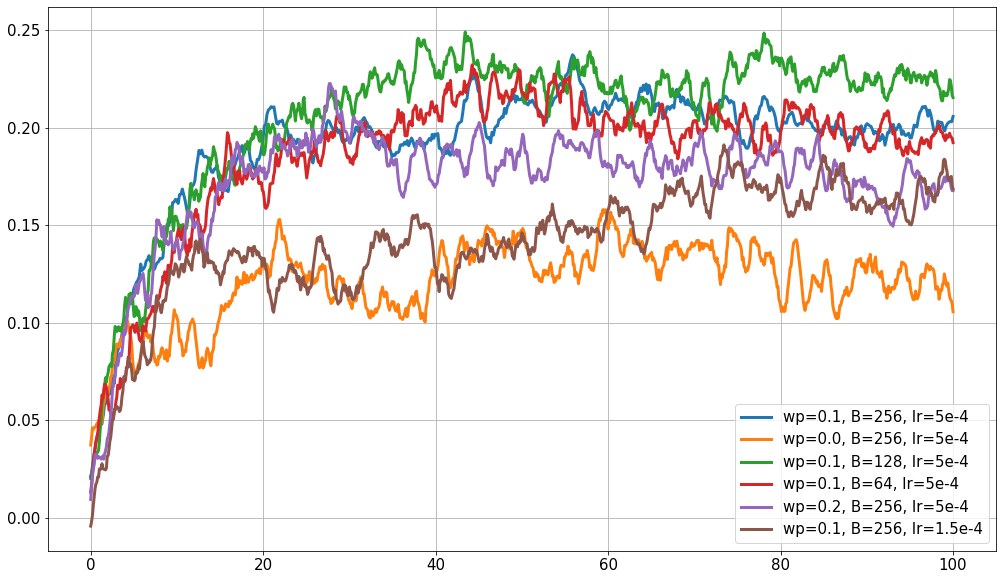

In [15]:
x_max = 100
fig = plt.figure(figsize=(17, 10))
ax = plt.gca()
size = None
for label, data in line_data.items():
    data_smooth = smooth_series(data, N=10)
    xs = np.linspace(start=0, stop=x_max, num=len(data_smooth))
    ax.plot(xs, data_smooth, label=label, lw=3)
for label, e, data in bert_data:
    data_smooth = smooth_series(data, N=15)
    xs = np.linspace(start=0, stop=e, num=len(data_smooth))
    ax.plot(xs, data_smooth, label=label, lw=1, linestyle="--", marker='.')
ax.legend()
ax.grid()
plt.show()

**Conclusions**
- Adam with $\eta=5\times10^{-4}$ may be the best learning algo (need to check 1.5e-3)
- warmup proportion is best at 10 epochs (no warmup or 20 warmup epochs are worse)
- optimal batch size is 128 (both 64 and 256 are slightly worse)